In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%time
from influxdb import InfluxDBClient
from  credentials import *
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import plotly.graph_objs as go

#import plotly.graph_objs as go
#from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

import os
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense




Wall time: 1.29 s


In [5]:
#connect to Database
def get_connect():
    client = InfluxDBClient(host=host, port=port, username=username, password=password)
    client.switch_database('orkney')
    return client


#Query Data
def get_Demand_data():
    client = get_connect()
    Demand = client.query('SELECT * FROM "Demand" WHERE time > now() - 2200d ORDER BY time')
    values = Demand.raw["series"][0]["values"]
    columns = Demand.raw["series"][0]["columns"]
    Demand = pd.DataFrame(values, columns=columns)#.set_index("time")
    return Demand



def explore_data(df):
    #df = get_Demand_data()
    df['Datetime'] = pd.to_datetime(df.time)
    df['year'] = df.Datetime.dt.year
    df['month'] = df.Datetime.dt.month
    df['day']=  df.Datetime.dt.day
    df['Hour']= df.Datetime.dt.hour
    df = df.drop(["time","year","month","day","Hour"],axis=1)
    df = df.set_index("Datetime")

    return df 



df = get_Demand_data()
df = explore_data(df)
df.head(2)

Total
Datetime                        
2016-02-26 02:09:59+00:00  16.56
2016-02-26 02:11:00+00:00  16.56

In [6]:
##################################
%time
if not os.path.exists('model'):
    os.makedirs('model')

if not os.path.exists('img'):
    os.makedirs('img')



# Hardcode all variables
batch_size_exp = 1
epoch_exp = 5
neurons_exp = 10
predict_values_exp = 60*24*30 #next minute
lag_exp=5


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


# fit an LSTM network to training data
def fit_lstm(train, batch_size=1, nb_epoch=5, neurons=10):
    # simple early stopping

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #mc = ModelCheckpoint(filepath="model/model1.h5", save_best_only=True)
  
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
        
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False#, callbacks=[mc,es]
                 )
        model.reset_states()
    model.save("model/model1.h5")
    return model
    #print(model.summary)

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]


Wall time: 0 ns


In [7]:
%time

# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]


# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model


lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Wall time: 0 ns
2374613/2374613 [==============================] - 3981s 2ms/step - loss: 2.6483e-04 - root_mean_squared_error: 0.0163


In [8]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()

for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1

    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)

        
        
    print('Minute=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


expectations = np.array(expectations)
predictions = np.array(predictions)

print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))


Minute=1, Predicted=17.204669, Expected=17.310000
Minute=2, Predicted=17.077319, Expected=17.310000
Minute=3, Predicted=17.131942, Expected=17.310000
Minute=4, Predicted=17.167376, Expected=17.310000
Minute=5, Predicted=17.256241, Expected=18.670000
Minute=6, Predicted=18.682776, Expected=18.670000
Minute=7, Predicted=18.788099, Expected=18.670000
Minute=8, Predicted=18.832369, Expected=18.670000
Minute=9, Predicted=18.896680, Expected=18.670000
Minute=10, Predicted=18.902348, Expected=18.670000
Minute=11, Predicted=18.950711, Expected=18.670000
Minute=12, Predicted=18.948734, Expected=20.240000
Minute=13, Predicted=20.593573, Expected=20.240000
Minute=14, Predicted=20.612527, Expected=20.240000
Minute=15, Predicted=20.749622, Expected=20.240000
Minute=16, Predicted=20.779559, Expected=20.240000
Minute=17, Predicted=20.990157, Expected=20.240000
Minute=18, Predicted=20.949523, Expected=20.240000
Minute=19, Predicted=21.171871, Expected=20.240000
Minute=20, Predicted=20.909492, Expected

Minute=165, Predicted=19.066771, Expected=19.080000
Minute=166, Predicted=19.066772, Expected=19.080000
Minute=167, Predicted=19.066771, Expected=19.080000
Minute=168, Predicted=19.066772, Expected=19.510000
Minute=169, Predicted=19.496771, Expected=19.510000
Minute=170, Predicted=19.496772, Expected=19.510000
Minute=171, Predicted=19.496771, Expected=19.510000
Minute=172, Predicted=19.496771, Expected=19.510000
Minute=173, Predicted=19.496771, Expected=19.510000
Minute=174, Predicted=19.496772, Expected=19.510000
Minute=175, Predicted=19.496772, Expected=18.970000
Minute=176, Predicted=18.956772, Expected=18.970000
Minute=177, Predicted=18.956771, Expected=18.970000
Minute=178, Predicted=18.956771, Expected=18.970000
Minute=179, Predicted=18.956772, Expected=18.970000
Minute=180, Predicted=18.956771, Expected=18.970000
Minute=181, Predicted=18.956772, Expected=18.970000
Minute=182, Predicted=18.956771, Expected=18.530000
Minute=183, Predicted=18.516771, Expected=18.530000
Minute=184, 

Minute=328, Predicted=21.226772, Expected=21.240000
Minute=329, Predicted=21.226771, Expected=21.240000
Minute=330, Predicted=21.226771, Expected=21.050000
Minute=331, Predicted=21.036770, Expected=21.050000
Minute=332, Predicted=21.036773, Expected=21.050000
Minute=333, Predicted=21.036773, Expected=21.050000
Minute=334, Predicted=21.036771, Expected=21.050000
Minute=335, Predicted=21.036771, Expected=21.050000
Minute=336, Predicted=21.036772, Expected=21.050000
Minute=337, Predicted=21.036770, Expected=21.510000
Minute=338, Predicted=21.496771, Expected=21.510000
Minute=339, Predicted=21.496771, Expected=21.510000
Minute=340, Predicted=21.496771, Expected=21.510000
Minute=341, Predicted=21.496771, Expected=21.510000
Minute=342, Predicted=21.496770, Expected=21.510000
Minute=343, Predicted=21.496773, Expected=21.510000
Minute=344, Predicted=21.496773, Expected=22.510000
Minute=345, Predicted=22.496771, Expected=22.510000
Minute=346, Predicted=22.496772, Expected=22.510000
Minute=347, 

Minute=490, Predicted=20.986772, Expected=21.000000
Minute=491, Predicted=20.986771, Expected=21.000000
Minute=492, Predicted=20.986771, Expected=21.000000
Minute=493, Predicted=20.986771, Expected=23.140000
Minute=494, Predicted=23.126772, Expected=23.140000
Minute=495, Predicted=23.126771, Expected=23.140000
Minute=496, Predicted=23.126772, Expected=23.140000
Minute=497, Predicted=23.126771, Expected=23.140000
Minute=498, Predicted=23.126771, Expected=23.140000
Minute=499, Predicted=23.126771, Expected=23.140000
Minute=500, Predicted=23.126772, Expected=22.600000
Minute=501, Predicted=22.586771, Expected=22.600000
Minute=502, Predicted=22.586772, Expected=22.600000
Minute=503, Predicted=22.586771, Expected=22.600000
Minute=504, Predicted=22.586771, Expected=22.600000
Minute=505, Predicted=22.586771, Expected=22.600000
Minute=506, Predicted=22.586772, Expected=22.600000
Minute=507, Predicted=22.586771, Expected=22.750000
Minute=508, Predicted=22.736772, Expected=22.750000
Minute=509, 

Minute=648, Predicted=19.076771, Expected=18.500000
Minute=649, Predicted=18.486771, Expected=18.500000
Minute=650, Predicted=18.486772, Expected=18.500000
Minute=651, Predicted=18.486771, Expected=18.500000
Minute=652, Predicted=18.486772, Expected=18.500000
Minute=653, Predicted=18.486771, Expected=18.500000
Minute=654, Predicted=18.486771, Expected=18.500000
Minute=655, Predicted=18.486771, Expected=18.740000
Minute=656, Predicted=18.726772, Expected=18.740000
Minute=657, Predicted=18.726771, Expected=18.740000
Minute=658, Predicted=18.726772, Expected=18.740000
Minute=659, Predicted=18.726771, Expected=18.740000
Minute=660, Predicted=18.726771, Expected=18.740000
Minute=661, Predicted=18.726771, Expected=18.740000
Minute=662, Predicted=18.726772, Expected=18.130000
Minute=663, Predicted=18.116771, Expected=18.130000
Minute=664, Predicted=18.116772, Expected=18.130000
Minute=665, Predicted=18.116771, Expected=18.130000
Minute=666, Predicted=18.116771, Expected=18.130000
Minute=667, 

Minute=810, Predicted=18.036771, Expected=18.050000
Minute=811, Predicted=18.036771, Expected=18.050000
Minute=812, Predicted=18.036772, Expected=18.610000
Minute=813, Predicted=18.596771, Expected=18.610000
Minute=814, Predicted=18.596772, Expected=18.610000
Minute=815, Predicted=18.596771, Expected=18.610000
Minute=816, Predicted=18.596771, Expected=18.610000
Minute=817, Predicted=18.596771, Expected=18.610000
Minute=818, Predicted=18.596772, Expected=18.610000
Minute=819, Predicted=18.596771, Expected=19.310000
Minute=820, Predicted=19.296772, Expected=19.310000
Minute=821, Predicted=19.296771, Expected=19.310000
Minute=822, Predicted=19.296771, Expected=19.310000
Minute=823, Predicted=19.296771, Expected=19.310000
Minute=824, Predicted=19.296772, Expected=19.310000
Minute=825, Predicted=19.296771, Expected=19.310000
Minute=826, Predicted=19.296772, Expected=20.180000
Minute=827, Predicted=20.166771, Expected=20.180000
Minute=828, Predicted=20.166771, Expected=20.180000
Minute=829, 

Minute=970, Predicted=22.266772, Expected=22.280000
Minute=971, Predicted=22.266771, Expected=22.130000
Minute=972, Predicted=22.116771, Expected=22.130000
Minute=973, Predicted=22.116771, Expected=22.130000
Minute=974, Predicted=22.116772, Expected=22.130000
Minute=975, Predicted=22.116771, Expected=22.130000
Minute=976, Predicted=22.116772, Expected=22.130000
Minute=977, Predicted=22.116771, Expected=22.130000
Minute=978, Predicted=22.116771, Expected=22.050000
Minute=979, Predicted=22.036771, Expected=22.050000
Minute=980, Predicted=22.036772, Expected=22.050000
Minute=981, Predicted=22.036771, Expected=22.050000
Minute=982, Predicted=22.036772, Expected=22.050000
Minute=983, Predicted=22.036771, Expected=22.050000
Minute=984, Predicted=22.036771, Expected=22.050000
Minute=985, Predicted=22.036771, Expected=19.490000
Minute=986, Predicted=19.476772, Expected=19.490000
Minute=987, Predicted=19.476771, Expected=19.490000
Minute=988, Predicted=19.476772, Expected=19.490000
Minute=989, 

Minute=1130, Predicted=20.216772, Expected=20.110000
Minute=1131, Predicted=20.096771, Expected=20.110000
Minute=1132, Predicted=20.096772, Expected=20.110000
Minute=1133, Predicted=20.096771, Expected=20.110000
Minute=1134, Predicted=20.096771, Expected=20.110000
Minute=1135, Predicted=20.096771, Expected=20.110000
Minute=1136, Predicted=20.096772, Expected=20.110000
Minute=1137, Predicted=20.096771, Expected=20.130000
Minute=1138, Predicted=20.116772, Expected=20.130000
Minute=1139, Predicted=20.116771, Expected=20.130000
Minute=1140, Predicted=20.116771, Expected=20.130000
Minute=1141, Predicted=20.116771, Expected=20.130000
Minute=1142, Predicted=20.116772, Expected=20.130000
Minute=1143, Predicted=20.116771, Expected=20.130000
Minute=1144, Predicted=20.116772, Expected=19.860000
Minute=1145, Predicted=19.846771, Expected=19.860000
Minute=1146, Predicted=19.846771, Expected=19.860000
Minute=1147, Predicted=19.846771, Expected=19.860000
Minute=1148, Predicted=19.846772, Expected=19.

Minute=1287, Predicted=24.026771, Expected=24.040000
Minute=1288, Predicted=24.026772, Expected=24.040000
Minute=1289, Predicted=24.026771, Expected=24.040000
Minute=1290, Predicted=24.026771, Expected=24.040000
Minute=1291, Predicted=24.026771, Expected=24.040000
Minute=1292, Predicted=24.026772, Expected=24.320000
Minute=1293, Predicted=24.306771, Expected=24.320000
Minute=1294, Predicted=24.306772, Expected=24.320000
Minute=1295, Predicted=24.306771, Expected=24.320000
Minute=1296, Predicted=24.306771, Expected=24.320000
Minute=1297, Predicted=24.306771, Expected=24.320000
Minute=1298, Predicted=24.306772, Expected=24.320000
Minute=1299, Predicted=24.306771, Expected=23.680000
Minute=1300, Predicted=23.666772, Expected=23.680000
Minute=1301, Predicted=23.666771, Expected=23.680000
Minute=1302, Predicted=23.666771, Expected=23.680000
Minute=1303, Predicted=23.666771, Expected=23.680000
Minute=1304, Predicted=23.666772, Expected=23.680000
Minute=1305, Predicted=23.666771, Expected=23.

Minute=1442, Predicted=22.086772, Expected=22.100000
Minute=1443, Predicted=22.086771, Expected=22.100000
Minute=1444, Predicted=22.086772, Expected=22.100000
Minute=1445, Predicted=22.086771, Expected=22.100000
Minute=1446, Predicted=22.086771, Expected=22.100000
Minute=1447, Predicted=22.086771, Expected=22.100000
Minute=1448, Predicted=22.086772, Expected=22.100000
Minute=1449, Predicted=22.086771, Expected=22.810000
Minute=1450, Predicted=22.796772, Expected=22.810000
Minute=1451, Predicted=22.796771, Expected=22.810000
Minute=1452, Predicted=22.796771, Expected=22.810000
Minute=1453, Predicted=22.796771, Expected=22.810000
Minute=1454, Predicted=22.796772, Expected=22.810000
Minute=1455, Predicted=22.796771, Expected=22.810000
Minute=1456, Predicted=22.796772, Expected=24.280000
Minute=1457, Predicted=24.266771, Expected=24.280000
Minute=1458, Predicted=24.266771, Expected=24.280000
Minute=1459, Predicted=24.266771, Expected=24.280000
Minute=1460, Predicted=24.266772, Expected=24.

Minute=1600, Predicted=21.706772, Expected=21.380000
Minute=1601, Predicted=21.366771, Expected=21.380000
Minute=1602, Predicted=21.366771, Expected=21.380000
Minute=1603, Predicted=21.366771, Expected=21.380000
Minute=1604, Predicted=21.366772, Expected=21.380000
Minute=1605, Predicted=21.366771, Expected=21.380000
Minute=1606, Predicted=21.366772, Expected=21.380000
Minute=1607, Predicted=21.366771, Expected=21.880000
Minute=1608, Predicted=21.866771, Expected=21.880000
Minute=1609, Predicted=21.866771, Expected=21.880000
Minute=1610, Predicted=21.866772, Expected=21.880000
Minute=1611, Predicted=21.866771, Expected=21.880000
Minute=1612, Predicted=21.866772, Expected=21.880000
Minute=1613, Predicted=21.866771, Expected=21.880000
Minute=1614, Predicted=21.866771, Expected=21.800000
Minute=1615, Predicted=21.786771, Expected=21.800000
Minute=1616, Predicted=21.786772, Expected=21.800000
Minute=1617, Predicted=21.786771, Expected=21.800000
Minute=1618, Predicted=21.786772, Expected=21.

Minute=1758, Predicted=22.036771, Expected=22.050000
Minute=1759, Predicted=22.036771, Expected=22.050000
Minute=1760, Predicted=22.036772, Expected=22.050000
Minute=1761, Predicted=22.036771, Expected=22.050000
Minute=1762, Predicted=22.036772, Expected=22.050000
Minute=1763, Predicted=22.036771, Expected=22.050000
Minute=1764, Predicted=22.036771, Expected=21.770000
Minute=1765, Predicted=21.756771, Expected=21.770000
Minute=1766, Predicted=21.756772, Expected=21.770000
Minute=1767, Predicted=21.756771, Expected=21.770000
Minute=1768, Predicted=21.756772, Expected=21.770000
Minute=1769, Predicted=21.756771, Expected=21.770000
Minute=1770, Predicted=21.756771, Expected=21.770000
Minute=1771, Predicted=21.756771, Expected=21.770000
Minute=1772, Predicted=21.756772, Expected=21.340000
Minute=1773, Predicted=21.326771, Expected=21.340000
Minute=1774, Predicted=21.326772, Expected=21.340000
Minute=1775, Predicted=21.326771, Expected=21.340000
Minute=1776, Predicted=21.326771, Expected=21.

Minute=1914, Predicted=21.996771, Expected=21.500000
Minute=1915, Predicted=21.486771, Expected=21.500000
Minute=1916, Predicted=21.486772, Expected=21.500000
Minute=1917, Predicted=21.486771, Expected=21.500000
Minute=1918, Predicted=21.486772, Expected=21.500000
Minute=1919, Predicted=21.486771, Expected=21.500000
Minute=1920, Predicted=21.486771, Expected=21.500000
Minute=1921, Predicted=21.486771, Expected=21.330000
Minute=1922, Predicted=21.316772, Expected=21.330000
Minute=1923, Predicted=21.316771, Expected=21.330000
Minute=1924, Predicted=21.316772, Expected=21.330000
Minute=1925, Predicted=21.316771, Expected=21.330000
Minute=1926, Predicted=21.316771, Expected=21.330000
Minute=1927, Predicted=21.316771, Expected=21.330000
Minute=1928, Predicted=21.316772, Expected=22.020000
Minute=1929, Predicted=22.006771, Expected=22.020000
Minute=1930, Predicted=22.006772, Expected=22.020000
Minute=1931, Predicted=22.006771, Expected=22.020000
Minute=1932, Predicted=22.006771, Expected=22.

Minute=2073, Predicted=19.036771, Expected=19.050000
Minute=2074, Predicted=19.036772, Expected=19.050000
Minute=2075, Predicted=19.036771, Expected=19.050000
Minute=2076, Predicted=19.036771, Expected=19.050000
Minute=2077, Predicted=19.036771, Expected=20.620000
Minute=2078, Predicted=20.606772, Expected=20.620000
Minute=2079, Predicted=20.606771, Expected=20.620000
Minute=2080, Predicted=20.606772, Expected=20.620000
Minute=2081, Predicted=20.606771, Expected=20.620000
Minute=2082, Predicted=20.606771, Expected=20.620000
Minute=2083, Predicted=20.606771, Expected=20.620000
Minute=2084, Predicted=20.606772, Expected=19.490000
Minute=2085, Predicted=19.476771, Expected=19.490000
Minute=2086, Predicted=19.476772, Expected=19.490000
Minute=2087, Predicted=19.476771, Expected=19.490000
Minute=2088, Predicted=19.476771, Expected=19.490000
Minute=2089, Predicted=19.476771, Expected=19.490000
Minute=2090, Predicted=19.476772, Expected=19.490000
Minute=2091, Predicted=19.476771, Expected=19.

Minute=2228, Predicted=17.396772, Expected=17.410000
Minute=2229, Predicted=17.396771, Expected=17.410000
Minute=2230, Predicted=17.396772, Expected=17.410000
Minute=2231, Predicted=17.396771, Expected=17.410000
Minute=2232, Predicted=17.396771, Expected=19.230000
Minute=2233, Predicted=19.216771, Expected=19.230000
Minute=2234, Predicted=19.216772, Expected=19.230000
Minute=2235, Predicted=19.216771, Expected=19.230000
Minute=2236, Predicted=19.216772, Expected=19.230000
Minute=2237, Predicted=19.216771, Expected=19.230000
Minute=2238, Predicted=19.216771, Expected=19.230000
Minute=2239, Predicted=19.216771, Expected=19.230000
Minute=2240, Predicted=19.216772, Expected=19.410000
Minute=2241, Predicted=19.396771, Expected=19.410000
Minute=2242, Predicted=19.396772, Expected=19.410000
Minute=2243, Predicted=19.396771, Expected=19.410000
Minute=2244, Predicted=19.396771, Expected=19.410000
Minute=2245, Predicted=19.396771, Expected=19.410000
Minute=2246, Predicted=19.396772, Expected=19.

Minute=2388, Predicted=19.196771, Expected=19.210000
Minute=2389, Predicted=19.196771, Expected=19.210000
Minute=2390, Predicted=19.196772, Expected=19.210000
Minute=2391, Predicted=19.196771, Expected=19.210000
Minute=2392, Predicted=19.196772, Expected=18.990000
Minute=2393, Predicted=18.976771, Expected=18.990000
Minute=2394, Predicted=18.976771, Expected=18.990000
Minute=2395, Predicted=18.976771, Expected=18.990000
Minute=2396, Predicted=18.976772, Expected=18.990000
Minute=2397, Predicted=18.976771, Expected=18.990000
Minute=2398, Predicted=18.976772, Expected=18.990000
Minute=2399, Predicted=18.976771, Expected=19.180000
Minute=2400, Predicted=19.166771, Expected=19.180000
Minute=2401, Predicted=19.166771, Expected=19.180000
Minute=2402, Predicted=19.166772, Expected=19.180000
Minute=2403, Predicted=19.166771, Expected=19.180000
Minute=2404, Predicted=19.166772, Expected=19.180000
Minute=2405, Predicted=19.166771, Expected=19.180000
Minute=2406, Predicted=19.166771, Expected=18.

Minute=2545, Predicted=17.516771, Expected=17.530000
Minute=2546, Predicted=17.516772, Expected=17.530000
Minute=2547, Predicted=17.516771, Expected=17.530000
Minute=2548, Predicted=17.516772, Expected=17.530000
Minute=2549, Predicted=17.516771, Expected=17.530000
Minute=2550, Predicted=17.516771, Expected=17.530000
Minute=2551, Predicted=17.516771, Expected=17.920000
Minute=2552, Predicted=17.906772, Expected=17.920000
Minute=2553, Predicted=17.906771, Expected=17.920000
Minute=2554, Predicted=17.906772, Expected=17.920000
Minute=2555, Predicted=17.906771, Expected=17.920000
Minute=2556, Predicted=17.906771, Expected=17.920000
Minute=2557, Predicted=17.906771, Expected=19.150000
Minute=2558, Predicted=19.136772, Expected=19.150000
Minute=2559, Predicted=19.136771, Expected=19.150000
Minute=2560, Predicted=19.136772, Expected=19.150000
Minute=2561, Predicted=19.136771, Expected=19.150000
Minute=2562, Predicted=19.136771, Expected=19.150000
Minute=2563, Predicted=19.136771, Expected=19.

Minute=2700, Predicted=18.716771, Expected=18.730000
Minute=2701, Predicted=18.716771, Expected=18.730000
Minute=2702, Predicted=18.716772, Expected=18.730000
Minute=2703, Predicted=18.716771, Expected=18.880000
Minute=2704, Predicted=18.866772, Expected=18.880000
Minute=2705, Predicted=18.866771, Expected=18.880000
Minute=2706, Predicted=18.866771, Expected=18.880000
Minute=2707, Predicted=18.866771, Expected=18.880000
Minute=2708, Predicted=18.866772, Expected=18.880000
Minute=2709, Predicted=18.866771, Expected=18.880000
Minute=2710, Predicted=18.866772, Expected=19.020000
Minute=2711, Predicted=19.006771, Expected=19.020000
Minute=2712, Predicted=19.006771, Expected=19.020000
Minute=2713, Predicted=19.006771, Expected=19.020000
Minute=2714, Predicted=19.006772, Expected=19.020000
Minute=2715, Predicted=19.006771, Expected=19.020000
Minute=2716, Predicted=19.006772, Expected=19.020000
Minute=2717, Predicted=19.006771, Expected=19.910000
Minute=2718, Predicted=19.896771, Expected=19.

Minute=2859, Predicted=21.566771, Expected=21.580000
Minute=2860, Predicted=21.566772, Expected=21.580000
Minute=2861, Predicted=21.566771, Expected=21.580000
Minute=2862, Predicted=21.566771, Expected=21.580000
Minute=2863, Predicted=21.566771, Expected=21.580000
Minute=2864, Predicted=21.566772, Expected=21.720000
Minute=2865, Predicted=21.706771, Expected=21.720000
Minute=2866, Predicted=21.706772, Expected=21.720000
Minute=2867, Predicted=21.706771, Expected=21.720000
Minute=2868, Predicted=21.706771, Expected=21.720000
Minute=2869, Predicted=21.706771, Expected=21.720000
Minute=2870, Predicted=21.706772, Expected=21.720000
Minute=2871, Predicted=21.706771, Expected=21.420000
Minute=2872, Predicted=21.406772, Expected=21.420000
Minute=2873, Predicted=21.406771, Expected=21.420000
Minute=2874, Predicted=21.406771, Expected=21.420000
Minute=2875, Predicted=21.406771, Expected=21.420000
Minute=2876, Predicted=21.406772, Expected=21.420000
Minute=2877, Predicted=21.406771, Expected=21.

Minute=3018, Predicted=22.336771, Expected=22.350000
Minute=3019, Predicted=22.336771, Expected=22.350000
Minute=3020, Predicted=22.336772, Expected=22.350000
Minute=3021, Predicted=22.336771, Expected=22.350000
Minute=3022, Predicted=22.336772, Expected=22.350000
Minute=3023, Predicted=22.336771, Expected=22.350000
Minute=3024, Predicted=22.336771, Expected=22.350000
Minute=3025, Predicted=22.336771, Expected=22.350000
Minute=3026, Predicted=22.336772, Expected=22.350000
Minute=3027, Predicted=22.336771, Expected=22.350000
Minute=3028, Predicted=22.336772, Expected=22.350000
Minute=3029, Predicted=22.336771, Expected=22.350000
Minute=3030, Predicted=22.336771, Expected=22.350000
Minute=3031, Predicted=22.336771, Expected=22.350000
Minute=3032, Predicted=22.336772, Expected=22.140000
Minute=3033, Predicted=22.126771, Expected=22.140000
Minute=3034, Predicted=22.126772, Expected=22.140000
Minute=3035, Predicted=22.126771, Expected=22.140000
Minute=3036, Predicted=22.126771, Expected=22.

Minute=3173, Predicted=21.406771, Expected=21.420000
Minute=3174, Predicted=21.406771, Expected=21.420000
Minute=3175, Predicted=21.406771, Expected=21.420000
Minute=3176, Predicted=21.406772, Expected=21.420000
Minute=3177, Predicted=21.406771, Expected=21.450000
Minute=3178, Predicted=21.436772, Expected=21.450000
Minute=3179, Predicted=21.436771, Expected=21.450000
Minute=3180, Predicted=21.436771, Expected=21.450000
Minute=3181, Predicted=21.436771, Expected=21.450000
Minute=3182, Predicted=21.436772, Expected=21.450000
Minute=3183, Predicted=21.436771, Expected=21.450000
Minute=3184, Predicted=21.436772, Expected=21.120000
Minute=3185, Predicted=21.106771, Expected=21.120000
Minute=3186, Predicted=21.106771, Expected=21.120000
Minute=3187, Predicted=21.106771, Expected=21.120000
Minute=3188, Predicted=21.106772, Expected=21.120000
Minute=3189, Predicted=21.106771, Expected=21.120000
Minute=3190, Predicted=21.106772, Expected=21.120000
Minute=3191, Predicted=21.106771, Expected=22.

Minute=3330, Predicted=22.056771, Expected=22.070000
Minute=3331, Predicted=22.056771, Expected=22.070000
Minute=3332, Predicted=22.056772, Expected=22.070000
Minute=3333, Predicted=22.056771, Expected=22.070000
Minute=3334, Predicted=22.056772, Expected=21.810000
Minute=3335, Predicted=21.796771, Expected=21.810000
Minute=3336, Predicted=21.796771, Expected=21.810000
Minute=3337, Predicted=21.796771, Expected=21.810000
Minute=3338, Predicted=21.796772, Expected=21.810000
Minute=3339, Predicted=21.796771, Expected=21.810000
Minute=3340, Predicted=21.796772, Expected=21.810000
Minute=3341, Predicted=21.796771, Expected=21.530000
Minute=3342, Predicted=21.516771, Expected=21.530000
Minute=3343, Predicted=21.516771, Expected=21.530000
Minute=3344, Predicted=21.516772, Expected=21.530000
Minute=3345, Predicted=21.516771, Expected=21.530000
Minute=3346, Predicted=21.516772, Expected=21.530000
Minute=3347, Predicted=21.516771, Expected=21.530000
Minute=3348, Predicted=21.516771, Expected=21.

Minute=3485, Predicted=21.656771, Expected=21.670000
Minute=3486, Predicted=21.656771, Expected=21.670000
Minute=3487, Predicted=21.656771, Expected=21.670000
Minute=3488, Predicted=21.656772, Expected=21.670000
Minute=3489, Predicted=21.656771, Expected=21.670000
Minute=3490, Predicted=21.656772, Expected=20.050000
Minute=3491, Predicted=20.036771, Expected=20.050000
Minute=3492, Predicted=20.036771, Expected=20.050000
Minute=3493, Predicted=20.036771, Expected=20.050000
Minute=3494, Predicted=20.036772, Expected=20.050000
Minute=3495, Predicted=20.036771, Expected=20.050000
Minute=3496, Predicted=20.036772, Expected=20.050000
Minute=3497, Predicted=20.036771, Expected=18.730000
Minute=3498, Predicted=18.716771, Expected=18.730000
Minute=3499, Predicted=18.716771, Expected=18.730000
Minute=3500, Predicted=18.716772, Expected=18.730000
Minute=3501, Predicted=18.716771, Expected=18.730000
Minute=3502, Predicted=18.716772, Expected=18.730000
Minute=3503, Predicted=18.716771, Expected=18.

Minute=3644, Predicted=17.016772, Expected=17.030000
Minute=3645, Predicted=17.016771, Expected=17.030000
Minute=3646, Predicted=17.016772, Expected=17.030000
Minute=3647, Predicted=17.016771, Expected=17.030000
Minute=3648, Predicted=17.016771, Expected=17.030000
Minute=3649, Predicted=17.016771, Expected=17.030000
Minute=3650, Predicted=17.016772, Expected=17.400000
Minute=3651, Predicted=17.386771, Expected=17.400000
Minute=3652, Predicted=17.386772, Expected=17.400000
Minute=3653, Predicted=17.386771, Expected=17.400000
Minute=3654, Predicted=17.386771, Expected=17.400000
Minute=3655, Predicted=17.386771, Expected=17.400000
Minute=3656, Predicted=17.386772, Expected=17.400000
Minute=3657, Predicted=17.386771, Expected=17.860000
Minute=3658, Predicted=17.846772, Expected=17.860000
Minute=3659, Predicted=17.846771, Expected=17.860000
Minute=3660, Predicted=17.846771, Expected=17.860000
Minute=3661, Predicted=17.846771, Expected=17.860000
Minute=3662, Predicted=17.846772, Expected=17.

Minute=3802, Predicted=20.006772, Expected=20.020000
Minute=3803, Predicted=20.006771, Expected=20.020000
Minute=3804, Predicted=20.006771, Expected=18.490000
Minute=3805, Predicted=18.476771, Expected=18.490000
Minute=3806, Predicted=18.476772, Expected=18.490000
Minute=3807, Predicted=18.476771, Expected=18.490000
Minute=3808, Predicted=18.476772, Expected=18.490000
Minute=3809, Predicted=18.476771, Expected=18.490000
Minute=3810, Predicted=18.476771, Expected=18.490000
Minute=3811, Predicted=18.476771, Expected=18.490000
Minute=3812, Predicted=18.476772, Expected=18.490000
Minute=3813, Predicted=18.476771, Expected=18.490000
Minute=3814, Predicted=18.476772, Expected=18.490000
Minute=3815, Predicted=18.476771, Expected=18.490000
Minute=3816, Predicted=18.476771, Expected=18.490000
Minute=3817, Predicted=18.476771, Expected=19.570000
Minute=3818, Predicted=19.556772, Expected=19.570000
Minute=3819, Predicted=19.556771, Expected=19.570000
Minute=3820, Predicted=19.556772, Expected=19.

Minute=3957, Predicted=19.746771, Expected=19.760000
Minute=3958, Predicted=19.746772, Expected=19.760000
Minute=3959, Predicted=19.746771, Expected=19.760000
Minute=3960, Predicted=19.746771, Expected=19.760000
Minute=3961, Predicted=19.746771, Expected=19.110000
Minute=3962, Predicted=19.096772, Expected=19.110000
Minute=3963, Predicted=19.096771, Expected=19.110000
Minute=3964, Predicted=19.096772, Expected=19.110000
Minute=3965, Predicted=19.096771, Expected=19.110000
Minute=3966, Predicted=19.096771, Expected=19.110000
Minute=3967, Predicted=19.096771, Expected=19.110000
Minute=3968, Predicted=19.096772, Expected=19.770000
Minute=3969, Predicted=19.756771, Expected=19.770000
Minute=3970, Predicted=19.756772, Expected=19.770000
Minute=3971, Predicted=19.756771, Expected=19.770000
Minute=3972, Predicted=19.756771, Expected=19.770000
Minute=3973, Predicted=19.756771, Expected=19.770000
Minute=3974, Predicted=19.756772, Expected=19.770000
Minute=3975, Predicted=19.756771, Expected=19.

Minute=4115, Predicted=20.706771, Expected=20.220000
Minute=4116, Predicted=20.206771, Expected=20.220000
Minute=4117, Predicted=20.206771, Expected=20.220000
Minute=4118, Predicted=20.206772, Expected=20.220000
Minute=4119, Predicted=20.206771, Expected=20.220000
Minute=4120, Predicted=20.206772, Expected=20.220000
Minute=4121, Predicted=20.206771, Expected=20.220000
Minute=4122, Predicted=20.206771, Expected=21.360000
Minute=4123, Predicted=21.346771, Expected=21.360000
Minute=4124, Predicted=21.346772, Expected=21.360000
Minute=4125, Predicted=21.346771, Expected=21.360000
Minute=4126, Predicted=21.346772, Expected=21.360000
Minute=4127, Predicted=21.346771, Expected=21.360000
Minute=4128, Predicted=21.346771, Expected=21.360000
Minute=4129, Predicted=21.346771, Expected=21.720000
Minute=4130, Predicted=21.706772, Expected=21.720000
Minute=4131, Predicted=21.706771, Expected=21.720000
Minute=4132, Predicted=21.706772, Expected=21.720000
Minute=4133, Predicted=21.706771, Expected=21.

Minute=4273, Predicted=24.176771, Expected=24.190000
Minute=4274, Predicted=24.176772, Expected=24.190000
Minute=4275, Predicted=24.176771, Expected=24.190000
Minute=4276, Predicted=24.176772, Expected=24.190000
Minute=4277, Predicted=24.176771, Expected=24.190000
Minute=4278, Predicted=24.176771, Expected=24.190000
Minute=4279, Predicted=24.176771, Expected=23.580000
Minute=4280, Predicted=23.566772, Expected=23.580000
Minute=4281, Predicted=23.566771, Expected=23.580000
Minute=4282, Predicted=23.566772, Expected=23.580000
Minute=4283, Predicted=23.566771, Expected=23.580000
Minute=4284, Predicted=23.566771, Expected=23.580000
Minute=4285, Predicted=23.566771, Expected=23.580000
Minute=4286, Predicted=23.566772, Expected=23.580000
Minute=4287, Predicted=23.566771, Expected=23.580000
Minute=4288, Predicted=23.566772, Expected=23.580000
Minute=4289, Predicted=23.566771, Expected=23.580000
Minute=4290, Predicted=23.566771, Expected=23.580000
Minute=4291, Predicted=23.566771, Expected=23.

Minute=4432, Predicted=24.116772, Expected=24.130000
Minute=4433, Predicted=24.116771, Expected=24.130000
Minute=4434, Predicted=24.116771, Expected=24.170000
Minute=4435, Predicted=24.156771, Expected=24.170000
Minute=4436, Predicted=24.156772, Expected=24.170000
Minute=4437, Predicted=24.156771, Expected=24.170000
Minute=4438, Predicted=24.156772, Expected=24.170000
Minute=4439, Predicted=24.156771, Expected=24.170000
Minute=4440, Predicted=24.156771, Expected=24.170000
Minute=4441, Predicted=24.156771, Expected=22.600000
Minute=4442, Predicted=22.586772, Expected=22.600000
Minute=4443, Predicted=22.586771, Expected=22.600000
Minute=4444, Predicted=22.586772, Expected=22.600000
Minute=4445, Predicted=22.586771, Expected=22.600000
Minute=4446, Predicted=22.586771, Expected=22.600000
Minute=4447, Predicted=22.586771, Expected=22.600000
Minute=4448, Predicted=22.586772, Expected=22.700000
Minute=4449, Predicted=22.686771, Expected=22.700000
Minute=4450, Predicted=22.686772, Expected=22.

Minute=4589, Predicted=23.966771, Expected=23.880000
Minute=4590, Predicted=23.866771, Expected=23.880000
Minute=4591, Predicted=23.866771, Expected=23.880000
Minute=4592, Predicted=23.866772, Expected=23.880000
Minute=4593, Predicted=23.866771, Expected=23.880000
Minute=4594, Predicted=23.866772, Expected=23.880000
Minute=4595, Predicted=23.866771, Expected=23.880000
Minute=4596, Predicted=23.866771, Expected=23.880000
Minute=4597, Predicted=23.866771, Expected=23.940000
Minute=4598, Predicted=23.926772, Expected=23.940000
Minute=4599, Predicted=23.926771, Expected=23.940000
Minute=4600, Predicted=23.926772, Expected=23.940000
Minute=4601, Predicted=23.926771, Expected=23.940000
Minute=4602, Predicted=23.926771, Expected=23.940000
Minute=4603, Predicted=23.926771, Expected=23.940000
Minute=4604, Predicted=23.926772, Expected=24.600000
Minute=4605, Predicted=24.586771, Expected=24.600000
Minute=4606, Predicted=24.586772, Expected=24.600000
Minute=4607, Predicted=24.586771, Expected=24.

Minute=4744, Predicted=22.406772, Expected=22.420000
Minute=4745, Predicted=22.406771, Expected=22.420000
Minute=4746, Predicted=22.406771, Expected=22.040000
Minute=4747, Predicted=22.026771, Expected=22.040000
Minute=4748, Predicted=22.026772, Expected=22.040000
Minute=4749, Predicted=22.026771, Expected=22.040000
Minute=4750, Predicted=22.026772, Expected=22.040000
Minute=4751, Predicted=22.026771, Expected=22.040000
Minute=4752, Predicted=22.026771, Expected=22.040000
Minute=4753, Predicted=22.026771, Expected=22.040000
Minute=4754, Predicted=22.026772, Expected=22.610000
Minute=4755, Predicted=22.596771, Expected=22.610000
Minute=4756, Predicted=22.596772, Expected=22.610000
Minute=4757, Predicted=22.596771, Expected=22.610000
Minute=4758, Predicted=22.596771, Expected=22.610000
Minute=4759, Predicted=22.596771, Expected=22.610000
Minute=4760, Predicted=22.596772, Expected=22.610000
Minute=4761, Predicted=22.596771, Expected=22.230000
Minute=4762, Predicted=22.216772, Expected=22.

Minute=4904, Predicted=17.996772, Expected=18.010000
Minute=4905, Predicted=17.996771, Expected=18.010000
Minute=4906, Predicted=17.996772, Expected=18.010000
Minute=4907, Predicted=17.996771, Expected=18.010000
Minute=4908, Predicted=17.996771, Expected=18.010000
Minute=4909, Predicted=17.996771, Expected=17.580000
Minute=4910, Predicted=17.566772, Expected=17.580000
Minute=4911, Predicted=17.566771, Expected=17.580000
Minute=4912, Predicted=17.566772, Expected=17.580000
Minute=4913, Predicted=17.566771, Expected=17.580000
Minute=4914, Predicted=17.566771, Expected=17.580000
Minute=4915, Predicted=17.566771, Expected=17.580000
Minute=4916, Predicted=17.566772, Expected=17.580000
Minute=4917, Predicted=17.566771, Expected=17.820000
Minute=4918, Predicted=17.806772, Expected=17.820000
Minute=4919, Predicted=17.806771, Expected=17.820000
Minute=4920, Predicted=17.806771, Expected=17.820000
Minute=4921, Predicted=17.806771, Expected=17.820000
Minute=4922, Predicted=17.806772, Expected=17.

Minute=5062, Predicted=19.846772, Expected=19.860000
Minute=5063, Predicted=19.846771, Expected=19.860000
Minute=5064, Predicted=19.846771, Expected=19.900000
Minute=5065, Predicted=19.886771, Expected=19.900000
Minute=5066, Predicted=19.886772, Expected=19.900000
Minute=5067, Predicted=19.886771, Expected=19.900000
Minute=5068, Predicted=19.886772, Expected=19.900000
Minute=5069, Predicted=19.886771, Expected=19.900000
Minute=5070, Predicted=19.886771, Expected=19.900000
Minute=5071, Predicted=19.886771, Expected=20.220000
Minute=5072, Predicted=20.206772, Expected=20.220000
Minute=5073, Predicted=20.206771, Expected=20.220000
Minute=5074, Predicted=20.206772, Expected=20.220000
Minute=5075, Predicted=20.206771, Expected=20.220000
Minute=5076, Predicted=20.206771, Expected=20.220000
Minute=5077, Predicted=20.206771, Expected=20.220000
Minute=5078, Predicted=20.206772, Expected=19.220000
Minute=5079, Predicted=19.206771, Expected=19.220000
Minute=5080, Predicted=19.206772, Expected=19.

Minute=5221, Predicted=19.546771, Expected=19.500000
Minute=5222, Predicted=19.486772, Expected=19.500000
Minute=5223, Predicted=19.486771, Expected=19.500000
Minute=5224, Predicted=19.486772, Expected=19.500000
Minute=5225, Predicted=19.486771, Expected=19.500000
Minute=5226, Predicted=19.486771, Expected=19.500000
Minute=5227, Predicted=19.486771, Expected=19.500000
Minute=5228, Predicted=19.486772, Expected=17.260000
Minute=5229, Predicted=17.246771, Expected=17.260000
Minute=5230, Predicted=17.246772, Expected=17.260000
Minute=5231, Predicted=17.246771, Expected=17.260000
Minute=5232, Predicted=17.246771, Expected=17.260000
Minute=5233, Predicted=17.246771, Expected=17.260000
Minute=5234, Predicted=17.246772, Expected=17.260000
Minute=5235, Predicted=17.246771, Expected=19.430000
Minute=5236, Predicted=19.416772, Expected=19.430000
Minute=5237, Predicted=19.416771, Expected=19.430000
Minute=5238, Predicted=19.416771, Expected=19.430000
Minute=5239, Predicted=19.416771, Expected=19.

Minute=5377, Predicted=24.056771, Expected=24.070000
Minute=5378, Predicted=24.056772, Expected=24.070000
Minute=5379, Predicted=24.056771, Expected=24.040000
Minute=5380, Predicted=24.026772, Expected=25.040000
Minute=5381, Predicted=25.026771, Expected=25.040000
Minute=5382, Predicted=25.026771, Expected=25.040000
Minute=5383, Predicted=25.026771, Expected=25.040000
Minute=5384, Predicted=25.026772, Expected=25.040000
Minute=5385, Predicted=25.026771, Expected=25.040000
Minute=5386, Predicted=25.026772, Expected=25.510000
Minute=5387, Predicted=25.496771, Expected=25.510000
Minute=5388, Predicted=25.496771, Expected=25.510000
Minute=5389, Predicted=25.496771, Expected=25.510000
Minute=5390, Predicted=25.496772, Expected=25.510000
Minute=5391, Predicted=25.496771, Expected=25.510000
Minute=5392, Predicted=25.496772, Expected=25.510000
Minute=5393, Predicted=25.496771, Expected=25.620000
Minute=5394, Predicted=25.606771, Expected=25.620000
Minute=5395, Predicted=25.606771, Expected=25.

Minute=5532, Predicted=25.126771, Expected=25.140000
Minute=5533, Predicted=25.126771, Expected=25.140000
Minute=5534, Predicted=25.126772, Expected=25.140000
Minute=5535, Predicted=25.126771, Expected=25.060000
Minute=5536, Predicted=25.046772, Expected=25.060000
Minute=5537, Predicted=25.046771, Expected=25.060000
Minute=5538, Predicted=25.046771, Expected=25.060000
Minute=5539, Predicted=25.046771, Expected=25.060000
Minute=5540, Predicted=25.046772, Expected=25.060000
Minute=5541, Predicted=25.046771, Expected=25.060000
Minute=5542, Predicted=25.046772, Expected=23.890000
Minute=5543, Predicted=23.876771, Expected=23.890000
Minute=5544, Predicted=23.876771, Expected=23.890000
Minute=5545, Predicted=23.876771, Expected=23.890000
Minute=5546, Predicted=23.876772, Expected=23.890000
Minute=5547, Predicted=23.876771, Expected=23.890000
Minute=5548, Predicted=23.876772, Expected=23.890000
Minute=5549, Predicted=23.876771, Expected=23.460000
Minute=5550, Predicted=23.446771, Expected=23.

Minute=5692, Predicted=24.166772, Expected=24.720000
Minute=5693, Predicted=24.706771, Expected=24.720000
Minute=5694, Predicted=24.706771, Expected=24.720000
Minute=5695, Predicted=24.706771, Expected=24.720000
Minute=5696, Predicted=24.706772, Expected=24.720000
Minute=5697, Predicted=24.706771, Expected=24.720000
Minute=5698, Predicted=24.706772, Expected=24.720000
Minute=5699, Predicted=24.706771, Expected=25.880000
Minute=5700, Predicted=25.866771, Expected=25.880000
Minute=5701, Predicted=25.866771, Expected=25.880000
Minute=5702, Predicted=25.866772, Expected=25.880000
Minute=5703, Predicted=25.866771, Expected=25.880000
Minute=5704, Predicted=25.866772, Expected=25.880000
Minute=5705, Predicted=25.866771, Expected=25.880000
Minute=5706, Predicted=25.866771, Expected=25.200000
Minute=5707, Predicted=25.186771, Expected=25.200000
Minute=5708, Predicted=25.186772, Expected=25.200000
Minute=5709, Predicted=25.186771, Expected=25.200000
Minute=5710, Predicted=25.186772, Expected=25.

Minute=5850, Predicted=23.066771, Expected=23.080000
Minute=5851, Predicted=23.066771, Expected=23.080000
Minute=5852, Predicted=23.066772, Expected=23.080000
Minute=5853, Predicted=23.066771, Expected=23.080000
Minute=5854, Predicted=23.066772, Expected=23.080000
Minute=5855, Predicted=23.066771, Expected=23.080000
Minute=5856, Predicted=23.066771, Expected=23.530000
Minute=5857, Predicted=23.516771, Expected=23.530000
Minute=5858, Predicted=23.516772, Expected=23.530000
Minute=5859, Predicted=23.516771, Expected=23.530000
Minute=5860, Predicted=23.516772, Expected=23.530000
Minute=5861, Predicted=23.516771, Expected=23.530000
Minute=5862, Predicted=23.516771, Expected=23.530000
Minute=5863, Predicted=23.516771, Expected=23.050000
Minute=5864, Predicted=23.036772, Expected=23.050000
Minute=5865, Predicted=23.036771, Expected=23.050000
Minute=5866, Predicted=23.036772, Expected=23.050000
Minute=5867, Predicted=23.036771, Expected=23.050000
Minute=5868, Predicted=23.036771, Expected=23.

Minute=6009, Predicted=23.066771, Expected=23.080000
Minute=6010, Predicted=23.066772, Expected=23.080000
Minute=6011, Predicted=23.066771, Expected=23.080000
Minute=6012, Predicted=23.066771, Expected=23.080000
Minute=6013, Predicted=23.066771, Expected=23.080000
Minute=6014, Predicted=23.066772, Expected=23.170000
Minute=6015, Predicted=23.156771, Expected=23.170000
Minute=6016, Predicted=23.156772, Expected=23.170000
Minute=6017, Predicted=23.156771, Expected=23.170000
Minute=6018, Predicted=23.156771, Expected=23.170000
Minute=6019, Predicted=23.156771, Expected=23.170000
Minute=6020, Predicted=23.156772, Expected=23.170000
Minute=6021, Predicted=23.156771, Expected=22.530000
Minute=6022, Predicted=22.516772, Expected=22.530000
Minute=6023, Predicted=22.516771, Expected=22.530000
Minute=6024, Predicted=22.516771, Expected=22.530000
Minute=6025, Predicted=22.516771, Expected=22.530000
Minute=6026, Predicted=22.516772, Expected=22.530000
Minute=6027, Predicted=22.516771, Expected=22.

Minute=6167, Predicted=22.096771, Expected=22.110000
Minute=6168, Predicted=22.096771, Expected=21.110000
Minute=6169, Predicted=21.096771, Expected=21.110000
Minute=6170, Predicted=21.096772, Expected=21.110000
Minute=6171, Predicted=21.096771, Expected=21.110000
Minute=6172, Predicted=21.096772, Expected=21.110000
Minute=6173, Predicted=21.096771, Expected=21.110000
Minute=6174, Predicted=21.096771, Expected=21.110000
Minute=6175, Predicted=21.096771, Expected=22.170000
Minute=6176, Predicted=22.156772, Expected=22.170000
Minute=6177, Predicted=22.156771, Expected=22.170000
Minute=6178, Predicted=22.156772, Expected=22.170000
Minute=6179, Predicted=22.156771, Expected=22.170000
Minute=6180, Predicted=22.156771, Expected=22.170000
Minute=6181, Predicted=22.156771, Expected=22.170000
Minute=6182, Predicted=22.156772, Expected=22.170000
Minute=6183, Predicted=22.156771, Expected=22.350000
Minute=6184, Predicted=22.336772, Expected=22.350000
Minute=6185, Predicted=22.336771, Expected=22.

Minute=6322, Predicted=18.286772, Expected=18.930000
Minute=6323, Predicted=18.916771, Expected=18.930000
Minute=6324, Predicted=18.916771, Expected=18.930000
Minute=6325, Predicted=18.916771, Expected=18.930000
Minute=6326, Predicted=18.916772, Expected=18.930000
Minute=6327, Predicted=18.916771, Expected=18.930000
Minute=6328, Predicted=18.916772, Expected=18.930000
Minute=6329, Predicted=18.916771, Expected=18.110000
Minute=6330, Predicted=18.096771, Expected=18.110000
Minute=6331, Predicted=18.096771, Expected=18.110000
Minute=6332, Predicted=18.096772, Expected=18.110000
Minute=6333, Predicted=18.096771, Expected=18.110000
Minute=6334, Predicted=18.096772, Expected=18.110000
Minute=6335, Predicted=18.096771, Expected=18.110000
Minute=6336, Predicted=18.096771, Expected=18.290000
Minute=6337, Predicted=18.276771, Expected=18.290000
Minute=6338, Predicted=18.276772, Expected=18.290000
Minute=6339, Predicted=18.276771, Expected=18.290000
Minute=6340, Predicted=18.276772, Expected=18.

Minute=6480, Predicted=19.226771, Expected=19.240000
Minute=6481, Predicted=19.226771, Expected=19.240000
Minute=6482, Predicted=19.226772, Expected=19.240000
Minute=6483, Predicted=19.226771, Expected=19.240000
Minute=6484, Predicted=19.226772, Expected=19.240000
Minute=6485, Predicted=19.226771, Expected=20.330000
Minute=6486, Predicted=20.316771, Expected=20.330000
Minute=6487, Predicted=20.316771, Expected=20.330000
Minute=6488, Predicted=20.316772, Expected=20.330000
Minute=6489, Predicted=20.316771, Expected=20.330000
Minute=6490, Predicted=20.316772, Expected=20.330000
Minute=6491, Predicted=20.316771, Expected=20.330000
Minute=6492, Predicted=20.316771, Expected=19.270000
Minute=6493, Predicted=19.256771, Expected=19.270000
Minute=6494, Predicted=19.256772, Expected=19.270000
Minute=6495, Predicted=19.256771, Expected=19.270000
Minute=6496, Predicted=19.256772, Expected=19.270000
Minute=6497, Predicted=19.256771, Expected=19.270000
Minute=6498, Predicted=19.256771, Expected=19.

Minute=6635, Predicted=19.856771, Expected=19.870000
Minute=6636, Predicted=19.856771, Expected=19.870000
Minute=6637, Predicted=19.856771, Expected=19.870000
Minute=6638, Predicted=19.856772, Expected=19.870000
Minute=6639, Predicted=19.856771, Expected=19.660000
Minute=6640, Predicted=19.646772, Expected=19.660000
Minute=6641, Predicted=19.646771, Expected=19.660000
Minute=6642, Predicted=19.646771, Expected=19.660000
Minute=6643, Predicted=19.646771, Expected=19.660000
Minute=6644, Predicted=19.646772, Expected=19.660000
Minute=6645, Predicted=19.646771, Expected=19.660000
Minute=6646, Predicted=19.646772, Expected=19.190000
Minute=6647, Predicted=19.176771, Expected=19.190000
Minute=6648, Predicted=19.176771, Expected=19.190000
Minute=6649, Predicted=19.176771, Expected=19.190000
Minute=6650, Predicted=19.176772, Expected=19.190000
Minute=6651, Predicted=19.176771, Expected=19.190000
Minute=6652, Predicted=19.176772, Expected=19.190000
Minute=6653, Predicted=19.176771, Expected=20.

Minute=6793, Predicted=22.036771, Expected=22.050000
Minute=6794, Predicted=22.036772, Expected=22.050000
Minute=6795, Predicted=22.036771, Expected=22.840000
Minute=6796, Predicted=22.826772, Expected=22.840000
Minute=6797, Predicted=22.826771, Expected=22.840000
Minute=6798, Predicted=22.826771, Expected=22.840000
Minute=6799, Predicted=22.826771, Expected=22.840000
Minute=6800, Predicted=22.826772, Expected=22.840000
Minute=6801, Predicted=22.826771, Expected=22.840000
Minute=6802, Predicted=22.826772, Expected=22.020000
Minute=6803, Predicted=22.006771, Expected=22.020000
Minute=6804, Predicted=22.006771, Expected=22.020000
Minute=6805, Predicted=22.006771, Expected=22.020000
Minute=6806, Predicted=22.006772, Expected=22.020000
Minute=6807, Predicted=22.006771, Expected=22.020000
Minute=6808, Predicted=22.006772, Expected=22.020000
Minute=6809, Predicted=22.006771, Expected=22.020000
Minute=6810, Predicted=22.006771, Expected=22.230000
Minute=6811, Predicted=22.216771, Expected=22.

Minute=6949, Predicted=22.826771, Expected=22.840000
Minute=6950, Predicted=22.826772, Expected=22.840000
Minute=6951, Predicted=22.826771, Expected=22.840000
Minute=6952, Predicted=22.826772, Expected=22.630000
Minute=6953, Predicted=22.616771, Expected=22.630000
Minute=6954, Predicted=22.616771, Expected=22.630000
Minute=6955, Predicted=22.616771, Expected=22.630000
Minute=6956, Predicted=22.616772, Expected=22.630000
Minute=6957, Predicted=22.616771, Expected=22.630000
Minute=6958, Predicted=22.616772, Expected=22.630000
Minute=6959, Predicted=22.616771, Expected=22.630000
Minute=6960, Predicted=22.616771, Expected=23.030000
Minute=6961, Predicted=23.016771, Expected=23.030000
Minute=6962, Predicted=23.016772, Expected=23.030000
Minute=6963, Predicted=23.016771, Expected=23.030000
Minute=6964, Predicted=23.016772, Expected=23.030000
Minute=6965, Predicted=23.016771, Expected=23.030000
Minute=6966, Predicted=23.016771, Expected=23.030000
Minute=6967, Predicted=23.016771, Expected=23.

Minute=7109, Predicted=23.096771, Expected=23.110000
Minute=7110, Predicted=23.096771, Expected=23.110000
Minute=7111, Predicted=23.096771, Expected=23.140000
Minute=7112, Predicted=23.126772, Expected=23.140000
Minute=7113, Predicted=23.126771, Expected=23.140000
Minute=7114, Predicted=23.126772, Expected=23.140000
Minute=7115, Predicted=23.126771, Expected=23.140000
Minute=7116, Predicted=23.126771, Expected=23.140000
Minute=7117, Predicted=23.126771, Expected=23.140000
Minute=7118, Predicted=23.126772, Expected=23.140000
Minute=7119, Predicted=23.126771, Expected=22.780000
Minute=7120, Predicted=22.766772, Expected=22.780000
Minute=7121, Predicted=22.766771, Expected=22.780000
Minute=7122, Predicted=22.766771, Expected=22.780000
Minute=7123, Predicted=22.766771, Expected=22.780000
Minute=7124, Predicted=22.766772, Expected=22.780000
Minute=7125, Predicted=22.766771, Expected=22.780000
Minute=7126, Predicted=22.766772, Expected=22.930000
Minute=7127, Predicted=22.916771, Expected=22.

Minute=7266, Predicted=21.726771, Expected=21.740000
Minute=7267, Predicted=21.726771, Expected=21.740000
Minute=7268, Predicted=21.726772, Expected=21.740000
Minute=7269, Predicted=21.726771, Expected=21.740000
Minute=7270, Predicted=21.726772, Expected=21.740000
Minute=7271, Predicted=21.726771, Expected=21.660000
Minute=7272, Predicted=21.646771, Expected=21.660000
Minute=7273, Predicted=21.646771, Expected=21.660000
Minute=7274, Predicted=21.646772, Expected=21.660000
Minute=7275, Predicted=21.646771, Expected=21.660000
Minute=7276, Predicted=21.646772, Expected=21.660000
Minute=7277, Predicted=21.646771, Expected=21.660000
Minute=7278, Predicted=21.646771, Expected=22.620000
Minute=7279, Predicted=22.606771, Expected=22.620000
Minute=7280, Predicted=22.606772, Expected=22.620000
Minute=7281, Predicted=22.606771, Expected=22.620000
Minute=7282, Predicted=22.606772, Expected=22.620000
Minute=7283, Predicted=22.606771, Expected=22.620000
Minute=7284, Predicted=22.606771, Expected=22.

Minute=7426, Predicted=22.536772, Expected=22.550000
Minute=7427, Predicted=22.536771, Expected=22.550000
Minute=7428, Predicted=22.536771, Expected=22.550000
Minute=7429, Predicted=22.536771, Expected=22.550000
Minute=7430, Predicted=22.536772, Expected=22.930000
Minute=7431, Predicted=22.916771, Expected=22.930000
Minute=7432, Predicted=22.916772, Expected=22.930000
Minute=7433, Predicted=22.916771, Expected=22.930000
Minute=7434, Predicted=22.916771, Expected=22.930000
Minute=7435, Predicted=22.916771, Expected=22.930000
Minute=7436, Predicted=22.916772, Expected=22.930000
Minute=7437, Predicted=22.916771, Expected=22.930000
Minute=7438, Predicted=22.916772, Expected=23.370000
Minute=7439, Predicted=23.356771, Expected=23.370000
Minute=7440, Predicted=23.356771, Expected=23.370000
Minute=7441, Predicted=23.356771, Expected=23.370000
Minute=7442, Predicted=23.356772, Expected=23.370000
Minute=7443, Predicted=23.356771, Expected=23.370000
Minute=7444, Predicted=23.356772, Expected=23.

Minute=7585, Predicted=22.906771, Expected=22.120000
Minute=7586, Predicted=22.106772, Expected=22.120000
Minute=7587, Predicted=22.106771, Expected=22.120000
Minute=7588, Predicted=22.106772, Expected=22.120000
Minute=7589, Predicted=22.106771, Expected=22.120000
Minute=7590, Predicted=22.106771, Expected=22.120000
Minute=7591, Predicted=22.106771, Expected=22.120000
Minute=7592, Predicted=22.106772, Expected=21.740000
Minute=7593, Predicted=21.726771, Expected=21.740000
Minute=7594, Predicted=21.726772, Expected=21.740000
Minute=7595, Predicted=21.726771, Expected=21.740000
Minute=7596, Predicted=21.726771, Expected=21.740000
Minute=7597, Predicted=21.726771, Expected=21.740000
Minute=7598, Predicted=21.726772, Expected=21.740000
Minute=7599, Predicted=21.726771, Expected=22.010000
Minute=7600, Predicted=21.996772, Expected=22.010000
Minute=7601, Predicted=21.996771, Expected=22.010000
Minute=7602, Predicted=21.996771, Expected=22.010000
Minute=7603, Predicted=21.996771, Expected=22.

Minute=7740, Predicted=19.416771, Expected=19.430000
Minute=7741, Predicted=19.416771, Expected=19.430000
Minute=7742, Predicted=19.416772, Expected=19.430000
Minute=7743, Predicted=19.416771, Expected=17.690000
Minute=7744, Predicted=17.676772, Expected=17.690000
Minute=7745, Predicted=17.676771, Expected=17.690000
Minute=7746, Predicted=17.676771, Expected=17.690000
Minute=7747, Predicted=17.676771, Expected=17.690000
Minute=7748, Predicted=17.676772, Expected=17.690000
Minute=7749, Predicted=17.676771, Expected=17.690000
Minute=7750, Predicted=17.676772, Expected=17.250000
Minute=7751, Predicted=17.236771, Expected=17.250000
Minute=7752, Predicted=17.236771, Expected=17.250000
Minute=7753, Predicted=17.236771, Expected=17.250000
Minute=7754, Predicted=17.236772, Expected=17.250000
Minute=7755, Predicted=17.236771, Expected=17.250000
Minute=7756, Predicted=17.236772, Expected=17.250000
Minute=7757, Predicted=17.236771, Expected=18.050000
Minute=7758, Predicted=18.036771, Expected=18.

Minute=7900, Predicted=20.416772, Expected=20.510000
Minute=7901, Predicted=20.496771, Expected=20.510000
Minute=7902, Predicted=20.496771, Expected=20.510000
Minute=7903, Predicted=20.496771, Expected=20.510000
Minute=7904, Predicted=20.496772, Expected=20.510000
Minute=7905, Predicted=20.496771, Expected=20.510000
Minute=7906, Predicted=20.496772, Expected=20.510000
Minute=7907, Predicted=20.496771, Expected=19.590000
Minute=7908, Predicted=19.576771, Expected=19.590000
Minute=7909, Predicted=19.576771, Expected=19.590000
Minute=7910, Predicted=19.576772, Expected=19.590000
Minute=7911, Predicted=19.576771, Expected=19.590000
Minute=7912, Predicted=19.576772, Expected=19.590000
Minute=7913, Predicted=19.576771, Expected=20.220000
Minute=7914, Predicted=20.206771, Expected=20.220000
Minute=7915, Predicted=20.206771, Expected=20.220000
Minute=7916, Predicted=20.206772, Expected=20.220000
Minute=7917, Predicted=20.206771, Expected=20.220000
Minute=7918, Predicted=20.206772, Expected=20.

Minute=8058, Predicted=20.366771, Expected=20.380000
Minute=8059, Predicted=20.366771, Expected=20.380000
Minute=8060, Predicted=20.366772, Expected=20.380000
Minute=8061, Predicted=20.366771, Expected=21.830000
Minute=8062, Predicted=21.816772, Expected=21.830000
Minute=8063, Predicted=21.816771, Expected=21.830000
Minute=8064, Predicted=21.816771, Expected=21.830000
Minute=8065, Predicted=21.816771, Expected=21.830000
Minute=8066, Predicted=21.816772, Expected=21.830000
Minute=8067, Predicted=21.816771, Expected=21.830000
Minute=8068, Predicted=21.816772, Expected=21.830000
Minute=8069, Predicted=21.816771, Expected=21.420000
Minute=8070, Predicted=21.406771, Expected=21.420000
Minute=8071, Predicted=21.406771, Expected=21.420000
Minute=8072, Predicted=21.406772, Expected=21.420000
Minute=8073, Predicted=21.406771, Expected=21.420000
Minute=8074, Predicted=21.406772, Expected=21.420000
Minute=8075, Predicted=21.406771, Expected=21.620000
Minute=8076, Predicted=21.606771, Expected=21.

Minute=8216, Predicted=22.056772, Expected=22.070000
Minute=8217, Predicted=22.056771, Expected=23.870000
Minute=8218, Predicted=23.856772, Expected=23.870000
Minute=8219, Predicted=23.856771, Expected=23.870000
Minute=8220, Predicted=23.856771, Expected=23.870000
Minute=8221, Predicted=23.856771, Expected=23.870000
Minute=8222, Predicted=23.856772, Expected=23.870000
Minute=8223, Predicted=23.856771, Expected=23.870000
Minute=8224, Predicted=23.856772, Expected=22.630000
Minute=8225, Predicted=22.616771, Expected=22.630000
Minute=8226, Predicted=22.616771, Expected=22.630000
Minute=8227, Predicted=22.616771, Expected=22.630000
Minute=8228, Predicted=22.616772, Expected=22.630000
Minute=8229, Predicted=22.616771, Expected=22.630000
Minute=8230, Predicted=22.616772, Expected=22.630000
Minute=8231, Predicted=22.616771, Expected=22.560000
Minute=8232, Predicted=22.546771, Expected=22.560000
Minute=8233, Predicted=22.546771, Expected=22.560000
Minute=8234, Predicted=22.546772, Expected=22.

Minute=8374, Predicted=23.046772, Expected=23.060000
Minute=8375, Predicted=23.046771, Expected=23.330000
Minute=8376, Predicted=23.316771, Expected=23.330000
Minute=8377, Predicted=23.316771, Expected=23.330000
Minute=8378, Predicted=23.316772, Expected=23.330000
Minute=8379, Predicted=23.316771, Expected=23.330000
Minute=8380, Predicted=23.316772, Expected=23.330000
Minute=8381, Predicted=23.316771, Expected=23.330000
Minute=8382, Predicted=23.316771, Expected=23.580000
Minute=8383, Predicted=23.566771, Expected=23.580000
Minute=8384, Predicted=23.566772, Expected=23.580000
Minute=8385, Predicted=23.566771, Expected=23.580000
Minute=8386, Predicted=23.566772, Expected=23.580000
Minute=8387, Predicted=23.566771, Expected=23.580000
Minute=8388, Predicted=23.566771, Expected=23.580000
Minute=8389, Predicted=23.566771, Expected=24.040000
Minute=8390, Predicted=24.026772, Expected=24.040000
Minute=8391, Predicted=24.026771, Expected=24.040000
Minute=8392, Predicted=24.026772, Expected=24.

Minute=8534, Predicted=24.666772, Expected=24.680000
Minute=8535, Predicted=24.666771, Expected=24.460000
Minute=8536, Predicted=24.446772, Expected=24.460000
Minute=8537, Predicted=24.446771, Expected=24.460000
Minute=8538, Predicted=24.446771, Expected=24.460000
Minute=8539, Predicted=24.446771, Expected=24.460000
Minute=8540, Predicted=24.446772, Expected=24.460000
Minute=8541, Predicted=24.446771, Expected=24.460000
Minute=8542, Predicted=24.446772, Expected=24.920000
Minute=8543, Predicted=24.906771, Expected=24.920000
Minute=8544, Predicted=24.906771, Expected=24.920000
Minute=8545, Predicted=24.906771, Expected=24.920000
Minute=8546, Predicted=24.906772, Expected=24.920000
Minute=8547, Predicted=24.906771, Expected=24.920000
Minute=8548, Predicted=24.906772, Expected=24.920000
Minute=8549, Predicted=24.906771, Expected=24.740000
Minute=8550, Predicted=24.726771, Expected=24.740000
Minute=8551, Predicted=24.726771, Expected=24.740000
Minute=8552, Predicted=24.726772, Expected=24.

Minute=8692, Predicted=22.146772, Expected=22.160000
Minute=8693, Predicted=22.146771, Expected=22.160000
Minute=8694, Predicted=22.146771, Expected=22.870000
Minute=8695, Predicted=22.856771, Expected=22.870000
Minute=8696, Predicted=22.856772, Expected=22.870000
Minute=8697, Predicted=22.856771, Expected=22.870000
Minute=8698, Predicted=22.856772, Expected=22.870000
Minute=8699, Predicted=22.856771, Expected=22.870000
Minute=8700, Predicted=22.856771, Expected=22.870000
Minute=8701, Predicted=22.856771, Expected=22.370000
Minute=8702, Predicted=22.356772, Expected=22.370000
Minute=8703, Predicted=22.356771, Expected=22.370000
Minute=8704, Predicted=22.356772, Expected=22.370000
Minute=8705, Predicted=22.356771, Expected=22.370000
Minute=8706, Predicted=22.356771, Expected=22.370000
Minute=8707, Predicted=22.356771, Expected=22.370000
Minute=8708, Predicted=22.356772, Expected=22.830000
Minute=8709, Predicted=22.816771, Expected=22.830000
Minute=8710, Predicted=22.816772, Expected=22.

Minute=8850, Predicted=25.966771, Expected=25.980000
Minute=8851, Predicted=25.966771, Expected=25.980000
Minute=8852, Predicted=25.966772, Expected=25.980000
Minute=8853, Predicted=25.966771, Expected=25.980000
Minute=8854, Predicted=25.966772, Expected=25.980000
Minute=8855, Predicted=25.966771, Expected=25.480000
Minute=8856, Predicted=25.466771, Expected=25.480000
Minute=8857, Predicted=25.466771, Expected=25.480000
Minute=8858, Predicted=25.466772, Expected=25.480000
Minute=8859, Predicted=25.466771, Expected=25.480000
Minute=8860, Predicted=25.466772, Expected=25.480000
Minute=8861, Predicted=25.466771, Expected=25.480000
Minute=8862, Predicted=25.466771, Expected=25.480000
Minute=8863, Predicted=25.466771, Expected=24.490000
Minute=8864, Predicted=24.476772, Expected=24.490000
Minute=8865, Predicted=24.476771, Expected=24.490000
Minute=8866, Predicted=24.476772, Expected=24.490000
Minute=8867, Predicted=24.476771, Expected=24.490000
Minute=8868, Predicted=24.476771, Expected=24.

Minute=9005, Predicted=23.826771, Expected=23.840000
Minute=9006, Predicted=23.826771, Expected=23.840000
Minute=9007, Predicted=23.826771, Expected=23.840000
Minute=9008, Predicted=23.826772, Expected=23.840000
Minute=9009, Predicted=23.826771, Expected=24.460000
Minute=9010, Predicted=24.446772, Expected=24.460000
Minute=9011, Predicted=24.446771, Expected=24.460000
Minute=9012, Predicted=24.446771, Expected=24.460000
Minute=9013, Predicted=24.446771, Expected=24.460000
Minute=9014, Predicted=24.446772, Expected=24.460000
Minute=9015, Predicted=24.446771, Expected=24.460000
Minute=9016, Predicted=24.446772, Expected=24.460000
Minute=9017, Predicted=24.446771, Expected=22.890000
Minute=9018, Predicted=22.876771, Expected=22.890000
Minute=9019, Predicted=22.876771, Expected=22.890000
Minute=9020, Predicted=22.876772, Expected=22.890000
Minute=9021, Predicted=22.876771, Expected=22.890000
Minute=9022, Predicted=22.876772, Expected=22.890000
Minute=9023, Predicted=22.876771, Expected=22.

Minute=9163, Predicted=19.266771, Expected=19.280000
Minute=9164, Predicted=19.266772, Expected=19.280000
Minute=9165, Predicted=19.266771, Expected=19.280000
Minute=9166, Predicted=19.266772, Expected=19.280000
Minute=9167, Predicted=19.266771, Expected=19.230000
Minute=9168, Predicted=19.216771, Expected=19.230000
Minute=9169, Predicted=19.216771, Expected=19.230000
Minute=9170, Predicted=19.216772, Expected=19.230000
Minute=9171, Predicted=19.216771, Expected=19.230000
Minute=9172, Predicted=19.216772, Expected=19.230000
Minute=9173, Predicted=19.216771, Expected=19.230000
Minute=9174, Predicted=19.216771, Expected=19.230000
Minute=9175, Predicted=19.216771, Expected=19.170000
Minute=9176, Predicted=19.156772, Expected=19.170000
Minute=9177, Predicted=19.156771, Expected=19.170000
Minute=9178, Predicted=19.156772, Expected=19.170000
Minute=9179, Predicted=19.156771, Expected=19.170000
Minute=9180, Predicted=19.156771, Expected=19.170000
Minute=9181, Predicted=19.156771, Expected=19.

Minute=9323, Predicted=19.816771, Expected=19.830000
Minute=9324, Predicted=19.816771, Expected=19.830000
Minute=9325, Predicted=19.816771, Expected=19.830000
Minute=9326, Predicted=19.816772, Expected=19.830000
Minute=9327, Predicted=19.816771, Expected=20.180000
Minute=9328, Predicted=20.166772, Expected=20.180000
Minute=9329, Predicted=20.166771, Expected=20.180000
Minute=9330, Predicted=20.166771, Expected=20.180000
Minute=9331, Predicted=20.166771, Expected=20.180000
Minute=9332, Predicted=20.166772, Expected=20.180000
Minute=9333, Predicted=20.166771, Expected=20.180000
Minute=9334, Predicted=20.166772, Expected=20.470000
Minute=9335, Predicted=20.456771, Expected=20.470000
Minute=9336, Predicted=20.456771, Expected=20.470000
Minute=9337, Predicted=20.456771, Expected=20.470000
Minute=9338, Predicted=20.456772, Expected=20.470000
Minute=9339, Predicted=20.456771, Expected=20.470000
Minute=9340, Predicted=20.456772, Expected=20.470000
Minute=9341, Predicted=20.456771, Expected=20.

Minute=9479, Predicted=20.486771, Expected=20.500000
Minute=9480, Predicted=20.486771, Expected=20.500000
Minute=9481, Predicted=20.486771, Expected=20.500000
Minute=9482, Predicted=20.486772, Expected=19.600000
Minute=9483, Predicted=19.586771, Expected=19.600000
Minute=9484, Predicted=19.586772, Expected=19.600000
Minute=9485, Predicted=19.586771, Expected=19.600000
Minute=9486, Predicted=19.586771, Expected=19.600000
Minute=9487, Predicted=19.586771, Expected=19.600000
Minute=9488, Predicted=19.586772, Expected=19.600000
Minute=9489, Predicted=19.586771, Expected=19.600000
Minute=9490, Predicted=19.586772, Expected=19.060000
Minute=9491, Predicted=19.046771, Expected=19.060000
Minute=9492, Predicted=19.046771, Expected=19.060000
Minute=9493, Predicted=19.046771, Expected=19.060000
Minute=9494, Predicted=19.046772, Expected=19.060000
Minute=9495, Predicted=19.046771, Expected=19.060000
Minute=9496, Predicted=19.046772, Expected=19.060000
Minute=9497, Predicted=19.046771, Expected=19.

Minute=9637, Predicted=21.476771, Expected=21.490000
Minute=9638, Predicted=21.476772, Expected=21.490000
Minute=9639, Predicted=21.476771, Expected=22.010000
Minute=9640, Predicted=21.996772, Expected=22.010000
Minute=9641, Predicted=21.996771, Expected=22.010000
Minute=9642, Predicted=21.996771, Expected=22.010000
Minute=9643, Predicted=21.996771, Expected=22.010000
Minute=9644, Predicted=21.996772, Expected=22.010000
Minute=9645, Predicted=21.996771, Expected=22.010000
Minute=9646, Predicted=21.996772, Expected=21.770000
Minute=9647, Predicted=21.756771, Expected=21.770000
Minute=9648, Predicted=21.756771, Expected=21.770000
Minute=9649, Predicted=21.756771, Expected=21.770000
Minute=9650, Predicted=21.756772, Expected=21.770000
Minute=9651, Predicted=21.756771, Expected=21.770000
Minute=9652, Predicted=21.756772, Expected=21.770000
Minute=9653, Predicted=21.756771, Expected=22.970000
Minute=9654, Predicted=22.956771, Expected=22.970000
Minute=9655, Predicted=22.956771, Expected=22.

Minute=9795, Predicted=24.716771, Expected=24.730000
Minute=9796, Predicted=24.716772, Expected=24.730000
Minute=9797, Predicted=24.716771, Expected=25.050000
Minute=9798, Predicted=25.036771, Expected=25.050000
Minute=9799, Predicted=25.036771, Expected=25.050000
Minute=9800, Predicted=25.036772, Expected=25.050000
Minute=9801, Predicted=25.036771, Expected=25.050000
Minute=9802, Predicted=25.036772, Expected=25.050000
Minute=9803, Predicted=25.036771, Expected=25.050000
Minute=9804, Predicted=25.036771, Expected=24.460000
Minute=9805, Predicted=24.446771, Expected=24.460000
Minute=9806, Predicted=24.446772, Expected=24.460000
Minute=9807, Predicted=24.446771, Expected=24.460000
Minute=9808, Predicted=24.446772, Expected=24.460000
Minute=9809, Predicted=24.446771, Expected=24.460000
Minute=9810, Predicted=24.446771, Expected=24.460000
Minute=9811, Predicted=24.446771, Expected=24.460000
Minute=9812, Predicted=24.446772, Expected=23.960000
Minute=9813, Predicted=23.946771, Expected=23.

Minute=9956, Predicted=23.766772, Expected=23.780000
Minute=9957, Predicted=23.766771, Expected=23.780000
Minute=9958, Predicted=23.766772, Expected=23.780000
Minute=9959, Predicted=23.766771, Expected=24.460000
Minute=9960, Predicted=24.446771, Expected=24.460000
Minute=9961, Predicted=24.446771, Expected=24.460000
Minute=9962, Predicted=24.446772, Expected=24.460000
Minute=9963, Predicted=24.446771, Expected=24.460000
Minute=9964, Predicted=24.446772, Expected=24.460000
Minute=9965, Predicted=24.446771, Expected=24.460000
Minute=9966, Predicted=24.446771, Expected=23.590000
Minute=9967, Predicted=23.576771, Expected=23.590000
Minute=9968, Predicted=23.576772, Expected=23.590000
Minute=9969, Predicted=23.576771, Expected=23.590000
Minute=9970, Predicted=23.576772, Expected=23.590000
Minute=9971, Predicted=23.576771, Expected=23.590000
Minute=9972, Predicted=23.576771, Expected=23.590000
Minute=9973, Predicted=23.576771, Expected=23.780000
Minute=9974, Predicted=23.766772, Expected=23.

Minute=10114, Predicted=21.346772, Expected=21.360000
Minute=10115, Predicted=21.346771, Expected=21.360000
Minute=10116, Predicted=21.346771, Expected=21.360000
Minute=10117, Predicted=21.346771, Expected=21.360000
Minute=10118, Predicted=21.346772, Expected=21.460000
Minute=10119, Predicted=21.446771, Expected=21.460000
Minute=10120, Predicted=21.446772, Expected=21.460000
Minute=10121, Predicted=21.446771, Expected=21.460000
Minute=10122, Predicted=21.446771, Expected=21.460000
Minute=10123, Predicted=21.446771, Expected=21.460000
Minute=10124, Predicted=21.446772, Expected=21.460000
Minute=10125, Predicted=21.446771, Expected=22.370000
Minute=10126, Predicted=22.356772, Expected=22.370000
Minute=10127, Predicted=22.356771, Expected=22.370000
Minute=10128, Predicted=22.356771, Expected=22.370000
Minute=10129, Predicted=22.356771, Expected=22.370000
Minute=10130, Predicted=22.356772, Expected=22.370000
Minute=10131, Predicted=22.356771, Expected=22.370000
Minute=10132, Predicted=22.3

Minute=10270, Predicted=23.316772, Expected=23.330000
Minute=10271, Predicted=23.316771, Expected=23.330000
Minute=10272, Predicted=23.316771, Expected=23.330000
Minute=10273, Predicted=23.316771, Expected=23.330000
Minute=10274, Predicted=23.316772, Expected=23.330000
Minute=10275, Predicted=23.316771, Expected=22.350000
Minute=10276, Predicted=22.336772, Expected=22.350000
Minute=10277, Predicted=22.336771, Expected=22.350000
Minute=10278, Predicted=22.336771, Expected=22.350000
Minute=10279, Predicted=22.336771, Expected=22.350000
Minute=10280, Predicted=22.336772, Expected=22.350000
Minute=10281, Predicted=22.336771, Expected=22.350000
Minute=10282, Predicted=22.336772, Expected=22.350000
Minute=10283, Predicted=22.336771, Expected=22.730000
Minute=10284, Predicted=22.716771, Expected=22.730000
Minute=10285, Predicted=22.716771, Expected=22.730000
Minute=10286, Predicted=22.716772, Expected=22.730000
Minute=10287, Predicted=22.716771, Expected=22.730000
Minute=10288, Predicted=22.7

Minute=10423, Predicted=21.546771, Expected=21.560000
Minute=10424, Predicted=21.546772, Expected=21.560000
Minute=10425, Predicted=21.546771, Expected=21.560000
Minute=10426, Predicted=21.546772, Expected=21.560000
Minute=10427, Predicted=21.546771, Expected=21.560000
Minute=10428, Predicted=21.546771, Expected=21.780000
Minute=10429, Predicted=21.766771, Expected=21.780000
Minute=10430, Predicted=21.766772, Expected=21.780000
Minute=10431, Predicted=21.766771, Expected=21.780000
Minute=10432, Predicted=21.766772, Expected=21.780000
Minute=10433, Predicted=21.766771, Expected=21.780000
Minute=10434, Predicted=21.766771, Expected=21.780000
Minute=10435, Predicted=21.766771, Expected=24.530000
Minute=10436, Predicted=24.516772, Expected=24.530000
Minute=10437, Predicted=24.516771, Expected=24.530000
Minute=10438, Predicted=24.516772, Expected=24.530000
Minute=10439, Predicted=24.516771, Expected=24.530000
Minute=10440, Predicted=24.516771, Expected=24.530000
Minute=10441, Predicted=24.5

Minute=10581, Predicted=19.096771, Expected=19.110000
Minute=10582, Predicted=19.096772, Expected=19.110000
Minute=10583, Predicted=19.096771, Expected=19.180000
Minute=10584, Predicted=19.166771, Expected=19.180000
Minute=10585, Predicted=19.166771, Expected=19.180000
Minute=10586, Predicted=19.166772, Expected=19.180000
Minute=10587, Predicted=19.166771, Expected=19.180000
Minute=10588, Predicted=19.166772, Expected=19.180000
Minute=10589, Predicted=19.166771, Expected=19.180000
Minute=10590, Predicted=19.166771, Expected=19.180000
Minute=10591, Predicted=19.166771, Expected=17.970000
Minute=10592, Predicted=17.956772, Expected=17.970000
Minute=10593, Predicted=17.956771, Expected=17.970000
Minute=10594, Predicted=17.956772, Expected=17.970000
Minute=10595, Predicted=17.956771, Expected=17.970000
Minute=10596, Predicted=17.956771, Expected=17.970000
Minute=10597, Predicted=17.956771, Expected=17.970000
Minute=10598, Predicted=17.956772, Expected=17.970000
Minute=10599, Predicted=17.9

Minute=10733, Predicted=18.916771, Expected=18.930000
Minute=10734, Predicted=18.916771, Expected=18.930000
Minute=10735, Predicted=18.916771, Expected=18.930000
Minute=10736, Predicted=18.916772, Expected=18.930000
Minute=10737, Predicted=18.916771, Expected=18.930000
Minute=10738, Predicted=18.916772, Expected=19.370000
Minute=10739, Predicted=19.356771, Expected=19.370000
Minute=10740, Predicted=19.356771, Expected=19.370000
Minute=10741, Predicted=19.356771, Expected=19.370000
Minute=10742, Predicted=19.356772, Expected=19.370000
Minute=10743, Predicted=19.356771, Expected=19.370000
Minute=10744, Predicted=19.356772, Expected=19.370000
Minute=10745, Predicted=19.356771, Expected=19.660000
Minute=10746, Predicted=19.646771, Expected=19.660000
Minute=10747, Predicted=19.646771, Expected=19.660000
Minute=10748, Predicted=19.646772, Expected=19.660000
Minute=10749, Predicted=19.646771, Expected=19.660000
Minute=10750, Predicted=19.646772, Expected=19.660000
Minute=10751, Predicted=19.6

Minute=10890, Predicted=20.896771, Expected=20.910000
Minute=10891, Predicted=20.896771, Expected=20.910000
Minute=10892, Predicted=20.896772, Expected=20.780000
Minute=10893, Predicted=20.766771, Expected=20.780000
Minute=10894, Predicted=20.766772, Expected=20.780000
Minute=10895, Predicted=20.766771, Expected=20.780000
Minute=10896, Predicted=20.766771, Expected=20.780000
Minute=10897, Predicted=20.766771, Expected=20.780000
Minute=10898, Predicted=20.766772, Expected=20.780000
Minute=10899, Predicted=20.766771, Expected=21.230000
Minute=10900, Predicted=21.216772, Expected=21.230000
Minute=10901, Predicted=21.216771, Expected=21.230000
Minute=10902, Predicted=21.216771, Expected=21.230000
Minute=10903, Predicted=21.216771, Expected=21.230000
Minute=10904, Predicted=21.216772, Expected=21.230000
Minute=10905, Predicted=21.216771, Expected=21.230000
Minute=10906, Predicted=21.216772, Expected=20.830000
Minute=10907, Predicted=20.816771, Expected=20.830000
Minute=10908, Predicted=20.8

Minute=11044, Predicted=19.466772, Expected=19.480000
Minute=11045, Predicted=19.466771, Expected=19.480000
Minute=11046, Predicted=19.466771, Expected=19.480000
Minute=11047, Predicted=19.466771, Expected=19.480000
Minute=11048, Predicted=19.466772, Expected=19.480000
Minute=11049, Predicted=19.466771, Expected=19.770000
Minute=11050, Predicted=19.756772, Expected=19.770000
Minute=11051, Predicted=19.756771, Expected=19.770000
Minute=11052, Predicted=19.756771, Expected=19.770000
Minute=11053, Predicted=19.756771, Expected=19.770000
Minute=11054, Predicted=19.756772, Expected=19.770000
Minute=11055, Predicted=19.756771, Expected=19.770000
Minute=11056, Predicted=19.756772, Expected=18.510000
Minute=11057, Predicted=18.496771, Expected=18.510000
Minute=11058, Predicted=18.496771, Expected=18.510000
Minute=11059, Predicted=18.496771, Expected=18.510000
Minute=11060, Predicted=18.496772, Expected=18.510000
Minute=11061, Predicted=18.496771, Expected=18.510000
Minute=11062, Predicted=18.4

Minute=11198, Predicted=21.486772, Expected=21.500000
Minute=11199, Predicted=21.486771, Expected=21.500000
Minute=11200, Predicted=21.486772, Expected=21.500000
Minute=11201, Predicted=21.486771, Expected=21.500000
Minute=11202, Predicted=21.486771, Expected=21.500000
Minute=11203, Predicted=21.486771, Expected=21.670000
Minute=11204, Predicted=21.656772, Expected=21.670000
Minute=11205, Predicted=21.656771, Expected=21.670000
Minute=11206, Predicted=21.656772, Expected=21.670000
Minute=11207, Predicted=21.656771, Expected=21.670000
Minute=11208, Predicted=21.656771, Expected=21.670000
Minute=11209, Predicted=21.656771, Expected=21.670000
Minute=11210, Predicted=21.656772, Expected=21.610000
Minute=11211, Predicted=21.596771, Expected=21.610000
Minute=11212, Predicted=21.596772, Expected=21.610000
Minute=11213, Predicted=21.596771, Expected=21.610000
Minute=11214, Predicted=21.596771, Expected=21.610000
Minute=11215, Predicted=21.596771, Expected=21.610000
Minute=11216, Predicted=21.5

Minute=11351, Predicted=22.516771, Expected=22.340000
Minute=11352, Predicted=22.326771, Expected=22.340000
Minute=11353, Predicted=22.326771, Expected=22.340000
Minute=11354, Predicted=22.326772, Expected=22.340000
Minute=11355, Predicted=22.326771, Expected=22.340000
Minute=11356, Predicted=22.326772, Expected=22.340000
Minute=11357, Predicted=22.326771, Expected=22.340000
Minute=11358, Predicted=22.326771, Expected=22.120000
Minute=11359, Predicted=22.106771, Expected=22.120000
Minute=11360, Predicted=22.106772, Expected=22.120000
Minute=11361, Predicted=22.106771, Expected=22.120000
Minute=11362, Predicted=22.106772, Expected=22.120000
Minute=11363, Predicted=22.106771, Expected=22.120000
Minute=11364, Predicted=22.106771, Expected=22.120000
Minute=11365, Predicted=22.106771, Expected=21.390000
Minute=11366, Predicted=21.376772, Expected=21.390000
Minute=11367, Predicted=21.376771, Expected=21.390000
Minute=11368, Predicted=21.376772, Expected=21.390000
Minute=11369, Predicted=21.3

Minute=11506, Predicted=21.216772, Expected=20.440000
Minute=11507, Predicted=20.426771, Expected=20.440000
Minute=11508, Predicted=20.426771, Expected=20.440000
Minute=11509, Predicted=20.426771, Expected=20.440000
Minute=11510, Predicted=20.426772, Expected=20.440000
Minute=11511, Predicted=20.426771, Expected=20.440000
Minute=11512, Predicted=20.426772, Expected=20.440000
Minute=11513, Predicted=20.426771, Expected=19.670000
Minute=11514, Predicted=19.656771, Expected=19.670000
Minute=11515, Predicted=19.656771, Expected=19.670000
Minute=11516, Predicted=19.656772, Expected=19.670000
Minute=11517, Predicted=19.656771, Expected=19.670000
Minute=11518, Predicted=19.656772, Expected=19.670000
Minute=11519, Predicted=19.656771, Expected=19.670000
Minute=11520, Predicted=19.656771, Expected=21.320000
Minute=11521, Predicted=21.306771, Expected=21.320000
Minute=11522, Predicted=21.306772, Expected=21.320000
Minute=11523, Predicted=21.306771, Expected=21.320000
Minute=11524, Predicted=21.3

Minute=11663, Predicted=21.786771, Expected=21.800000
Minute=11664, Predicted=21.786771, Expected=21.800000
Minute=11665, Predicted=21.786771, Expected=21.800000
Minute=11666, Predicted=21.786772, Expected=21.800000
Minute=11667, Predicted=21.786771, Expected=21.800000
Minute=11668, Predicted=21.786772, Expected=21.800000
Minute=11669, Predicted=21.786771, Expected=21.830000
Minute=11670, Predicted=21.816771, Expected=21.830000
Minute=11671, Predicted=21.816771, Expected=21.830000
Minute=11672, Predicted=21.816772, Expected=21.830000
Minute=11673, Predicted=21.816771, Expected=21.830000
Minute=11674, Predicted=21.816772, Expected=21.830000
Minute=11675, Predicted=21.816771, Expected=21.830000
Minute=11676, Predicted=21.816771, Expected=21.520000
Minute=11677, Predicted=21.506771, Expected=21.520000
Minute=11678, Predicted=21.506772, Expected=21.520000
Minute=11679, Predicted=21.506771, Expected=21.520000
Minute=11680, Predicted=21.506772, Expected=21.520000
Minute=11681, Predicted=21.5

Minute=11818, Predicted=22.976772, Expected=22.990000
Minute=11819, Predicted=22.976771, Expected=22.520000
Minute=11820, Predicted=22.506771, Expected=22.520000
Minute=11821, Predicted=22.506771, Expected=22.520000
Minute=11822, Predicted=22.506772, Expected=22.520000
Minute=11823, Predicted=22.506771, Expected=22.520000
Minute=11824, Predicted=22.506772, Expected=22.520000
Minute=11825, Predicted=22.506771, Expected=22.520000
Minute=11826, Predicted=22.506771, Expected=21.970000
Minute=11827, Predicted=21.956771, Expected=21.970000
Minute=11828, Predicted=21.956772, Expected=21.970000
Minute=11829, Predicted=21.956771, Expected=21.970000
Minute=11830, Predicted=21.956772, Expected=21.970000
Minute=11831, Predicted=21.956771, Expected=21.970000
Minute=11832, Predicted=21.956771, Expected=21.970000
Minute=11833, Predicted=21.956771, Expected=22.310000
Minute=11834, Predicted=22.296772, Expected=22.310000
Minute=11835, Predicted=22.296771, Expected=22.310000
Minute=11836, Predicted=22.2

Minute=11973, Predicted=21.536771, Expected=21.550000
Minute=11974, Predicted=21.536772, Expected=21.550000
Minute=11975, Predicted=21.536771, Expected=21.550000
Minute=11976, Predicted=21.536771, Expected=21.310000
Minute=11977, Predicted=21.296771, Expected=21.310000
Minute=11978, Predicted=21.296772, Expected=21.310000
Minute=11979, Predicted=21.296771, Expected=21.310000
Minute=11980, Predicted=21.296772, Expected=21.310000
Minute=11981, Predicted=21.296771, Expected=21.310000
Minute=11982, Predicted=21.296771, Expected=21.310000
Minute=11983, Predicted=21.296771, Expected=21.200000
Minute=11984, Predicted=21.186772, Expected=21.200000
Minute=11985, Predicted=21.186771, Expected=21.200000
Minute=11986, Predicted=21.186772, Expected=21.200000
Minute=11987, Predicted=21.186771, Expected=21.200000
Minute=11988, Predicted=21.186771, Expected=21.200000
Minute=11989, Predicted=21.186771, Expected=21.200000
Minute=11990, Predicted=21.186772, Expected=21.200000
Minute=11991, Predicted=21.1

Minute=12128, Predicted=16.716772, Expected=16.730000
Minute=12129, Predicted=16.716771, Expected=16.730000
Minute=12130, Predicted=16.716772, Expected=16.730000
Minute=12131, Predicted=16.716771, Expected=16.730000
Minute=12132, Predicted=16.716771, Expected=16.860000
Minute=12133, Predicted=16.846771, Expected=16.860000
Minute=12134, Predicted=16.846772, Expected=16.860000
Minute=12135, Predicted=16.846771, Expected=16.860000
Minute=12136, Predicted=16.846772, Expected=16.860000
Minute=12137, Predicted=16.846771, Expected=16.860000
Minute=12138, Predicted=16.846771, Expected=16.660000
Minute=12139, Predicted=16.646771, Expected=16.660000
Minute=12140, Predicted=16.646772, Expected=16.660000
Minute=12141, Predicted=16.646771, Expected=16.660000
Minute=12142, Predicted=16.646772, Expected=16.660000
Minute=12143, Predicted=16.646771, Expected=16.660000
Minute=12144, Predicted=16.646771, Expected=16.660000
Minute=12145, Predicted=16.646771, Expected=17.190000
Minute=12146, Predicted=17.1

Minute=12281, Predicted=19.166771, Expected=19.180000
Minute=12282, Predicted=19.166771, Expected=19.180000
Minute=12283, Predicted=19.166771, Expected=19.180000
Minute=12284, Predicted=19.166772, Expected=19.180000
Minute=12285, Predicted=19.166771, Expected=19.180000
Minute=12286, Predicted=19.166772, Expected=18.080000
Minute=12287, Predicted=18.066771, Expected=18.080000
Minute=12288, Predicted=18.066771, Expected=18.080000
Minute=12289, Predicted=18.066771, Expected=18.080000
Minute=12290, Predicted=18.066772, Expected=18.080000
Minute=12291, Predicted=18.066771, Expected=18.080000
Minute=12292, Predicted=18.066772, Expected=18.080000
Minute=12293, Predicted=18.066771, Expected=19.190000
Minute=12294, Predicted=19.176771, Expected=19.190000
Minute=12295, Predicted=19.176771, Expected=19.190000
Minute=12296, Predicted=19.176772, Expected=19.190000
Minute=12297, Predicted=19.176771, Expected=19.190000
Minute=12298, Predicted=19.176772, Expected=19.190000
Minute=12299, Predicted=19.1

Minute=12436, Predicted=18.026772, Expected=18.040000
Minute=12437, Predicted=18.026771, Expected=18.040000
Minute=12438, Predicted=18.026771, Expected=17.890000
Minute=12439, Predicted=17.876771, Expected=17.890000
Minute=12440, Predicted=17.876772, Expected=17.890000
Minute=12441, Predicted=17.876771, Expected=17.890000
Minute=12442, Predicted=17.876772, Expected=17.890000
Minute=12443, Predicted=17.876771, Expected=17.890000
Minute=12444, Predicted=17.876771, Expected=17.890000
Minute=12445, Predicted=17.876771, Expected=19.320000
Minute=12446, Predicted=19.306772, Expected=19.320000
Minute=12447, Predicted=19.306771, Expected=19.320000
Minute=12448, Predicted=19.306772, Expected=19.320000
Minute=12449, Predicted=19.306771, Expected=19.320000
Minute=12450, Predicted=19.306771, Expected=19.320000
Minute=12451, Predicted=19.306771, Expected=19.320000
Minute=12452, Predicted=19.306772, Expected=19.470000
Minute=12453, Predicted=19.456771, Expected=19.470000
Minute=12454, Predicted=19.4

Minute=12592, Predicted=18.976772, Expected=18.990000
Minute=12593, Predicted=18.976771, Expected=18.990000
Minute=12594, Predicted=18.976771, Expected=18.990000
Minute=12595, Predicted=18.976771, Expected=18.990000
Minute=12596, Predicted=18.976772, Expected=18.990000
Minute=12597, Predicted=18.976771, Expected=18.990000
Minute=12598, Predicted=18.976772, Expected=19.540000
Minute=12599, Predicted=19.526771, Expected=19.540000
Minute=12600, Predicted=19.526771, Expected=19.540000
Minute=12601, Predicted=19.526771, Expected=19.540000
Minute=12602, Predicted=19.526772, Expected=19.540000
Minute=12603, Predicted=19.526771, Expected=19.540000
Minute=12604, Predicted=19.526772, Expected=19.540000
Minute=12605, Predicted=19.526771, Expected=19.390000
Minute=12606, Predicted=19.376771, Expected=19.390000
Minute=12607, Predicted=19.376771, Expected=19.390000
Minute=12608, Predicted=19.376772, Expected=19.390000
Minute=12609, Predicted=19.376771, Expected=19.390000
Minute=12610, Predicted=19.3

Minute=12749, Predicted=19.696771, Expected=19.710000
Minute=12750, Predicted=19.696771, Expected=19.710000
Minute=12751, Predicted=19.696771, Expected=19.710000
Minute=12752, Predicted=19.696772, Expected=19.710000
Minute=12753, Predicted=19.696771, Expected=19.400000
Minute=12754, Predicted=19.386772, Expected=19.400000
Minute=12755, Predicted=19.386771, Expected=19.400000
Minute=12756, Predicted=19.386771, Expected=19.400000
Minute=12757, Predicted=19.386771, Expected=19.400000
Minute=12758, Predicted=19.386772, Expected=19.400000
Minute=12759, Predicted=19.386771, Expected=19.400000
Minute=12760, Predicted=19.386772, Expected=19.960000
Minute=12761, Predicted=19.946771, Expected=19.960000
Minute=12762, Predicted=19.946771, Expected=19.960000
Minute=12763, Predicted=19.946771, Expected=19.960000
Minute=12764, Predicted=19.946772, Expected=19.960000
Minute=12765, Predicted=19.946771, Expected=19.960000
Minute=12766, Predicted=19.946772, Expected=19.960000
Minute=12767, Predicted=19.9

Minute=12903, Predicted=22.716771, Expected=22.730000
Minute=12904, Predicted=22.716772, Expected=22.730000
Minute=12905, Predicted=22.716771, Expected=22.730000
Minute=12906, Predicted=22.716771, Expected=22.730000
Minute=12907, Predicted=22.716771, Expected=21.810000
Minute=12908, Predicted=21.796772, Expected=21.810000
Minute=12909, Predicted=21.796771, Expected=21.810000
Minute=12910, Predicted=21.796772, Expected=21.810000
Minute=12911, Predicted=21.796771, Expected=21.810000
Minute=12912, Predicted=21.796771, Expected=21.810000
Minute=12913, Predicted=21.796771, Expected=21.810000
Minute=12914, Predicted=21.796772, Expected=21.640000
Minute=12915, Predicted=21.626771, Expected=21.640000
Minute=12916, Predicted=21.626772, Expected=21.640000
Minute=12917, Predicted=21.626771, Expected=21.640000
Minute=12918, Predicted=21.626771, Expected=21.640000
Minute=12919, Predicted=21.626771, Expected=21.640000
Minute=12920, Predicted=21.626772, Expected=21.640000
Minute=12921, Predicted=21.6

Minute=13057, Predicted=19.616771, Expected=19.630000
Minute=13058, Predicted=19.616772, Expected=19.630000
Minute=13059, Predicted=19.616771, Expected=19.630000
Minute=13060, Predicted=19.616772, Expected=19.630000
Minute=13061, Predicted=19.616771, Expected=19.630000
Minute=13062, Predicted=19.616771, Expected=19.630000
Minute=13063, Predicted=19.616771, Expected=19.810000
Minute=13064, Predicted=19.796772, Expected=19.810000
Minute=13065, Predicted=19.796771, Expected=19.810000
Minute=13066, Predicted=19.796772, Expected=19.810000
Minute=13067, Predicted=19.796771, Expected=19.810000
Minute=13068, Predicted=19.796771, Expected=19.810000
Minute=13069, Predicted=19.796771, Expected=19.810000
Minute=13070, Predicted=19.796772, Expected=20.260000
Minute=13071, Predicted=20.246771, Expected=20.260000
Minute=13072, Predicted=20.246772, Expected=20.260000
Minute=13073, Predicted=20.246771, Expected=20.260000
Minute=13074, Predicted=20.246771, Expected=20.260000
Minute=13075, Predicted=20.2

Minute=13215, Predicted=20.726771, Expected=20.740000
Minute=13216, Predicted=20.726772, Expected=20.740000
Minute=13217, Predicted=20.726771, Expected=20.740000
Minute=13218, Predicted=20.726771, Expected=21.100000
Minute=13219, Predicted=21.086771, Expected=21.100000
Minute=13220, Predicted=21.086772, Expected=21.100000
Minute=13221, Predicted=21.086771, Expected=21.100000
Minute=13222, Predicted=21.086772, Expected=21.100000
Minute=13223, Predicted=21.086771, Expected=21.100000
Minute=13224, Predicted=21.086771, Expected=21.100000
Minute=13225, Predicted=21.086771, Expected=21.580000
Minute=13226, Predicted=21.566772, Expected=21.580000
Minute=13227, Predicted=21.566771, Expected=21.580000
Minute=13228, Predicted=21.566772, Expected=21.580000
Minute=13229, Predicted=21.566771, Expected=21.580000
Minute=13230, Predicted=21.566771, Expected=21.580000
Minute=13231, Predicted=21.566771, Expected=21.580000
Minute=13232, Predicted=21.566772, Expected=20.910000
Minute=13233, Predicted=20.8

Minute=13369, Predicted=19.866771, Expected=19.880000
Minute=13370, Predicted=19.866772, Expected=19.880000
Minute=13371, Predicted=19.866771, Expected=19.880000
Minute=13372, Predicted=19.866772, Expected=20.670000
Minute=13373, Predicted=20.656771, Expected=20.670000
Minute=13374, Predicted=20.656771, Expected=20.670000
Minute=13375, Predicted=20.656771, Expected=20.670000
Minute=13376, Predicted=20.656772, Expected=20.670000
Minute=13377, Predicted=20.656771, Expected=20.670000
Minute=13378, Predicted=20.656772, Expected=20.670000
Minute=13379, Predicted=20.656771, Expected=20.410000
Minute=13380, Predicted=20.396771, Expected=20.410000
Minute=13381, Predicted=20.396771, Expected=20.410000
Minute=13382, Predicted=20.396772, Expected=20.410000
Minute=13383, Predicted=20.396771, Expected=20.410000
Minute=13384, Predicted=20.396772, Expected=20.410000
Minute=13385, Predicted=20.396771, Expected=20.410000
Minute=13386, Predicted=20.396771, Expected=19.850000
Minute=13387, Predicted=19.8

Minute=13524, Predicted=16.086771, Expected=16.100000
Minute=13525, Predicted=16.086771, Expected=16.540000
Minute=13526, Predicted=16.526772, Expected=16.540000
Minute=13527, Predicted=16.526771, Expected=16.540000
Minute=13528, Predicted=16.526772, Expected=16.540000
Minute=13529, Predicted=16.526771, Expected=16.540000
Minute=13530, Predicted=16.526771, Expected=16.540000
Minute=13531, Predicted=16.526771, Expected=15.640000
Minute=13532, Predicted=15.626772, Expected=15.640000
Minute=13533, Predicted=15.626771, Expected=15.640000
Minute=13534, Predicted=15.626772, Expected=15.640000
Minute=13535, Predicted=15.626771, Expected=15.640000
Minute=13536, Predicted=15.626771, Expected=15.640000
Minute=13537, Predicted=15.626771, Expected=15.640000
Minute=13538, Predicted=15.626772, Expected=15.470000
Minute=13539, Predicted=15.456771, Expected=15.470000
Minute=13540, Predicted=15.456772, Expected=15.470000
Minute=13541, Predicted=15.456771, Expected=15.470000
Minute=13542, Predicted=15.4

Minute=13679, Predicted=17.266771, Expected=17.280000
Minute=13680, Predicted=17.266771, Expected=17.280000
Minute=13681, Predicted=17.266771, Expected=17.280000
Minute=13682, Predicted=17.266772, Expected=17.280000
Minute=13683, Predicted=17.266771, Expected=17.280000
Minute=13684, Predicted=17.266772, Expected=17.460000
Minute=13685, Predicted=17.446771, Expected=17.460000
Minute=13686, Predicted=17.446771, Expected=17.460000
Minute=13687, Predicted=17.446771, Expected=17.460000
Minute=13688, Predicted=17.446772, Expected=17.460000
Minute=13689, Predicted=17.446771, Expected=17.460000
Minute=13690, Predicted=17.446772, Expected=17.460000
Minute=13691, Predicted=17.446771, Expected=17.530000
Minute=13692, Predicted=17.516771, Expected=17.530000
Minute=13693, Predicted=17.516771, Expected=17.530000
Minute=13694, Predicted=17.516772, Expected=17.530000
Minute=13695, Predicted=17.516771, Expected=17.530000
Minute=13696, Predicted=17.516772, Expected=17.530000
Minute=13697, Predicted=17.5

Minute=13835, Predicted=18.006771, Expected=18.020000
Minute=13836, Predicted=18.006771, Expected=18.020000
Minute=13837, Predicted=18.006771, Expected=18.020000
Minute=13838, Predicted=18.006772, Expected=18.300000
Minute=13839, Predicted=18.286771, Expected=18.300000
Minute=13840, Predicted=18.286772, Expected=18.300000
Minute=13841, Predicted=18.286771, Expected=18.300000
Minute=13842, Predicted=18.286771, Expected=18.300000
Minute=13843, Predicted=18.286771, Expected=18.300000
Minute=13844, Predicted=18.286772, Expected=18.300000
Minute=13845, Predicted=18.286771, Expected=18.090000
Minute=13846, Predicted=18.076772, Expected=18.090000
Minute=13847, Predicted=18.076771, Expected=18.090000
Minute=13848, Predicted=18.076771, Expected=18.090000
Minute=13849, Predicted=18.076771, Expected=18.090000
Minute=13850, Predicted=18.076772, Expected=18.090000
Minute=13851, Predicted=18.076771, Expected=18.090000
Minute=13852, Predicted=18.076772, Expected=17.460000
Minute=13853, Predicted=17.4

Minute=13990, Predicted=18.996772, Expected=18.680000
Minute=13991, Predicted=18.666771, Expected=18.680000
Minute=13992, Predicted=18.666771, Expected=18.680000
Minute=13993, Predicted=18.666771, Expected=18.680000
Minute=13994, Predicted=18.666772, Expected=18.680000
Minute=13995, Predicted=18.666771, Expected=18.680000
Minute=13996, Predicted=18.666772, Expected=18.680000
Minute=13997, Predicted=18.666771, Expected=17.970000
Minute=13998, Predicted=17.956771, Expected=17.970000
Minute=13999, Predicted=17.956771, Expected=17.970000
Minute=14000, Predicted=17.956772, Expected=17.970000
Minute=14001, Predicted=17.956771, Expected=17.970000
Minute=14002, Predicted=17.956772, Expected=17.970000
Minute=14003, Predicted=17.956771, Expected=17.970000
Minute=14004, Predicted=17.956771, Expected=18.000000
Minute=14005, Predicted=17.986771, Expected=18.000000
Minute=14006, Predicted=17.986772, Expected=18.000000
Minute=14007, Predicted=17.986771, Expected=18.000000
Minute=14008, Predicted=17.9

Minute=14143, Predicted=17.286771, Expected=17.300000
Minute=14144, Predicted=17.286772, Expected=17.300000
Minute=14145, Predicted=17.286771, Expected=17.300000
Minute=14146, Predicted=17.286772, Expected=17.300000
Minute=14147, Predicted=17.286771, Expected=17.300000
Minute=14148, Predicted=17.286771, Expected=17.300000
Minute=14149, Predicted=17.286771, Expected=17.030000
Minute=14150, Predicted=17.016772, Expected=17.030000
Minute=14151, Predicted=17.016771, Expected=17.030000
Minute=14152, Predicted=17.016772, Expected=17.030000
Minute=14153, Predicted=17.016771, Expected=17.030000
Minute=14154, Predicted=17.016771, Expected=17.030000
Minute=14155, Predicted=17.016771, Expected=17.500000
Minute=14156, Predicted=17.486772, Expected=17.500000
Minute=14157, Predicted=17.486771, Expected=17.500000
Minute=14158, Predicted=17.486772, Expected=17.500000
Minute=14159, Predicted=17.486771, Expected=17.500000
Minute=14160, Predicted=17.486771, Expected=17.500000
Minute=14161, Predicted=17.4

Minute=14299, Predicted=20.126771, Expected=20.140000
Minute=14300, Predicted=20.126772, Expected=20.140000
Minute=14301, Predicted=20.126771, Expected=20.140000
Minute=14302, Predicted=20.126772, Expected=20.140000
Minute=14303, Predicted=20.126771, Expected=20.140000
Minute=14304, Predicted=20.126771, Expected=20.140000
Minute=14305, Predicted=20.126771, Expected=19.590000
Minute=14306, Predicted=19.576772, Expected=19.590000
Minute=14307, Predicted=19.576771, Expected=19.590000
Minute=14308, Predicted=19.576772, Expected=19.590000
Minute=14309, Predicted=19.576771, Expected=19.590000
Minute=14310, Predicted=19.576771, Expected=19.590000
Minute=14311, Predicted=19.576771, Expected=19.590000
Minute=14312, Predicted=19.576772, Expected=19.160000
Minute=14313, Predicted=19.146771, Expected=19.160000
Minute=14314, Predicted=19.146772, Expected=19.160000
Minute=14315, Predicted=19.146771, Expected=19.160000
Minute=14316, Predicted=19.146771, Expected=19.160000
Minute=14317, Predicted=19.1

Minute=14454, Predicted=19.056771, Expected=19.070000
Minute=14455, Predicted=19.056771, Expected=19.070000
Minute=14456, Predicted=19.056772, Expected=19.070000
Minute=14457, Predicted=19.056771, Expected=19.070000
Minute=14458, Predicted=19.056772, Expected=19.070000
Minute=14459, Predicted=19.056771, Expected=19.070000
Minute=14460, Predicted=19.056771, Expected=19.050000
Minute=14461, Predicted=19.036771, Expected=19.050000
Minute=14462, Predicted=19.036772, Expected=19.050000
Minute=14463, Predicted=19.036771, Expected=19.050000
Minute=14464, Predicted=19.036772, Expected=19.050000
Minute=14465, Predicted=19.036771, Expected=19.050000
Minute=14466, Predicted=19.036771, Expected=18.920000
Minute=14467, Predicted=18.906771, Expected=18.920000
Minute=14468, Predicted=18.906772, Expected=18.920000
Minute=14469, Predicted=18.906771, Expected=18.920000
Minute=14470, Predicted=18.906772, Expected=18.920000
Minute=14471, Predicted=18.906771, Expected=18.920000
Minute=14472, Predicted=18.9

Minute=14606, Predicted=21.656772, Expected=21.670000
Minute=14607, Predicted=21.656771, Expected=21.670000
Minute=14608, Predicted=21.656772, Expected=21.670000
Minute=14609, Predicted=21.656771, Expected=21.670000
Minute=14610, Predicted=21.656771, Expected=21.670000
Minute=14611, Predicted=21.656771, Expected=22.050000
Minute=14612, Predicted=22.036772, Expected=22.050000
Minute=14613, Predicted=22.036771, Expected=22.050000
Minute=14614, Predicted=22.036772, Expected=22.050000
Minute=14615, Predicted=22.036771, Expected=22.050000
Minute=14616, Predicted=22.036771, Expected=22.050000
Minute=14617, Predicted=22.036771, Expected=22.050000
Minute=14618, Predicted=22.036772, Expected=22.010000
Minute=14619, Predicted=21.996771, Expected=22.010000
Minute=14620, Predicted=21.996772, Expected=22.010000
Minute=14621, Predicted=21.996771, Expected=22.010000
Minute=14622, Predicted=21.996771, Expected=22.010000
Minute=14623, Predicted=21.996771, Expected=22.010000
Minute=14624, Predicted=21.9

Minute=14758, Predicted=23.456772, Expected=23.470000
Minute=14759, Predicted=23.456771, Expected=23.470000
Minute=14760, Predicted=23.456771, Expected=23.130000
Minute=14761, Predicted=23.116771, Expected=23.130000
Minute=14762, Predicted=23.116772, Expected=23.130000
Minute=14763, Predicted=23.116771, Expected=23.130000
Minute=14764, Predicted=23.116772, Expected=23.130000
Minute=14765, Predicted=23.116771, Expected=23.130000
Minute=14766, Predicted=23.116771, Expected=23.130000
Minute=14767, Predicted=23.116771, Expected=22.850000
Minute=14768, Predicted=22.836772, Expected=22.850000
Minute=14769, Predicted=22.836771, Expected=22.850000
Minute=14770, Predicted=22.836772, Expected=22.850000
Minute=14771, Predicted=22.836771, Expected=22.850000
Minute=14772, Predicted=22.836771, Expected=22.850000
Minute=14773, Predicted=22.836771, Expected=22.850000
Minute=14774, Predicted=22.836772, Expected=22.760000
Minute=14775, Predicted=22.746771, Expected=22.760000
Minute=14776, Predicted=22.7

Minute=14912, Predicted=17.796772, Expected=17.810000
Minute=14913, Predicted=17.796771, Expected=17.810000
Minute=14914, Predicted=17.796772, Expected=17.810000
Minute=14915, Predicted=17.796771, Expected=17.810000
Minute=14916, Predicted=17.796771, Expected=17.810000
Minute=14917, Predicted=17.796771, Expected=17.770000
Minute=14918, Predicted=17.756772, Expected=17.770000
Minute=14919, Predicted=17.756771, Expected=17.770000
Minute=14920, Predicted=17.756772, Expected=17.770000
Minute=14921, Predicted=17.756771, Expected=17.770000
Minute=14922, Predicted=17.756771, Expected=17.770000
Minute=14923, Predicted=17.756771, Expected=17.770000
Minute=14924, Predicted=17.756772, Expected=17.520000
Minute=14925, Predicted=17.506771, Expected=17.520000
Minute=14926, Predicted=17.506772, Expected=17.520000
Minute=14927, Predicted=17.506771, Expected=17.520000
Minute=14928, Predicted=17.506771, Expected=17.520000
Minute=14929, Predicted=17.506771, Expected=17.520000
Minute=14930, Predicted=17.5

Minute=15064, Predicted=18.926772, Expected=18.940000
Minute=15065, Predicted=18.926771, Expected=18.940000
Minute=15066, Predicted=18.926771, Expected=18.840000
Minute=15067, Predicted=18.826771, Expected=18.840000
Minute=15068, Predicted=18.826772, Expected=18.840000
Minute=15069, Predicted=18.826771, Expected=18.840000
Minute=15070, Predicted=18.826772, Expected=18.840000
Minute=15071, Predicted=18.826771, Expected=18.840000
Minute=15072, Predicted=18.826771, Expected=18.580000
Minute=15073, Predicted=18.566771, Expected=18.580000
Minute=15074, Predicted=18.566772, Expected=18.580000
Minute=15075, Predicted=18.566771, Expected=18.580000
Minute=15076, Predicted=18.566772, Expected=18.580000
Minute=15077, Predicted=18.566771, Expected=18.580000
Minute=15078, Predicted=18.566771, Expected=18.580000
Minute=15079, Predicted=18.566771, Expected=19.490000
Minute=15080, Predicted=19.476772, Expected=19.490000
Minute=15081, Predicted=19.476771, Expected=19.490000
Minute=15082, Predicted=19.4

Minute=15217, Predicted=18.706771, Expected=18.720000
Minute=15218, Predicted=18.706772, Expected=18.720000
Minute=15219, Predicted=18.706771, Expected=19.590000
Minute=15220, Predicted=19.576772, Expected=19.590000
Minute=15221, Predicted=19.576771, Expected=19.590000
Minute=15222, Predicted=19.576771, Expected=19.590000
Minute=15223, Predicted=19.576771, Expected=19.590000
Minute=15224, Predicted=19.576772, Expected=19.590000
Minute=15225, Predicted=19.576771, Expected=19.590000
Minute=15226, Predicted=19.576772, Expected=19.160000
Minute=15227, Predicted=19.146771, Expected=19.160000
Minute=15228, Predicted=19.146771, Expected=19.160000
Minute=15229, Predicted=19.146771, Expected=19.160000
Minute=15230, Predicted=19.146772, Expected=19.160000
Minute=15231, Predicted=19.146771, Expected=19.160000
Minute=15232, Predicted=19.146772, Expected=19.410000
Minute=15233, Predicted=19.396771, Expected=19.410000
Minute=15234, Predicted=19.396771, Expected=19.410000
Minute=15235, Predicted=19.3

Minute=15372, Predicted=16.856771, Expected=16.870000
Minute=15373, Predicted=16.856771, Expected=16.870000
Minute=15374, Predicted=16.856772, Expected=16.870000
Minute=15375, Predicted=16.856771, Expected=16.870000
Minute=15376, Predicted=16.856772, Expected=16.870000
Minute=15377, Predicted=16.856771, Expected=17.370000
Minute=15378, Predicted=17.356771, Expected=17.370000
Minute=15379, Predicted=17.356771, Expected=17.370000
Minute=15380, Predicted=17.356772, Expected=17.370000
Minute=15381, Predicted=17.356771, Expected=17.370000
Minute=15382, Predicted=17.356772, Expected=17.370000
Minute=15383, Predicted=17.356771, Expected=17.370000
Minute=15384, Predicted=17.356771, Expected=18.280000
Minute=15385, Predicted=18.266771, Expected=18.280000
Minute=15386, Predicted=18.266772, Expected=18.280000
Minute=15387, Predicted=18.266771, Expected=18.280000
Minute=15388, Predicted=18.266772, Expected=18.280000
Minute=15389, Predicted=18.266771, Expected=18.280000
Minute=15390, Predicted=18.2

Minute=15527, Predicted=20.306771, Expected=20.320000
Minute=15528, Predicted=20.306771, Expected=20.320000
Minute=15529, Predicted=20.306771, Expected=20.320000
Minute=15530, Predicted=20.306772, Expected=20.320000
Minute=15531, Predicted=20.306771, Expected=20.320000
Minute=15532, Predicted=20.306772, Expected=20.380000
Minute=15533, Predicted=20.366771, Expected=20.380000
Minute=15534, Predicted=20.366771, Expected=20.380000
Minute=15535, Predicted=20.366771, Expected=20.380000
Minute=15536, Predicted=20.366772, Expected=20.380000
Minute=15537, Predicted=20.366771, Expected=20.380000
Minute=15538, Predicted=20.366772, Expected=20.380000
Minute=15539, Predicted=20.366771, Expected=20.330000
Minute=15540, Predicted=20.316771, Expected=20.330000
Minute=15541, Predicted=20.316771, Expected=20.330000
Minute=15542, Predicted=20.316772, Expected=20.330000
Minute=15543, Predicted=20.316771, Expected=20.330000
Minute=15544, Predicted=20.316772, Expected=20.330000
Minute=15545, Predicted=20.3

Minute=15684, Predicted=20.146771, Expected=20.160000
Minute=15685, Predicted=20.146771, Expected=20.160000
Minute=15686, Predicted=20.146772, Expected=20.160000
Minute=15687, Predicted=20.146771, Expected=20.160000
Minute=15688, Predicted=20.146772, Expected=20.160000
Minute=15689, Predicted=20.146771, Expected=20.110000
Minute=15690, Predicted=20.096771, Expected=20.110000
Minute=15691, Predicted=20.096771, Expected=20.110000
Minute=15692, Predicted=20.096772, Expected=20.110000
Minute=15693, Predicted=20.096771, Expected=20.110000
Minute=15694, Predicted=20.096772, Expected=20.110000
Minute=15695, Predicted=20.096771, Expected=20.110000
Minute=15696, Predicted=20.096771, Expected=20.760000
Minute=15697, Predicted=20.746771, Expected=20.760000
Minute=15698, Predicted=20.746772, Expected=20.760000
Minute=15699, Predicted=20.746771, Expected=20.760000
Minute=15700, Predicted=20.746772, Expected=20.760000
Minute=15701, Predicted=20.746771, Expected=20.760000
Minute=15702, Predicted=20.7

Minute=15840, Predicted=20.606771, Expected=19.970000
Minute=15841, Predicted=19.956771, Expected=19.970000
Minute=15842, Predicted=19.956772, Expected=19.970000
Minute=15843, Predicted=19.956771, Expected=19.970000
Minute=15844, Predicted=19.956772, Expected=19.970000
Minute=15845, Predicted=19.956771, Expected=19.970000
Minute=15846, Predicted=19.956771, Expected=19.970000
Minute=15847, Predicted=19.956771, Expected=20.320000
Minute=15848, Predicted=20.306772, Expected=20.320000
Minute=15849, Predicted=20.306771, Expected=20.320000
Minute=15850, Predicted=20.306772, Expected=20.320000
Minute=15851, Predicted=20.306771, Expected=20.320000
Minute=15852, Predicted=20.306771, Expected=20.320000
Minute=15853, Predicted=20.306771, Expected=20.320000
Minute=15854, Predicted=20.306772, Expected=20.260000
Minute=15855, Predicted=20.246771, Expected=20.260000
Minute=15856, Predicted=20.246772, Expected=20.260000
Minute=15857, Predicted=20.246771, Expected=20.260000
Minute=15858, Predicted=20.2

Minute=15992, Predicted=18.776772, Expected=18.790000
Minute=15993, Predicted=18.776771, Expected=18.790000
Minute=15994, Predicted=18.776772, Expected=18.790000
Minute=15995, Predicted=18.776771, Expected=18.790000
Minute=15996, Predicted=18.776771, Expected=19.630000
Minute=15997, Predicted=19.616771, Expected=19.630000
Minute=15998, Predicted=19.616772, Expected=19.630000
Minute=15999, Predicted=19.616771, Expected=19.630000
Minute=16000, Predicted=19.616772, Expected=19.630000
Minute=16001, Predicted=19.616771, Expected=19.630000
Minute=16002, Predicted=19.616771, Expected=19.630000
Minute=16003, Predicted=19.616771, Expected=18.830000
Minute=16004, Predicted=18.816772, Expected=18.830000
Minute=16005, Predicted=18.816771, Expected=18.830000
Minute=16006, Predicted=18.816772, Expected=18.830000
Minute=16007, Predicted=18.816771, Expected=18.830000
Minute=16008, Predicted=18.816771, Expected=18.830000
Minute=16009, Predicted=18.816771, Expected=18.830000
Minute=16010, Predicted=18.8

Minute=16148, Predicted=22.396772, Expected=22.500000
Minute=16149, Predicted=22.486771, Expected=22.040000
Minute=16150, Predicted=22.026772, Expected=22.520000
Minute=16151, Predicted=22.506771, Expected=22.320000
Minute=16152, Predicted=22.306771, Expected=22.190000
Minute=16153, Predicted=22.176771, Expected=22.060000
Minute=16154, Predicted=22.046772, Expected=22.120000
Minute=16155, Predicted=22.106771, Expected=21.980000
Minute=16156, Predicted=21.966772, Expected=22.610000
Minute=16157, Predicted=22.596771, Expected=22.270000
Minute=16158, Predicted=22.256771, Expected=22.020000
Minute=16159, Predicted=22.006771, Expected=22.120000
Minute=16160, Predicted=22.106772, Expected=22.700000
Minute=16161, Predicted=22.686771, Expected=21.980000
Minute=16162, Predicted=21.966772, Expected=22.310000
Minute=16163, Predicted=22.296771, Expected=22.050000
Minute=16164, Predicted=22.036771, Expected=21.640000
Minute=16165, Predicted=21.626771, Expected=21.800000
Minute=16166, Predicted=21.7

Minute=16304, Predicted=22.606772, Expected=22.590000
Minute=16305, Predicted=22.576771, Expected=22.610000
Minute=16306, Predicted=22.596772, Expected=22.310000
Minute=16307, Predicted=22.296771, Expected=21.820000
Minute=16308, Predicted=21.806771, Expected=21.270000
Minute=16309, Predicted=21.256771, Expected=21.170000
Minute=16310, Predicted=21.156772, Expected=21.080000
Minute=16311, Predicted=21.066771, Expected=20.810000
Minute=16312, Predicted=20.796772, Expected=20.960000
Minute=16313, Predicted=20.946771, Expected=20.670000
Minute=16314, Predicted=20.656771, Expected=20.450000
Minute=16315, Predicted=20.436771, Expected=20.400000
Minute=16316, Predicted=20.386772, Expected=20.320000
Minute=16317, Predicted=20.306771, Expected=20.650000
Minute=16318, Predicted=20.636772, Expected=20.740000
Minute=16319, Predicted=20.726771, Expected=20.590000
Minute=16320, Predicted=20.576771, Expected=20.730000
Minute=16321, Predicted=20.716771, Expected=20.720000
Minute=16322, Predicted=20.7

Minute=16460, Predicted=17.616772, Expected=17.670000
Minute=16461, Predicted=17.656771, Expected=17.360000
Minute=16462, Predicted=17.346772, Expected=17.320000
Minute=16463, Predicted=17.306771, Expected=17.540000
Minute=16464, Predicted=17.526771, Expected=17.710000
Minute=16465, Predicted=17.696771, Expected=17.430000
Minute=16466, Predicted=17.416772, Expected=17.250000
Minute=16467, Predicted=17.236771, Expected=17.700000
Minute=16468, Predicted=17.686772, Expected=17.700000
Minute=16469, Predicted=17.686771, Expected=17.650000
Minute=16470, Predicted=17.636771, Expected=17.570000
Minute=16471, Predicted=17.556771, Expected=17.580000
Minute=16472, Predicted=17.566772, Expected=17.650000
Minute=16473, Predicted=17.636771, Expected=17.700000
Minute=16474, Predicted=17.686772, Expected=17.580000
Minute=16475, Predicted=17.566771, Expected=17.670000
Minute=16476, Predicted=17.656771, Expected=17.900000
Minute=16477, Predicted=17.886771, Expected=17.750000
Minute=16478, Predicted=17.7

Minute=16612, Predicted=21.136772, Expected=21.070000
Minute=16613, Predicted=21.056771, Expected=20.960000
Minute=16614, Predicted=20.946771, Expected=21.060000
Minute=16615, Predicted=21.046771, Expected=21.110000
Minute=16616, Predicted=21.096772, Expected=21.050000
Minute=16617, Predicted=21.036771, Expected=21.040000
Minute=16618, Predicted=21.026772, Expected=21.040000
Minute=16619, Predicted=21.026771, Expected=21.020000
Minute=16620, Predicted=21.006771, Expected=20.950000
Minute=16621, Predicted=20.936771, Expected=21.030000
Minute=16622, Predicted=21.016772, Expected=20.900000
Minute=16623, Predicted=20.886771, Expected=20.970000
Minute=16624, Predicted=20.956772, Expected=20.930000
Minute=16625, Predicted=20.916771, Expected=21.010000
Minute=16626, Predicted=20.996771, Expected=20.910000
Minute=16627, Predicted=20.896771, Expected=20.740000
Minute=16628, Predicted=20.726772, Expected=20.860000
Minute=16629, Predicted=20.846771, Expected=20.350000
Minute=16630, Predicted=20.3

Minute=16767, Predicted=20.956771, Expected=20.880000
Minute=16768, Predicted=20.866772, Expected=20.720000
Minute=16769, Predicted=20.706771, Expected=20.100000
Minute=16770, Predicted=20.086771, Expected=20.140000
Minute=16771, Predicted=20.126771, Expected=19.830000
Minute=16772, Predicted=19.816772, Expected=20.420000
Minute=16773, Predicted=20.406771, Expected=20.150000
Minute=16774, Predicted=20.136772, Expected=20.130000
Minute=16775, Predicted=20.116771, Expected=20.180000
Minute=16776, Predicted=20.166771, Expected=20.170000
Minute=16777, Predicted=20.156771, Expected=20.220000
Minute=16778, Predicted=20.206772, Expected=19.810000
Minute=16779, Predicted=19.796771, Expected=19.840000
Minute=16780, Predicted=19.826772, Expected=20.080000
Minute=16781, Predicted=20.066771, Expected=19.990000
Minute=16782, Predicted=19.976771, Expected=19.560000
Minute=16783, Predicted=19.546771, Expected=19.780000
Minute=16784, Predicted=19.766772, Expected=19.430000
Minute=16785, Predicted=19.4

Minute=16919, Predicted=21.836771, Expected=21.560000
Minute=16920, Predicted=21.546771, Expected=21.480000
Minute=16921, Predicted=21.466771, Expected=22.150000
Minute=16922, Predicted=22.136772, Expected=21.860000
Minute=16923, Predicted=21.846771, Expected=22.310000
Minute=16924, Predicted=22.296772, Expected=21.880000
Minute=16925, Predicted=21.866771, Expected=22.390000
Minute=16926, Predicted=22.376771, Expected=21.710000
Minute=16927, Predicted=21.696771, Expected=22.120000
Minute=16928, Predicted=22.106772, Expected=21.930000
Minute=16929, Predicted=21.916771, Expected=21.850000
Minute=16930, Predicted=21.836772, Expected=21.480000
Minute=16931, Predicted=21.466771, Expected=22.210000
Minute=16932, Predicted=22.196771, Expected=22.080000
Minute=16933, Predicted=22.066771, Expected=21.330000
Minute=16934, Predicted=21.316772, Expected=21.760000
Minute=16935, Predicted=21.746771, Expected=21.420000
Minute=16936, Predicted=21.406772, Expected=21.590000
Minute=16937, Predicted=21.5

Minute=17077, Predicted=22.286771, Expected=22.300000
Minute=17078, Predicted=22.286772, Expected=22.300000
Minute=17079, Predicted=22.286771, Expected=22.300000
Minute=17080, Predicted=22.286772, Expected=22.300000
Minute=17081, Predicted=22.286771, Expected=22.300000
Minute=17082, Predicted=22.286771, Expected=22.300000
Minute=17083, Predicted=22.286771, Expected=22.300000
Minute=17084, Predicted=22.286772, Expected=22.300000
Minute=17085, Predicted=22.286771, Expected=22.300000
Minute=17086, Predicted=22.286772, Expected=22.300000
Minute=17087, Predicted=22.286771, Expected=23.960000
Minute=17088, Predicted=23.946771, Expected=23.940000
Minute=17089, Predicted=23.926771, Expected=23.660000
Minute=17090, Predicted=23.646772, Expected=23.980000
Minute=17091, Predicted=23.966771, Expected=23.800000
Minute=17092, Predicted=23.786772, Expected=24.180000
Minute=17093, Predicted=24.166771, Expected=24.180000
Minute=17094, Predicted=24.166771, Expected=23.650000
Minute=17095, Predicted=23.6

Minute=17231, Predicted=24.096771, Expected=24.110000
Minute=17232, Predicted=24.096771, Expected=24.110000
Minute=17233, Predicted=24.096771, Expected=24.110000
Minute=17234, Predicted=24.096772, Expected=24.390000
Minute=17235, Predicted=24.376771, Expected=24.390000
Minute=17236, Predicted=24.376772, Expected=24.390000
Minute=17237, Predicted=24.376771, Expected=24.390000
Minute=17238, Predicted=24.376771, Expected=24.390000
Minute=17239, Predicted=24.376771, Expected=24.390000
Minute=17240, Predicted=24.376772, Expected=24.390000
Minute=17241, Predicted=24.376771, Expected=24.600000
Minute=17242, Predicted=24.586772, Expected=24.600000
Minute=17243, Predicted=24.586771, Expected=24.600000
Minute=17244, Predicted=24.586771, Expected=24.600000
Minute=17245, Predicted=24.586771, Expected=24.600000
Minute=17246, Predicted=24.586772, Expected=24.600000
Minute=17247, Predicted=24.586771, Expected=24.600000
Minute=17248, Predicted=24.586772, Expected=23.290000
Minute=17249, Predicted=23.2

Minute=17384, Predicted=22.906772, Expected=22.920000
Minute=17385, Predicted=22.906771, Expected=22.560000
Minute=17386, Predicted=22.546772, Expected=22.560000
Minute=17387, Predicted=22.546771, Expected=22.560000
Minute=17388, Predicted=22.546771, Expected=22.560000
Minute=17389, Predicted=22.546771, Expected=22.560000
Minute=17390, Predicted=22.546772, Expected=22.560000
Minute=17391, Predicted=22.546771, Expected=22.560000
Minute=17392, Predicted=22.546772, Expected=21.950000
Minute=17393, Predicted=21.936771, Expected=21.950000
Minute=17394, Predicted=21.936771, Expected=21.950000
Minute=17395, Predicted=21.936771, Expected=21.950000
Minute=17396, Predicted=21.936772, Expected=21.950000
Minute=17397, Predicted=21.936771, Expected=21.950000
Minute=17398, Predicted=21.936772, Expected=21.950000
Minute=17399, Predicted=21.936771, Expected=22.260000
Minute=17400, Predicted=22.246771, Expected=22.260000
Minute=17401, Predicted=22.246771, Expected=22.260000
Minute=17402, Predicted=22.2

Minute=17536, Predicted=23.216772, Expected=23.180000
Minute=17537, Predicted=23.166771, Expected=23.180000
Minute=17538, Predicted=23.166771, Expected=23.180000
Minute=17539, Predicted=23.166771, Expected=23.180000
Minute=17540, Predicted=23.166772, Expected=23.180000
Minute=17541, Predicted=23.166771, Expected=23.180000
Minute=17542, Predicted=23.166772, Expected=23.180000
Minute=17543, Predicted=23.166771, Expected=23.180000
Minute=17544, Predicted=23.166771, Expected=23.070000
Minute=17545, Predicted=23.056771, Expected=23.070000
Minute=17546, Predicted=23.056772, Expected=23.070000
Minute=17547, Predicted=23.056771, Expected=23.070000
Minute=17548, Predicted=23.056772, Expected=23.070000
Minute=17549, Predicted=23.056771, Expected=23.070000
Minute=17550, Predicted=23.056771, Expected=23.070000
Minute=17551, Predicted=23.056771, Expected=22.980000
Minute=17552, Predicted=22.966772, Expected=22.980000
Minute=17553, Predicted=22.966771, Expected=22.980000
Minute=17554, Predicted=22.9

Minute=17689, Predicted=21.766771, Expected=21.780000
Minute=17690, Predicted=21.766772, Expected=21.780000
Minute=17691, Predicted=21.766771, Expected=21.780000
Minute=17692, Predicted=21.766772, Expected=21.780000
Minute=17693, Predicted=21.766771, Expected=21.780000
Minute=17694, Predicted=21.766771, Expected=23.640000
Minute=17695, Predicted=23.626771, Expected=23.640000
Minute=17696, Predicted=23.626772, Expected=23.640000
Minute=17697, Predicted=23.626771, Expected=23.640000
Minute=17698, Predicted=23.626772, Expected=23.640000
Minute=17699, Predicted=23.626771, Expected=23.640000
Minute=17700, Predicted=23.626771, Expected=23.640000
Minute=17701, Predicted=23.626771, Expected=22.690000
Minute=17702, Predicted=22.676772, Expected=22.690000
Minute=17703, Predicted=22.676771, Expected=22.690000
Minute=17704, Predicted=22.676772, Expected=22.690000
Minute=17705, Predicted=22.676771, Expected=22.690000
Minute=17706, Predicted=22.676771, Expected=22.690000
Minute=17707, Predicted=22.6

Minute=17845, Predicted=19.026771, Expected=19.040000
Minute=17846, Predicted=19.026772, Expected=19.040000
Minute=17847, Predicted=19.026771, Expected=18.970000
Minute=17848, Predicted=18.956772, Expected=18.970000
Minute=17849, Predicted=18.956771, Expected=18.970000
Minute=17850, Predicted=18.956771, Expected=18.970000
Minute=17851, Predicted=18.956771, Expected=18.970000
Minute=17852, Predicted=18.956772, Expected=18.970000
Minute=17853, Predicted=18.956771, Expected=17.890000
Minute=17854, Predicted=17.876772, Expected=17.890000
Minute=17855, Predicted=17.876771, Expected=17.890000
Minute=17856, Predicted=17.876771, Expected=17.890000
Minute=17857, Predicted=17.876771, Expected=17.890000
Minute=17858, Predicted=17.876772, Expected=17.890000
Minute=17859, Predicted=17.876771, Expected=17.890000
Minute=17860, Predicted=17.876772, Expected=17.340000
Minute=17861, Predicted=17.326771, Expected=17.340000
Minute=17862, Predicted=17.326771, Expected=17.340000
Minute=17863, Predicted=17.3

Minute=17999, Predicted=20.426771, Expected=20.440000
Minute=18000, Predicted=20.426771, Expected=20.440000
Minute=18001, Predicted=20.426771, Expected=20.440000
Minute=18002, Predicted=20.426772, Expected=20.440000
Minute=18003, Predicted=20.426771, Expected=20.410000
Minute=18004, Predicted=20.396772, Expected=20.410000
Minute=18005, Predicted=20.396771, Expected=20.410000
Minute=18006, Predicted=20.396771, Expected=20.410000
Minute=18007, Predicted=20.396771, Expected=20.410000
Minute=18008, Predicted=20.396772, Expected=20.410000
Minute=18009, Predicted=20.396771, Expected=20.410000
Minute=18010, Predicted=20.396772, Expected=20.450000
Minute=18011, Predicted=20.436771, Expected=20.450000
Minute=18012, Predicted=20.436771, Expected=20.450000
Minute=18013, Predicted=20.436771, Expected=20.450000
Minute=18014, Predicted=20.436772, Expected=20.450000
Minute=18015, Predicted=20.436771, Expected=20.450000
Minute=18016, Predicted=20.436772, Expected=20.450000
Minute=18017, Predicted=20.4

Minute=18155, Predicted=20.466771, Expected=20.480000
Minute=18156, Predicted=20.466771, Expected=20.480000
Minute=18157, Predicted=20.466771, Expected=20.480000
Minute=18158, Predicted=20.466772, Expected=20.480000
Minute=18159, Predicted=20.466771, Expected=20.480000
Minute=18160, Predicted=20.466772, Expected=20.550000
Minute=18161, Predicted=20.536771, Expected=20.550000
Minute=18162, Predicted=20.536771, Expected=20.550000
Minute=18163, Predicted=20.536771, Expected=20.550000
Minute=18164, Predicted=20.536772, Expected=20.550000
Minute=18165, Predicted=20.536771, Expected=20.550000
Minute=18166, Predicted=20.536772, Expected=20.550000
Minute=18167, Predicted=20.536771, Expected=20.490000
Minute=18168, Predicted=20.476771, Expected=20.490000
Minute=18169, Predicted=20.476771, Expected=20.490000
Minute=18170, Predicted=20.476772, Expected=20.490000
Minute=18171, Predicted=20.476771, Expected=20.490000
Minute=18172, Predicted=20.476772, Expected=20.490000
Minute=18173, Predicted=20.4

Minute=18308, Predicted=23.836772, Expected=23.850000
Minute=18309, Predicted=23.836771, Expected=23.390000
Minute=18310, Predicted=23.376772, Expected=23.390000
Minute=18311, Predicted=23.376771, Expected=23.390000
Minute=18312, Predicted=23.376771, Expected=23.390000
Minute=18313, Predicted=23.376771, Expected=23.390000
Minute=18314, Predicted=23.376772, Expected=23.390000
Minute=18315, Predicted=23.376771, Expected=23.390000
Minute=18316, Predicted=23.376772, Expected=23.610000
Minute=18317, Predicted=23.596771, Expected=23.610000
Minute=18318, Predicted=23.596771, Expected=23.610000
Minute=18319, Predicted=23.596771, Expected=23.610000
Minute=18320, Predicted=23.596772, Expected=23.610000
Minute=18321, Predicted=23.596771, Expected=23.610000
Minute=18322, Predicted=23.596772, Expected=23.610000
Minute=18323, Predicted=23.596771, Expected=23.730000
Minute=18324, Predicted=23.716771, Expected=23.730000
Minute=18325, Predicted=23.716771, Expected=23.730000
Minute=18326, Predicted=23.7

Minute=18464, Predicted=24.146772, Expected=24.160000
Minute=18465, Predicted=24.146771, Expected=24.160000
Minute=18466, Predicted=24.146772, Expected=24.560000
Minute=18467, Predicted=24.546771, Expected=24.560000
Minute=18468, Predicted=24.546771, Expected=24.560000
Minute=18469, Predicted=24.546771, Expected=24.560000
Minute=18470, Predicted=24.546772, Expected=24.560000
Minute=18471, Predicted=24.546771, Expected=24.560000
Minute=18472, Predicted=24.546772, Expected=24.560000
Minute=18473, Predicted=24.546771, Expected=24.220000
Minute=18474, Predicted=24.206771, Expected=24.220000
Minute=18475, Predicted=24.206771, Expected=24.220000
Minute=18476, Predicted=24.206772, Expected=24.220000
Minute=18477, Predicted=24.206771, Expected=24.220000
Minute=18478, Predicted=24.206772, Expected=24.220000
Minute=18479, Predicted=24.206771, Expected=23.860000
Minute=18480, Predicted=23.846771, Expected=23.860000
Minute=18481, Predicted=23.846771, Expected=23.860000
Minute=18482, Predicted=23.8

Minute=18621, Predicted=25.566771, Expected=25.580000
Minute=18622, Predicted=25.566772, Expected=25.580000
Minute=18623, Predicted=25.566771, Expected=25.580000
Minute=18624, Predicted=25.566771, Expected=24.870000
Minute=18625, Predicted=24.856771, Expected=24.870000
Minute=18626, Predicted=24.856772, Expected=24.870000
Minute=18627, Predicted=24.856771, Expected=24.870000
Minute=18628, Predicted=24.856772, Expected=24.870000
Minute=18629, Predicted=24.856771, Expected=24.870000
Minute=18630, Predicted=24.856771, Expected=24.870000
Minute=18631, Predicted=24.856771, Expected=24.450000
Minute=18632, Predicted=24.436772, Expected=24.450000
Minute=18633, Predicted=24.436771, Expected=24.450000
Minute=18634, Predicted=24.436772, Expected=24.450000
Minute=18635, Predicted=24.436771, Expected=24.450000
Minute=18636, Predicted=24.436771, Expected=24.450000
Minute=18637, Predicted=24.436771, Expected=24.260000
Minute=18638, Predicted=24.246772, Expected=24.260000
Minute=18639, Predicted=24.2

Minute=18778, Predicted=21.766772, Expected=21.780000
Minute=18779, Predicted=21.766771, Expected=21.780000
Minute=18780, Predicted=21.766771, Expected=21.780000
Minute=18781, Predicted=21.766771, Expected=21.780000
Minute=18782, Predicted=21.766772, Expected=22.530000
Minute=18783, Predicted=22.516771, Expected=22.530000
Minute=18784, Predicted=22.516772, Expected=22.530000
Minute=18785, Predicted=22.516771, Expected=22.530000
Minute=18786, Predicted=22.516771, Expected=22.530000
Minute=18787, Predicted=22.516771, Expected=22.530000
Minute=18788, Predicted=22.516772, Expected=22.530000
Minute=18789, Predicted=22.516771, Expected=22.480000
Minute=18790, Predicted=22.466772, Expected=22.480000
Minute=18791, Predicted=22.466771, Expected=22.480000
Minute=18792, Predicted=22.466771, Expected=22.480000
Minute=18793, Predicted=22.466771, Expected=22.480000
Minute=18794, Predicted=22.466772, Expected=22.480000
Minute=18795, Predicted=22.466771, Expected=22.180000
Minute=18796, Predicted=22.1

Minute=18935, Predicted=23.896771, Expected=23.910000
Minute=18936, Predicted=23.896771, Expected=23.910000
Minute=18937, Predicted=23.896771, Expected=24.560000
Minute=18938, Predicted=24.546772, Expected=24.560000
Minute=18939, Predicted=24.546771, Expected=24.560000
Minute=18940, Predicted=24.546772, Expected=24.560000
Minute=18941, Predicted=24.546771, Expected=24.560000
Minute=18942, Predicted=24.546771, Expected=24.560000
Minute=18943, Predicted=24.546771, Expected=24.560000
Minute=18944, Predicted=24.546772, Expected=24.860000
Minute=18945, Predicted=24.846771, Expected=24.860000
Minute=18946, Predicted=24.846772, Expected=24.860000
Minute=18947, Predicted=24.846771, Expected=24.860000
Minute=18948, Predicted=24.846771, Expected=24.860000
Minute=18949, Predicted=24.846771, Expected=24.860000
Minute=18950, Predicted=24.846772, Expected=24.860000
Minute=18951, Predicted=24.846771, Expected=24.790000
Minute=18952, Predicted=24.776772, Expected=24.790000
Minute=18953, Predicted=24.7

Minute=19087, Predicted=25.086771, Expected=25.100000
Minute=19088, Predicted=25.086772, Expected=25.100000
Minute=19089, Predicted=25.086771, Expected=25.100000
Minute=19090, Predicted=25.086772, Expected=25.100000
Minute=19091, Predicted=25.086771, Expected=25.020000
Minute=19092, Predicted=25.006771, Expected=25.020000
Minute=19093, Predicted=25.006771, Expected=25.020000
Minute=19094, Predicted=25.006772, Expected=25.020000
Minute=19095, Predicted=25.006771, Expected=25.020000
Minute=19096, Predicted=25.006772, Expected=25.020000
Minute=19097, Predicted=25.006771, Expected=25.020000
Minute=19098, Predicted=25.006771, Expected=24.460000
Minute=19099, Predicted=24.446771, Expected=24.460000
Minute=19100, Predicted=24.446772, Expected=24.460000
Minute=19101, Predicted=24.446771, Expected=24.460000
Minute=19102, Predicted=24.446772, Expected=24.460000
Minute=19103, Predicted=24.446771, Expected=24.460000
Minute=19104, Predicted=24.446771, Expected=24.460000
Minute=19105, Predicted=24.4

Minute=19241, Predicted=19.876771, Expected=19.330000
Minute=19242, Predicted=19.316771, Expected=19.330000
Minute=19243, Predicted=19.316771, Expected=19.330000
Minute=19244, Predicted=19.316772, Expected=19.330000
Minute=19245, Predicted=19.316771, Expected=19.330000
Minute=19246, Predicted=19.316772, Expected=19.330000
Minute=19247, Predicted=19.316771, Expected=19.330000
Minute=19248, Predicted=19.316771, Expected=19.270000
Minute=19249, Predicted=19.256771, Expected=19.270000
Minute=19250, Predicted=19.256772, Expected=19.270000
Minute=19251, Predicted=19.256771, Expected=19.270000
Minute=19252, Predicted=19.256772, Expected=19.270000
Minute=19253, Predicted=19.256771, Expected=19.270000
Minute=19254, Predicted=19.256771, Expected=19.270000
Minute=19255, Predicted=19.256771, Expected=19.440000
Minute=19256, Predicted=19.426772, Expected=19.440000
Minute=19257, Predicted=19.426771, Expected=19.440000
Minute=19258, Predicted=19.426772, Expected=19.440000
Minute=19259, Predicted=19.4

Minute=19397, Predicted=18.006771, Expected=18.800000
Minute=19398, Predicted=18.786771, Expected=18.800000
Minute=19399, Predicted=18.786771, Expected=18.800000
Minute=19400, Predicted=18.786772, Expected=18.800000
Minute=19401, Predicted=18.786771, Expected=18.800000
Minute=19402, Predicted=18.786772, Expected=18.800000
Minute=19403, Predicted=18.786771, Expected=18.800000
Minute=19404, Predicted=18.786771, Expected=19.850000
Minute=19405, Predicted=19.836771, Expected=19.850000
Minute=19406, Predicted=19.836772, Expected=19.850000
Minute=19407, Predicted=19.836771, Expected=19.850000
Minute=19408, Predicted=19.836772, Expected=19.850000
Minute=19409, Predicted=19.836771, Expected=19.850000
Minute=19410, Predicted=19.836771, Expected=19.850000
Minute=19411, Predicted=19.836771, Expected=19.820000
Minute=19412, Predicted=19.806772, Expected=19.820000
Minute=19413, Predicted=19.806771, Expected=19.820000
Minute=19414, Predicted=19.806772, Expected=19.820000
Minute=19415, Predicted=19.8

Minute=19549, Predicted=18.796771, Expected=18.810000
Minute=19550, Predicted=18.796772, Expected=18.810000
Minute=19551, Predicted=18.796771, Expected=18.810000
Minute=19552, Predicted=18.796772, Expected=18.810000
Minute=19553, Predicted=18.796771, Expected=18.810000
Minute=19554, Predicted=18.796771, Expected=18.810000
Minute=19555, Predicted=18.796771, Expected=19.180000
Minute=19556, Predicted=19.166772, Expected=19.180000
Minute=19557, Predicted=19.166771, Expected=19.180000
Minute=19558, Predicted=19.166772, Expected=19.180000
Minute=19559, Predicted=19.166771, Expected=19.180000
Minute=19560, Predicted=19.166771, Expected=19.180000
Minute=19561, Predicted=19.166771, Expected=19.180000
Minute=19562, Predicted=19.166772, Expected=19.180000
Minute=19563, Predicted=19.166771, Expected=19.210000
Minute=19564, Predicted=19.196772, Expected=19.210000
Minute=19565, Predicted=19.196771, Expected=19.210000
Minute=19566, Predicted=19.196771, Expected=19.210000
Minute=19567, Predicted=19.1

Minute=19702, Predicted=19.866772, Expected=19.880000
Minute=19703, Predicted=19.866771, Expected=21.370000
Minute=19704, Predicted=21.356771, Expected=21.370000
Minute=19705, Predicted=21.356771, Expected=21.370000
Minute=19706, Predicted=21.356772, Expected=21.370000
Minute=19707, Predicted=21.356771, Expected=21.370000
Minute=19708, Predicted=21.356772, Expected=21.370000
Minute=19709, Predicted=21.356771, Expected=21.370000
Minute=19710, Predicted=21.356771, Expected=21.320000
Minute=19711, Predicted=21.306771, Expected=21.320000
Minute=19712, Predicted=21.306772, Expected=21.320000
Minute=19713, Predicted=21.306771, Expected=21.320000
Minute=19714, Predicted=21.306772, Expected=21.320000
Minute=19715, Predicted=21.306771, Expected=21.320000
Minute=19716, Predicted=21.306771, Expected=21.320000
Minute=19717, Predicted=21.306771, Expected=21.040000
Minute=19718, Predicted=21.026772, Expected=21.040000
Minute=19719, Predicted=21.026771, Expected=21.040000
Minute=19720, Predicted=21.0

Minute=19858, Predicted=26.606772, Expected=25.640000
Minute=19859, Predicted=25.626771, Expected=25.640000
Minute=19860, Predicted=25.626771, Expected=25.640000
Minute=19861, Predicted=25.626771, Expected=25.640000
Minute=19862, Predicted=25.626772, Expected=25.640000
Minute=19863, Predicted=25.626771, Expected=25.640000
Minute=19864, Predicted=25.626772, Expected=25.640000
Minute=19865, Predicted=25.626771, Expected=21.250000
Minute=19866, Predicted=21.236771, Expected=21.250000
Minute=19867, Predicted=21.236771, Expected=21.250000
Minute=19868, Predicted=21.236772, Expected=21.250000
Minute=19869, Predicted=21.236771, Expected=21.250000
Minute=19870, Predicted=21.236772, Expected=21.250000
Minute=19871, Predicted=21.236771, Expected=21.250000
Minute=19872, Predicted=21.236771, Expected=23.140000
Minute=19873, Predicted=23.126771, Expected=23.140000
Minute=19874, Predicted=23.126772, Expected=23.140000
Minute=19875, Predicted=23.126771, Expected=23.140000
Minute=19876, Predicted=23.1

Minute=20015, Predicted=21.856771, Expected=21.870000
Minute=20016, Predicted=21.856771, Expected=21.870000
Minute=20017, Predicted=21.856771, Expected=21.870000
Minute=20018, Predicted=21.856772, Expected=21.870000
Minute=20019, Predicted=21.856771, Expected=21.870000
Minute=20020, Predicted=21.856772, Expected=21.870000
Minute=20021, Predicted=21.856771, Expected=21.540000
Minute=20022, Predicted=21.526771, Expected=21.540000
Minute=20023, Predicted=21.526771, Expected=21.540000
Minute=20024, Predicted=21.526772, Expected=21.540000
Minute=20025, Predicted=21.526771, Expected=21.540000
Minute=20026, Predicted=21.526772, Expected=21.540000
Minute=20027, Predicted=21.526771, Expected=21.540000
Minute=20028, Predicted=21.526771, Expected=22.330000
Minute=20029, Predicted=22.316771, Expected=22.330000
Minute=20030, Predicted=22.316772, Expected=22.330000
Minute=20031, Predicted=22.316771, Expected=22.330000
Minute=20032, Predicted=22.316772, Expected=22.330000
Minute=20033, Predicted=22.3

Minute=20170, Predicted=22.726772, Expected=21.990000
Minute=20171, Predicted=21.976771, Expected=21.990000
Minute=20172, Predicted=21.976771, Expected=21.990000
Minute=20173, Predicted=21.976771, Expected=21.990000
Minute=20174, Predicted=21.976772, Expected=21.990000
Minute=20175, Predicted=21.976771, Expected=21.990000
Minute=20176, Predicted=21.976772, Expected=21.990000
Minute=20177, Predicted=21.976771, Expected=21.770000
Minute=20178, Predicted=21.756771, Expected=21.770000
Minute=20179, Predicted=21.756771, Expected=21.770000
Minute=20180, Predicted=21.756772, Expected=21.770000
Minute=20181, Predicted=21.756771, Expected=21.770000
Minute=20182, Predicted=21.756772, Expected=21.770000
Minute=20183, Predicted=21.756771, Expected=21.770000
Minute=20184, Predicted=21.756771, Expected=21.770000
Minute=20185, Predicted=21.756771, Expected=22.110000
Minute=20186, Predicted=22.096772, Expected=22.110000
Minute=20187, Predicted=22.096771, Expected=22.110000
Minute=20188, Predicted=22.0

Minute=20324, Predicted=21.566772, Expected=21.580000
Minute=20325, Predicted=21.566771, Expected=21.580000
Minute=20326, Predicted=21.566772, Expected=22.270000
Minute=20327, Predicted=22.256771, Expected=22.270000
Minute=20328, Predicted=22.256771, Expected=22.270000
Minute=20329, Predicted=22.256771, Expected=22.270000
Minute=20330, Predicted=22.256772, Expected=22.270000
Minute=20331, Predicted=22.256771, Expected=22.270000
Minute=20332, Predicted=22.256772, Expected=22.270000
Minute=20333, Predicted=22.256771, Expected=22.550000
Minute=20334, Predicted=22.536771, Expected=22.550000
Minute=20335, Predicted=22.536771, Expected=22.550000
Minute=20336, Predicted=22.536772, Expected=22.550000
Minute=20337, Predicted=22.536771, Expected=22.550000
Minute=20338, Predicted=22.536772, Expected=22.550000
Minute=20339, Predicted=22.536771, Expected=22.550000
Minute=20340, Predicted=22.536771, Expected=22.570000
Minute=20341, Predicted=22.556771, Expected=22.570000
Minute=20342, Predicted=22.5

Minute=20478, Predicted=22.946771, Expected=22.960000
Minute=20479, Predicted=22.946771, Expected=22.960000
Minute=20480, Predicted=22.946772, Expected=22.960000
Minute=20481, Predicted=22.946771, Expected=22.960000
Minute=20482, Predicted=22.946772, Expected=22.890000
Minute=20483, Predicted=22.876771, Expected=22.890000
Minute=20484, Predicted=22.876771, Expected=22.890000
Minute=20485, Predicted=22.876771, Expected=22.890000
Minute=20486, Predicted=22.876772, Expected=22.890000
Minute=20487, Predicted=22.876771, Expected=22.890000
Minute=20488, Predicted=22.876772, Expected=22.890000
Minute=20489, Predicted=22.876771, Expected=22.780000
Minute=20490, Predicted=22.766771, Expected=22.780000
Minute=20491, Predicted=22.766771, Expected=22.780000
Minute=20492, Predicted=22.766772, Expected=22.780000
Minute=20493, Predicted=22.766771, Expected=22.780000
Minute=20494, Predicted=22.766772, Expected=22.780000
Minute=20495, Predicted=22.766771, Expected=22.780000
Minute=20496, Predicted=22.7

Minute=20632, Predicted=20.206772, Expected=20.220000
Minute=20633, Predicted=20.206771, Expected=20.220000
Minute=20634, Predicted=20.206771, Expected=20.220000
Minute=20635, Predicted=20.206771, Expected=20.220000
Minute=20636, Predicted=20.206772, Expected=20.220000
Minute=20637, Predicted=20.206771, Expected=20.220000
Minute=20638, Predicted=20.206772, Expected=20.220000
Minute=20639, Predicted=20.206771, Expected=19.570000
Minute=20640, Predicted=19.556771, Expected=19.570000
Minute=20641, Predicted=19.556771, Expected=19.570000
Minute=20642, Predicted=19.556772, Expected=19.570000
Minute=20643, Predicted=19.556771, Expected=19.570000
Minute=20644, Predicted=19.556772, Expected=19.570000
Minute=20645, Predicted=19.556771, Expected=19.570000
Minute=20646, Predicted=19.556771, Expected=19.720000
Minute=20647, Predicted=19.706771, Expected=19.720000
Minute=20648, Predicted=19.706772, Expected=19.720000
Minute=20649, Predicted=19.706771, Expected=19.720000
Minute=20650, Predicted=19.7

Minute=20786, Predicted=16.726772, Expected=16.740000
Minute=20787, Predicted=16.726771, Expected=16.650000
Minute=20788, Predicted=16.636772, Expected=16.650000
Minute=20789, Predicted=16.636771, Expected=16.650000
Minute=20790, Predicted=16.636771, Expected=16.650000
Minute=20791, Predicted=16.636771, Expected=16.650000
Minute=20792, Predicted=16.636772, Expected=16.650000
Minute=20793, Predicted=16.636771, Expected=16.650000
Minute=20794, Predicted=16.636772, Expected=16.470000
Minute=20795, Predicted=16.456771, Expected=16.470000
Minute=20796, Predicted=16.456771, Expected=16.470000
Minute=20797, Predicted=16.456771, Expected=16.470000
Minute=20798, Predicted=16.456772, Expected=16.470000
Minute=20799, Predicted=16.456771, Expected=16.470000
Minute=20800, Predicted=16.456772, Expected=16.750000
Minute=20801, Predicted=16.736771, Expected=16.750000
Minute=20802, Predicted=16.736771, Expected=16.750000
Minute=20803, Predicted=16.736771, Expected=16.750000
Minute=20804, Predicted=16.7

Minute=20943, Predicted=21.276771, Expected=21.290000
Minute=20944, Predicted=21.276772, Expected=21.290000
Minute=20945, Predicted=21.276771, Expected=20.880000
Minute=20946, Predicted=20.866771, Expected=20.880000
Minute=20947, Predicted=20.866771, Expected=20.880000
Minute=20948, Predicted=20.866772, Expected=20.880000
Minute=20949, Predicted=20.866771, Expected=20.880000
Minute=20950, Predicted=20.866772, Expected=20.880000
Minute=20951, Predicted=20.866771, Expected=21.250000
Minute=20952, Predicted=21.236771, Expected=21.250000
Minute=20953, Predicted=21.236771, Expected=21.250000
Minute=20954, Predicted=21.236772, Expected=21.250000
Minute=20955, Predicted=21.236771, Expected=21.250000
Minute=20956, Predicted=21.236772, Expected=21.250000
Minute=20957, Predicted=21.236771, Expected=21.250000
Minute=20958, Predicted=21.236771, Expected=20.610000
Minute=20959, Predicted=20.596771, Expected=20.610000
Minute=20960, Predicted=20.596772, Expected=20.610000
Minute=20961, Predicted=20.5

Minute=21101, Predicted=22.606771, Expected=22.620000
Minute=21102, Predicted=22.606771, Expected=22.620000
Minute=21103, Predicted=22.606771, Expected=22.620000
Minute=21104, Predicted=22.606772, Expected=22.620000
Minute=21105, Predicted=22.606771, Expected=22.620000
Minute=21106, Predicted=22.606772, Expected=22.260000
Minute=21107, Predicted=22.246771, Expected=22.260000
Minute=21108, Predicted=22.246771, Expected=22.260000
Minute=21109, Predicted=22.246771, Expected=22.260000
Minute=21110, Predicted=22.246772, Expected=22.260000
Minute=21111, Predicted=22.246771, Expected=22.260000
Minute=21112, Predicted=22.246772, Expected=22.260000
Minute=21113, Predicted=22.246771, Expected=21.610000
Minute=21114, Predicted=21.596771, Expected=21.610000
Minute=21115, Predicted=21.596771, Expected=21.610000
Minute=21116, Predicted=21.596772, Expected=21.610000
Minute=21117, Predicted=21.596771, Expected=21.610000
Minute=21118, Predicted=21.596772, Expected=21.610000
Minute=21119, Predicted=21.5

Minute=21255, Predicted=25.756771, Expected=25.770000
Minute=21256, Predicted=25.756772, Expected=25.770000
Minute=21257, Predicted=25.756771, Expected=25.770000
Minute=21258, Predicted=25.756771, Expected=25.630000
Minute=21259, Predicted=25.616771, Expected=25.630000
Minute=21260, Predicted=25.616772, Expected=25.630000
Minute=21261, Predicted=25.616771, Expected=25.630000
Minute=21262, Predicted=25.616772, Expected=25.630000
Minute=21263, Predicted=25.616771, Expected=25.630000
Minute=21264, Predicted=25.616771, Expected=25.630000
Minute=21265, Predicted=25.616771, Expected=24.680000
Minute=21266, Predicted=24.666772, Expected=24.680000
Minute=21267, Predicted=24.666771, Expected=24.680000
Minute=21268, Predicted=24.666772, Expected=24.680000
Minute=21269, Predicted=24.666771, Expected=24.680000
Minute=21270, Predicted=24.666771, Expected=24.680000
Minute=21271, Predicted=24.666771, Expected=24.680000
Minute=21272, Predicted=24.666772, Expected=24.250000
Minute=21273, Predicted=24.2

Minute=21413, Predicted=23.756771, Expected=24.000000
Minute=21414, Predicted=23.986771, Expected=24.000000
Minute=21415, Predicted=23.986771, Expected=24.000000
Minute=21416, Predicted=23.986772, Expected=24.000000
Minute=21417, Predicted=23.986771, Expected=24.000000
Minute=21418, Predicted=23.986772, Expected=24.000000
Minute=21419, Predicted=23.986771, Expected=24.000000
Minute=21420, Predicted=23.986771, Expected=23.960000
Minute=21421, Predicted=23.946771, Expected=23.960000
Minute=21422, Predicted=23.946772, Expected=23.960000
Minute=21423, Predicted=23.946771, Expected=23.960000
Minute=21424, Predicted=23.946772, Expected=23.960000
Minute=21425, Predicted=23.946771, Expected=23.960000
Minute=21426, Predicted=23.946771, Expected=23.960000
Minute=21427, Predicted=23.946771, Expected=23.960000
Minute=21428, Predicted=23.946772, Expected=23.960000
Minute=21429, Predicted=23.946771, Expected=23.960000
Minute=21430, Predicted=23.946772, Expected=23.960000
Minute=21431, Predicted=23.9

Minute=21565, Predicted=24.566771, Expected=24.580000
Minute=21566, Predicted=24.566772, Expected=24.580000
Minute=21567, Predicted=24.566771, Expected=24.580000
Minute=21568, Predicted=24.566772, Expected=23.930000
Minute=21569, Predicted=23.916771, Expected=23.930000
Minute=21570, Predicted=23.916771, Expected=23.930000
Minute=21571, Predicted=23.916771, Expected=23.930000
Minute=21572, Predicted=23.916772, Expected=23.930000
Minute=21573, Predicted=23.916771, Expected=23.930000
Minute=21574, Predicted=23.916772, Expected=23.930000
Minute=21575, Predicted=23.916771, Expected=23.880000
Minute=21576, Predicted=23.866771, Expected=23.880000
Minute=21577, Predicted=23.866771, Expected=23.880000
Minute=21578, Predicted=23.866772, Expected=23.880000
Minute=21579, Predicted=23.866771, Expected=23.880000
Minute=21580, Predicted=23.866772, Expected=23.880000
Minute=21581, Predicted=23.866771, Expected=23.880000
Minute=21582, Predicted=23.866771, Expected=23.750000
Minute=21583, Predicted=23.7

Minute=21720, Predicted=24.936771, Expected=24.950000
Minute=21721, Predicted=24.936771, Expected=24.950000
Minute=21722, Predicted=24.936772, Expected=24.950000
Minute=21723, Predicted=24.936771, Expected=24.950000
Minute=21724, Predicted=24.936772, Expected=24.950000
Minute=21725, Predicted=24.936771, Expected=24.750000
Minute=21726, Predicted=24.736771, Expected=24.750000
Minute=21727, Predicted=24.736771, Expected=24.750000
Minute=21728, Predicted=24.736772, Expected=24.750000
Minute=21729, Predicted=24.736771, Expected=24.750000
Minute=21730, Predicted=24.736772, Expected=24.750000
Minute=21731, Predicted=24.736771, Expected=23.470000
Minute=21732, Predicted=23.456771, Expected=23.470000
Minute=21733, Predicted=23.456771, Expected=23.470000
Minute=21734, Predicted=23.456772, Expected=23.470000
Minute=21735, Predicted=23.456771, Expected=23.470000
Minute=21736, Predicted=23.456772, Expected=23.470000
Minute=21737, Predicted=23.456771, Expected=23.470000
Minute=21738, Predicted=23.4

Minute=21875, Predicted=23.766771, Expected=23.780000
Minute=21876, Predicted=23.766771, Expected=23.780000
Minute=21877, Predicted=23.766771, Expected=23.780000
Minute=21878, Predicted=23.766772, Expected=23.780000
Minute=21879, Predicted=23.766771, Expected=23.680000
Minute=21880, Predicted=23.666772, Expected=23.680000
Minute=21881, Predicted=23.666771, Expected=23.680000
Minute=21882, Predicted=23.666771, Expected=23.680000
Minute=21883, Predicted=23.666771, Expected=23.680000
Minute=21884, Predicted=23.666772, Expected=23.680000
Minute=21885, Predicted=23.666771, Expected=23.680000
Minute=21886, Predicted=23.666772, Expected=23.310000
Minute=21887, Predicted=23.296771, Expected=23.310000
Minute=21888, Predicted=23.296771, Expected=23.310000
Minute=21889, Predicted=23.296771, Expected=23.310000
Minute=21890, Predicted=23.296772, Expected=23.310000
Minute=21891, Predicted=23.296771, Expected=23.310000
Minute=21892, Predicted=23.296772, Expected=23.420000
Minute=21893, Predicted=23.4

Minute=22030, Predicted=22.596772, Expected=22.610000
Minute=22031, Predicted=22.596771, Expected=22.610000
Minute=22032, Predicted=22.596771, Expected=22.610000
Minute=22033, Predicted=22.596771, Expected=22.530000
Minute=22034, Predicted=22.516772, Expected=22.530000
Minute=22035, Predicted=22.516771, Expected=22.530000
Minute=22036, Predicted=22.516772, Expected=22.530000
Minute=22037, Predicted=22.516771, Expected=22.530000
Minute=22038, Predicted=22.516771, Expected=22.530000
Minute=22039, Predicted=22.516771, Expected=22.530000
Minute=22040, Predicted=22.516772, Expected=21.770000
Minute=22041, Predicted=21.756771, Expected=21.770000
Minute=22042, Predicted=21.756772, Expected=21.770000
Minute=22043, Predicted=21.756771, Expected=21.770000
Minute=22044, Predicted=21.756771, Expected=21.770000
Minute=22045, Predicted=21.756771, Expected=21.770000
Minute=22046, Predicted=21.756772, Expected=21.770000
Minute=22047, Predicted=21.756771, Expected=22.030000
Minute=22048, Predicted=22.0

Minute=22186, Predicted=18.196772, Expected=18.210000
Minute=22187, Predicted=18.196771, Expected=18.010000
Minute=22188, Predicted=17.996771, Expected=18.010000
Minute=22189, Predicted=17.996771, Expected=18.010000
Minute=22190, Predicted=17.996772, Expected=18.010000
Minute=22191, Predicted=17.996771, Expected=18.010000
Minute=22192, Predicted=17.996772, Expected=18.010000
Minute=22193, Predicted=17.996771, Expected=18.010000
Minute=22194, Predicted=17.996771, Expected=18.650000
Minute=22195, Predicted=18.636771, Expected=18.650000
Minute=22196, Predicted=18.636772, Expected=18.650000
Minute=22197, Predicted=18.636771, Expected=18.650000
Minute=22198, Predicted=18.636772, Expected=18.650000
Minute=22199, Predicted=18.636771, Expected=18.650000
Minute=22200, Predicted=18.636771, Expected=18.650000
Minute=22201, Predicted=18.636771, Expected=18.560000
Minute=22202, Predicted=18.546772, Expected=18.560000
Minute=22203, Predicted=18.546771, Expected=18.560000
Minute=22204, Predicted=18.5

Minute=22338, Predicted=19.446771, Expected=19.460000
Minute=22339, Predicted=19.446771, Expected=19.460000
Minute=22340, Predicted=19.446772, Expected=19.460000
Minute=22341, Predicted=19.446771, Expected=20.270000
Minute=22342, Predicted=20.256772, Expected=20.270000
Minute=22343, Predicted=20.256771, Expected=20.270000
Minute=22344, Predicted=20.256771, Expected=20.270000
Minute=22345, Predicted=20.256771, Expected=20.270000
Minute=22346, Predicted=20.256772, Expected=20.270000
Minute=22347, Predicted=20.256771, Expected=20.270000
Minute=22348, Predicted=20.256772, Expected=19.750000
Minute=22349, Predicted=19.736771, Expected=19.750000
Minute=22350, Predicted=19.736771, Expected=19.750000
Minute=22351, Predicted=19.736771, Expected=19.750000
Minute=22352, Predicted=19.736772, Expected=19.750000
Minute=22353, Predicted=19.736771, Expected=19.750000
Minute=22354, Predicted=19.736772, Expected=20.630000
Minute=22355, Predicted=20.616771, Expected=20.630000
Minute=22356, Predicted=20.6

Minute=22493, Predicted=18.036771, Expected=18.050000
Minute=22494, Predicted=18.036771, Expected=18.050000
Minute=22495, Predicted=18.036771, Expected=18.050000
Minute=22496, Predicted=18.036772, Expected=18.050000
Minute=22497, Predicted=18.036771, Expected=18.050000
Minute=22498, Predicted=18.036772, Expected=17.750000
Minute=22499, Predicted=17.736771, Expected=17.750000
Minute=22500, Predicted=17.736771, Expected=17.750000
Minute=22501, Predicted=17.736771, Expected=17.750000
Minute=22502, Predicted=17.736772, Expected=17.750000
Minute=22503, Predicted=17.736771, Expected=17.750000
Minute=22504, Predicted=17.736772, Expected=17.750000
Minute=22505, Predicted=17.736771, Expected=17.130000
Minute=22506, Predicted=17.116771, Expected=17.130000
Minute=22507, Predicted=17.116771, Expected=17.130000
Minute=22508, Predicted=17.116772, Expected=17.130000
Minute=22509, Predicted=17.116771, Expected=17.130000
Minute=22510, Predicted=17.116772, Expected=17.130000
Minute=22511, Predicted=17.1

Minute=22649, Predicted=20.356771, Expected=20.370000
Minute=22650, Predicted=20.356771, Expected=20.500000
Minute=22651, Predicted=20.486771, Expected=20.500000
Minute=22652, Predicted=20.486772, Expected=20.500000
Minute=22653, Predicted=20.486771, Expected=20.500000
Minute=22654, Predicted=20.486772, Expected=20.500000
Minute=22655, Predicted=20.486771, Expected=20.500000
Minute=22656, Predicted=20.486771, Expected=19.670000
Minute=22657, Predicted=19.656771, Expected=19.670000
Minute=22658, Predicted=19.656772, Expected=19.670000
Minute=22659, Predicted=19.656771, Expected=19.670000
Minute=22660, Predicted=19.656772, Expected=19.670000
Minute=22661, Predicted=19.656771, Expected=19.670000
Minute=22662, Predicted=19.656771, Expected=19.670000
Minute=22663, Predicted=19.656771, Expected=18.150000
Minute=22664, Predicted=18.136772, Expected=18.150000
Minute=22665, Predicted=18.136771, Expected=18.150000
Minute=22666, Predicted=18.136772, Expected=18.150000
Minute=22667, Predicted=18.1

Minute=22804, Predicted=22.466772, Expected=22.480000
Minute=22805, Predicted=22.466771, Expected=22.480000
Minute=22806, Predicted=22.466771, Expected=22.480000
Minute=22807, Predicted=22.466771, Expected=22.480000
Minute=22808, Predicted=22.466772, Expected=22.480000
Minute=22809, Predicted=22.466771, Expected=22.480000
Minute=22810, Predicted=22.466772, Expected=22.250000
Minute=22811, Predicted=22.236771, Expected=22.250000
Minute=22812, Predicted=22.236771, Expected=22.250000
Minute=22813, Predicted=22.236771, Expected=22.250000
Minute=22814, Predicted=22.236772, Expected=22.250000
Minute=22815, Predicted=22.236771, Expected=22.250000
Minute=22816, Predicted=22.236772, Expected=22.250000
Minute=22817, Predicted=22.236771, Expected=21.490000
Minute=22818, Predicted=21.476771, Expected=21.490000
Minute=22819, Predicted=21.476771, Expected=21.490000
Minute=22820, Predicted=21.476772, Expected=21.490000
Minute=22821, Predicted=21.476771, Expected=21.490000
Minute=22822, Predicted=21.4

Minute=22956, Predicted=21.576771, Expected=21.590000
Minute=22957, Predicted=21.576771, Expected=21.590000
Minute=22958, Predicted=21.576772, Expected=21.590000
Minute=22959, Predicted=21.576771, Expected=21.590000
Minute=22960, Predicted=21.576772, Expected=21.590000
Minute=22961, Predicted=21.576771, Expected=21.390000
Minute=22962, Predicted=21.376771, Expected=21.390000
Minute=22963, Predicted=21.376771, Expected=21.390000
Minute=22964, Predicted=21.376772, Expected=21.390000
Minute=22965, Predicted=21.376771, Expected=21.390000
Minute=22966, Predicted=21.376772, Expected=21.390000
Minute=22967, Predicted=21.376771, Expected=21.390000
Minute=22968, Predicted=21.376771, Expected=21.570000
Minute=22969, Predicted=21.556771, Expected=21.570000
Minute=22970, Predicted=21.556772, Expected=21.570000
Minute=22971, Predicted=21.556771, Expected=21.570000
Minute=22972, Predicted=21.556772, Expected=21.570000
Minute=22973, Predicted=21.556771, Expected=21.570000
Minute=22974, Predicted=21.5

Minute=23109, Predicted=19.586771, Expected=19.600000
Minute=23110, Predicted=19.586772, Expected=19.410000
Minute=23111, Predicted=19.396771, Expected=19.410000
Minute=23112, Predicted=19.396771, Expected=19.410000
Minute=23113, Predicted=19.396771, Expected=19.410000
Minute=23114, Predicted=19.396772, Expected=19.410000
Minute=23115, Predicted=19.396771, Expected=19.410000
Minute=23116, Predicted=19.396772, Expected=19.410000
Minute=23117, Predicted=19.396771, Expected=19.560000
Minute=23118, Predicted=19.546771, Expected=19.560000
Minute=23119, Predicted=19.546771, Expected=19.560000
Minute=23120, Predicted=19.546772, Expected=19.560000
Minute=23121, Predicted=19.546771, Expected=19.560000
Minute=23122, Predicted=19.546772, Expected=19.560000
Minute=23123, Predicted=19.546771, Expected=20.780000
Minute=23124, Predicted=20.766771, Expected=20.780000
Minute=23125, Predicted=20.766771, Expected=20.780000
Minute=23126, Predicted=20.766772, Expected=20.780000
Minute=23127, Predicted=20.7

Minute=23264, Predicted=20.126772, Expected=20.140000
Minute=23265, Predicted=20.126771, Expected=20.140000
Minute=23266, Predicted=20.126772, Expected=20.720000
Minute=23267, Predicted=20.706771, Expected=20.720000
Minute=23268, Predicted=20.706771, Expected=20.720000
Minute=23269, Predicted=20.706771, Expected=20.720000
Minute=23270, Predicted=20.706772, Expected=20.720000
Minute=23271, Predicted=20.706771, Expected=20.720000
Minute=23272, Predicted=20.706772, Expected=20.720000
Minute=23273, Predicted=20.706771, Expected=21.220000
Minute=23274, Predicted=21.206771, Expected=21.220000
Minute=23275, Predicted=21.206771, Expected=21.220000
Minute=23276, Predicted=21.206772, Expected=21.220000
Minute=23277, Predicted=21.206771, Expected=21.220000
Minute=23278, Predicted=21.206772, Expected=21.220000
Minute=23279, Predicted=21.206771, Expected=21.990000
Minute=23280, Predicted=21.976771, Expected=21.990000
Minute=23281, Predicted=21.976771, Expected=21.990000
Minute=23282, Predicted=21.9

Minute=23417, Predicted=21.156771, Expected=21.170000
Minute=23418, Predicted=21.156771, Expected=21.170000
Minute=23419, Predicted=21.156771, Expected=21.410000
Minute=23420, Predicted=21.396772, Expected=21.410000
Minute=23421, Predicted=21.396771, Expected=21.410000
Minute=23422, Predicted=21.396772, Expected=21.410000
Minute=23423, Predicted=21.396771, Expected=21.410000
Minute=23424, Predicted=21.396771, Expected=21.410000
Minute=23425, Predicted=21.396771, Expected=21.410000
Minute=23426, Predicted=21.396772, Expected=20.720000
Minute=23427, Predicted=20.706771, Expected=20.720000
Minute=23428, Predicted=20.706772, Expected=20.720000
Minute=23429, Predicted=20.706771, Expected=20.720000
Minute=23430, Predicted=20.706771, Expected=20.720000
Minute=23431, Predicted=20.706771, Expected=20.720000
Minute=23432, Predicted=20.706772, Expected=20.720000
Minute=23433, Predicted=20.706771, Expected=20.330000
Minute=23434, Predicted=20.316772, Expected=20.330000
Minute=23435, Predicted=20.3

Minute=23570, Predicted=15.856772, Expected=15.870000
Minute=23571, Predicted=15.856771, Expected=15.870000
Minute=23572, Predicted=15.856772, Expected=15.870000
Minute=23573, Predicted=15.856771, Expected=16.040000
Minute=23574, Predicted=16.026771, Expected=16.040000
Minute=23575, Predicted=16.026771, Expected=16.040000
Minute=23576, Predicted=16.026772, Expected=16.040000
Minute=23577, Predicted=16.026771, Expected=16.040000
Minute=23578, Predicted=16.026772, Expected=16.040000
Minute=23579, Predicted=16.026771, Expected=16.040000
Minute=23580, Predicted=16.026771, Expected=16.020000
Minute=23581, Predicted=16.006771, Expected=16.020000
Minute=23582, Predicted=16.006772, Expected=16.020000
Minute=23583, Predicted=16.006771, Expected=16.020000
Minute=23584, Predicted=16.006772, Expected=16.020000
Minute=23585, Predicted=16.006771, Expected=16.020000
Minute=23586, Predicted=16.006771, Expected=16.020000
Minute=23587, Predicted=16.006771, Expected=16.140000
Minute=23588, Predicted=16.1

Minute=23722, Predicted=18.966772, Expected=18.980000
Minute=23723, Predicted=18.966771, Expected=18.980000
Minute=23724, Predicted=18.966771, Expected=18.980000
Minute=23725, Predicted=18.966771, Expected=18.980000
Minute=23726, Predicted=18.966772, Expected=18.980000
Minute=23727, Predicted=18.966771, Expected=18.980000
Minute=23728, Predicted=18.966772, Expected=18.860000
Minute=23729, Predicted=18.846771, Expected=18.860000
Minute=23730, Predicted=18.846771, Expected=18.860000
Minute=23731, Predicted=18.846771, Expected=18.860000
Minute=23732, Predicted=18.846772, Expected=18.860000
Minute=23733, Predicted=18.846771, Expected=18.860000
Minute=23734, Predicted=18.846772, Expected=18.860000
Minute=23735, Predicted=18.846771, Expected=18.650000
Minute=23736, Predicted=18.636771, Expected=18.650000
Minute=23737, Predicted=18.636771, Expected=18.650000
Minute=23738, Predicted=18.636772, Expected=18.650000
Minute=23739, Predicted=18.636771, Expected=18.650000
Minute=23740, Predicted=18.6

Minute=23878, Predicted=18.436772, Expected=18.450000
Minute=23879, Predicted=18.436771, Expected=18.330000
Minute=23880, Predicted=18.316771, Expected=18.330000
Minute=23881, Predicted=18.316771, Expected=18.330000
Minute=23882, Predicted=18.316772, Expected=18.330000
Minute=23883, Predicted=18.316771, Expected=18.330000
Minute=23884, Predicted=18.316772, Expected=18.330000
Minute=23885, Predicted=18.316771, Expected=18.330000
Minute=23886, Predicted=18.316771, Expected=19.110000
Minute=23887, Predicted=19.096771, Expected=19.110000
Minute=23888, Predicted=19.096772, Expected=19.110000
Minute=23889, Predicted=19.096771, Expected=19.110000
Minute=23890, Predicted=19.096772, Expected=19.110000
Minute=23891, Predicted=19.096771, Expected=19.110000
Minute=23892, Predicted=19.096771, Expected=19.110000
Minute=23893, Predicted=19.096771, Expected=18.750000
Minute=23894, Predicted=18.736772, Expected=18.750000
Minute=23895, Predicted=18.736771, Expected=18.750000
Minute=23896, Predicted=18.7

Minute=24034, Predicted=18.676772, Expected=18.690000
Minute=24035, Predicted=18.676771, Expected=18.690000
Minute=24036, Predicted=18.676771, Expected=18.690000
Minute=24037, Predicted=18.676771, Expected=17.900000
Minute=24038, Predicted=17.886772, Expected=17.900000
Minute=24039, Predicted=17.886771, Expected=17.900000
Minute=24040, Predicted=17.886772, Expected=17.900000
Minute=24041, Predicted=17.886771, Expected=17.900000
Minute=24042, Predicted=17.886771, Expected=17.900000
Minute=24043, Predicted=17.886771, Expected=17.900000
Minute=24044, Predicted=17.886772, Expected=17.820000
Minute=24045, Predicted=17.806771, Expected=17.820000
Minute=24046, Predicted=17.806772, Expected=17.820000
Minute=24047, Predicted=17.806771, Expected=17.820000
Minute=24048, Predicted=17.806771, Expected=17.820000
Minute=24049, Predicted=17.806771, Expected=17.820000
Minute=24050, Predicted=17.806772, Expected=17.820000
Minute=24051, Predicted=17.806771, Expected=19.440000
Minute=24052, Predicted=19.4

Minute=24186, Predicted=16.416771, Expected=16.430000
Minute=24187, Predicted=16.416771, Expected=16.430000
Minute=24188, Predicted=16.416772, Expected=16.430000
Minute=24189, Predicted=16.416771, Expected=16.430000
Minute=24190, Predicted=16.416772, Expected=16.420000
Minute=24191, Predicted=16.406771, Expected=16.420000
Minute=24192, Predicted=16.406771, Expected=16.420000
Minute=24193, Predicted=16.406771, Expected=16.420000
Minute=24194, Predicted=16.406772, Expected=16.420000
Minute=24195, Predicted=16.406771, Expected=16.420000
Minute=24196, Predicted=16.406772, Expected=16.420000
Minute=24197, Predicted=16.406771, Expected=17.040000
Minute=24198, Predicted=17.026771, Expected=17.040000
Minute=24199, Predicted=17.026771, Expected=17.040000
Minute=24200, Predicted=17.026772, Expected=17.040000
Minute=24201, Predicted=17.026771, Expected=17.040000
Minute=24202, Predicted=17.026772, Expected=17.040000
Minute=24203, Predicted=17.026771, Expected=17.040000
Minute=24204, Predicted=17.0

Minute=24342, Predicted=17.536771, Expected=17.550000
Minute=24343, Predicted=17.536771, Expected=17.970000
Minute=24344, Predicted=17.956772, Expected=17.970000
Minute=24345, Predicted=17.956771, Expected=17.970000
Minute=24346, Predicted=17.956772, Expected=17.970000
Minute=24347, Predicted=17.956771, Expected=17.970000
Minute=24348, Predicted=17.956771, Expected=17.970000
Minute=24349, Predicted=17.956771, Expected=17.970000
Minute=24350, Predicted=17.956772, Expected=19.360000
Minute=24351, Predicted=19.346771, Expected=19.360000
Minute=24352, Predicted=19.346772, Expected=19.360000
Minute=24353, Predicted=19.346771, Expected=19.360000
Minute=24354, Predicted=19.346771, Expected=19.360000
Minute=24355, Predicted=19.346771, Expected=19.360000
Minute=24356, Predicted=19.346772, Expected=19.360000
Minute=24357, Predicted=19.346771, Expected=19.190000
Minute=24358, Predicted=19.176772, Expected=19.190000
Minute=24359, Predicted=19.176771, Expected=19.190000
Minute=24360, Predicted=19.1

Minute=24494, Predicted=18.186772, Expected=18.200000
Minute=24495, Predicted=18.186771, Expected=18.200000
Minute=24496, Predicted=18.186772, Expected=18.200000
Minute=24497, Predicted=18.186771, Expected=18.200000
Minute=24498, Predicted=18.186771, Expected=18.400000
Minute=24499, Predicted=18.386771, Expected=18.400000
Minute=24500, Predicted=18.386772, Expected=18.400000
Minute=24501, Predicted=18.386771, Expected=18.400000
Minute=24502, Predicted=18.386772, Expected=18.400000
Minute=24503, Predicted=18.386771, Expected=18.400000
Minute=24504, Predicted=18.386771, Expected=18.400000
Minute=24505, Predicted=18.386771, Expected=18.250000
Minute=24506, Predicted=18.236772, Expected=18.250000
Minute=24507, Predicted=18.236771, Expected=18.250000
Minute=24508, Predicted=18.236772, Expected=18.250000
Minute=24509, Predicted=18.236771, Expected=18.250000
Minute=24510, Predicted=18.236771, Expected=18.250000
Minute=24511, Predicted=18.236771, Expected=18.130000
Minute=24512, Predicted=18.1

Minute=24650, Predicted=18.546772, Expected=18.560000
Minute=24651, Predicted=18.546771, Expected=18.560000
Minute=24652, Predicted=18.546772, Expected=18.760000
Minute=24653, Predicted=18.746771, Expected=18.760000
Minute=24654, Predicted=18.746771, Expected=18.760000
Minute=24655, Predicted=18.746771, Expected=18.760000
Minute=24656, Predicted=18.746772, Expected=18.760000
Minute=24657, Predicted=18.746771, Expected=18.760000
Minute=24658, Predicted=18.746772, Expected=18.760000
Minute=24659, Predicted=18.746771, Expected=18.210000
Minute=24660, Predicted=18.196771, Expected=18.210000
Minute=24661, Predicted=18.196771, Expected=18.210000
Minute=24662, Predicted=18.196772, Expected=18.210000
Minute=24663, Predicted=18.196771, Expected=18.210000
Minute=24664, Predicted=18.196772, Expected=18.210000
Minute=24665, Predicted=18.196771, Expected=18.210000
Minute=24666, Predicted=18.196771, Expected=19.150000
Minute=24667, Predicted=19.136771, Expected=19.150000
Minute=24668, Predicted=19.1

Minute=24808, Predicted=18.956772, Expected=18.970000
Minute=24809, Predicted=18.956771, Expected=18.970000
Minute=24810, Predicted=18.956771, Expected=18.970000
Minute=24811, Predicted=18.956771, Expected=18.970000
Minute=24812, Predicted=18.956772, Expected=18.970000
Minute=24813, Predicted=18.956771, Expected=18.970000
Minute=24814, Predicted=18.956772, Expected=19.590000
Minute=24815, Predicted=19.576771, Expected=19.590000
Minute=24816, Predicted=19.576771, Expected=19.590000
Minute=24817, Predicted=19.576771, Expected=19.590000
Minute=24818, Predicted=19.576772, Expected=19.590000
Minute=24819, Predicted=19.576771, Expected=19.590000
Minute=24820, Predicted=19.576772, Expected=19.590000
Minute=24821, Predicted=19.576771, Expected=19.620000
Minute=24822, Predicted=19.606771, Expected=19.620000
Minute=24823, Predicted=19.606771, Expected=19.620000
Minute=24824, Predicted=19.606772, Expected=19.620000
Minute=24825, Predicted=19.606771, Expected=19.620000
Minute=24826, Predicted=19.6

Minute=24960, Predicted=16.946771, Expected=16.960000
Minute=24961, Predicted=16.946771, Expected=16.960000
Minute=24962, Predicted=16.946772, Expected=16.960000
Minute=24963, Predicted=16.946771, Expected=16.960000
Minute=24964, Predicted=16.946772, Expected=16.960000
Minute=24965, Predicted=16.946771, Expected=16.960000
Minute=24966, Predicted=16.946771, Expected=15.910000
Minute=24967, Predicted=15.896771, Expected=15.910000
Minute=24968, Predicted=15.896772, Expected=15.910000
Minute=24969, Predicted=15.896771, Expected=15.910000
Minute=24970, Predicted=15.896772, Expected=15.910000
Minute=24971, Predicted=15.896771, Expected=15.910000
Minute=24972, Predicted=15.896771, Expected=15.910000
Minute=24973, Predicted=15.896771, Expected=16.890000
Minute=24974, Predicted=16.876772, Expected=16.890000
Minute=24975, Predicted=16.876771, Expected=16.890000
Minute=24976, Predicted=16.876772, Expected=16.890000
Minute=24977, Predicted=16.876771, Expected=16.890000
Minute=24978, Predicted=16.8

Minute=25116, Predicted=15.876771, Expected=15.890000
Minute=25117, Predicted=15.876771, Expected=15.890000
Minute=25118, Predicted=15.876772, Expected=15.890000
Minute=25119, Predicted=15.876771, Expected=16.150000
Minute=25120, Predicted=16.136772, Expected=16.150000
Minute=25121, Predicted=16.136771, Expected=16.150000
Minute=25122, Predicted=16.136771, Expected=16.150000
Minute=25123, Predicted=16.136771, Expected=16.150000
Minute=25124, Predicted=16.136772, Expected=16.150000
Minute=25125, Predicted=16.136771, Expected=16.150000
Minute=25126, Predicted=16.136772, Expected=17.110000
Minute=25127, Predicted=17.096771, Expected=17.110000
Minute=25128, Predicted=17.096771, Expected=17.110000
Minute=25129, Predicted=17.096771, Expected=17.110000
Minute=25130, Predicted=17.096772, Expected=17.110000
Minute=25131, Predicted=17.096771, Expected=17.110000
Minute=25132, Predicted=17.096772, Expected=17.110000
Minute=25133, Predicted=17.096771, Expected=17.110000
Minute=25134, Predicted=17.0

Minute=25269, Predicted=20.116771, Expected=20.130000
Minute=25270, Predicted=20.116772, Expected=20.130000
Minute=25271, Predicted=20.116771, Expected=20.130000
Minute=25272, Predicted=20.116771, Expected=20.020000
Minute=25273, Predicted=20.006771, Expected=20.020000
Minute=25274, Predicted=20.006772, Expected=20.020000
Minute=25275, Predicted=20.006771, Expected=20.020000
Minute=25276, Predicted=20.006772, Expected=20.020000
Minute=25277, Predicted=20.006771, Expected=20.020000
Minute=25278, Predicted=20.006771, Expected=20.020000
Minute=25279, Predicted=20.006771, Expected=20.450000
Minute=25280, Predicted=20.436772, Expected=20.450000
Minute=25281, Predicted=20.436771, Expected=20.450000
Minute=25282, Predicted=20.436772, Expected=20.450000
Minute=25283, Predicted=20.436771, Expected=20.450000
Minute=25284, Predicted=20.436771, Expected=20.450000
Minute=25285, Predicted=20.436771, Expected=20.450000
Minute=25286, Predicted=20.436772, Expected=20.550000
Minute=25287, Predicted=20.5

Minute=25421, Predicted=19.496771, Expected=19.400000
Minute=25422, Predicted=19.386771, Expected=19.400000
Minute=25423, Predicted=19.386771, Expected=19.400000
Minute=25424, Predicted=19.386772, Expected=19.400000
Minute=25425, Predicted=19.386771, Expected=19.400000
Minute=25426, Predicted=19.386772, Expected=19.400000
Minute=25427, Predicted=19.386771, Expected=19.400000
Minute=25428, Predicted=19.386771, Expected=19.270000
Minute=25429, Predicted=19.256771, Expected=19.270000
Minute=25430, Predicted=19.256772, Expected=19.270000
Minute=25431, Predicted=19.256771, Expected=19.270000
Minute=25432, Predicted=19.256772, Expected=19.270000
Minute=25433, Predicted=19.256771, Expected=19.270000
Minute=25434, Predicted=19.256771, Expected=19.270000
Minute=25435, Predicted=19.256771, Expected=18.970000
Minute=25436, Predicted=18.956772, Expected=18.970000
Minute=25437, Predicted=18.956771, Expected=18.970000
Minute=25438, Predicted=18.956772, Expected=18.970000
Minute=25439, Predicted=18.9

Minute=25573, Predicted=20.436771, Expected=20.450000
Minute=25574, Predicted=20.436772, Expected=20.450000
Minute=25575, Predicted=20.436771, Expected=20.450000
Minute=25576, Predicted=20.436772, Expected=20.450000
Minute=25577, Predicted=20.436771, Expected=20.500000
Minute=25578, Predicted=20.486771, Expected=20.500000
Minute=25579, Predicted=20.486771, Expected=20.500000
Minute=25580, Predicted=20.486772, Expected=20.500000
Minute=25581, Predicted=20.486771, Expected=20.500000
Minute=25582, Predicted=20.486772, Expected=20.500000
Minute=25583, Predicted=20.486771, Expected=20.500000
Minute=25584, Predicted=20.486771, Expected=19.750000
Minute=25585, Predicted=19.736771, Expected=19.750000
Minute=25586, Predicted=19.736772, Expected=19.750000
Minute=25587, Predicted=19.736771, Expected=19.750000
Minute=25588, Predicted=19.736772, Expected=19.750000
Minute=25589, Predicted=19.736771, Expected=19.750000
Minute=25590, Predicted=19.736771, Expected=19.750000
Minute=25591, Predicted=19.7

Minute=25726, Predicted=18.896772, Expected=19.160000
Minute=25727, Predicted=19.146771, Expected=19.160000
Minute=25728, Predicted=19.146771, Expected=19.160000
Minute=25729, Predicted=19.146771, Expected=19.160000
Minute=25730, Predicted=19.146772, Expected=19.160000
Minute=25731, Predicted=19.146771, Expected=19.160000
Minute=25732, Predicted=19.146772, Expected=19.160000
Minute=25733, Predicted=19.146771, Expected=19.160000
Minute=25734, Predicted=19.146771, Expected=19.160000
Minute=25735, Predicted=19.146771, Expected=19.160000
Minute=25736, Predicted=19.146772, Expected=19.160000
Minute=25737, Predicted=19.146771, Expected=19.160000
Minute=25738, Predicted=19.146772, Expected=19.160000
Minute=25739, Predicted=19.146771, Expected=19.160000
Minute=25740, Predicted=19.146771, Expected=19.160000
Minute=25741, Predicted=19.146771, Expected=18.520000
Minute=25742, Predicted=18.506772, Expected=18.520000
Minute=25743, Predicted=18.506771, Expected=18.520000
Minute=25744, Predicted=18.5

Minute=25882, Predicted=19.306772, Expected=19.200000
Minute=25883, Predicted=19.186771, Expected=19.200000
Minute=25884, Predicted=19.186771, Expected=19.200000
Minute=25885, Predicted=19.186771, Expected=19.200000
Minute=25886, Predicted=19.186772, Expected=19.200000
Minute=25887, Predicted=19.186771, Expected=19.200000
Minute=25888, Predicted=19.186772, Expected=19.200000
Minute=25889, Predicted=19.186771, Expected=19.270000
Minute=25890, Predicted=19.256771, Expected=19.270000
Minute=25891, Predicted=19.256771, Expected=19.270000
Minute=25892, Predicted=19.256772, Expected=19.270000
Minute=25893, Predicted=19.256771, Expected=19.270000
Minute=25894, Predicted=19.256772, Expected=19.270000
Minute=25895, Predicted=19.256771, Expected=19.270000
Minute=25896, Predicted=19.256771, Expected=19.510000
Minute=25897, Predicted=19.496771, Expected=19.510000
Minute=25898, Predicted=19.496772, Expected=19.510000
Minute=25899, Predicted=19.496771, Expected=19.510000
Minute=25900, Predicted=19.4

Minute=26039, Predicted=20.316771, Expected=20.330000
Minute=26040, Predicted=20.316771, Expected=20.330000
Minute=26041, Predicted=20.316771, Expected=20.330000
Minute=26042, Predicted=20.316772, Expected=20.330000
Minute=26043, Predicted=20.316771, Expected=20.330000
Minute=26044, Predicted=20.316772, Expected=20.330000
Minute=26045, Predicted=20.316771, Expected=18.420000
Minute=26046, Predicted=18.406771, Expected=18.420000
Minute=26047, Predicted=18.406771, Expected=18.420000
Minute=26048, Predicted=18.406772, Expected=18.420000
Minute=26049, Predicted=18.406771, Expected=18.420000
Minute=26050, Predicted=18.406772, Expected=18.420000
Minute=26051, Predicted=18.406771, Expected=18.420000
Minute=26052, Predicted=18.406771, Expected=18.420000
Minute=26053, Predicted=18.406771, Expected=18.420000
Minute=26054, Predicted=18.406772, Expected=18.420000
Minute=26055, Predicted=18.406771, Expected=18.420000
Minute=26056, Predicted=18.406772, Expected=18.420000
Minute=26057, Predicted=18.4

Minute=26192, Predicted=23.576772, Expected=23.590000
Minute=26193, Predicted=23.576771, Expected=23.590000
Minute=26194, Predicted=23.576772, Expected=22.860000
Minute=26195, Predicted=22.846771, Expected=22.860000
Minute=26196, Predicted=22.846771, Expected=22.860000
Minute=26197, Predicted=22.846771, Expected=22.860000
Minute=26198, Predicted=22.846772, Expected=22.860000
Minute=26199, Predicted=22.846771, Expected=22.860000
Minute=26200, Predicted=22.846772, Expected=22.860000
Minute=26201, Predicted=22.846771, Expected=23.370000
Minute=26202, Predicted=23.356771, Expected=23.370000
Minute=26203, Predicted=23.356771, Expected=23.370000
Minute=26204, Predicted=23.356772, Expected=23.370000
Minute=26205, Predicted=23.356771, Expected=23.370000
Minute=26206, Predicted=23.356772, Expected=23.370000
Minute=26207, Predicted=23.356771, Expected=23.370000
Minute=26208, Predicted=23.356771, Expected=23.290000
Minute=26209, Predicted=23.276771, Expected=23.290000
Minute=26210, Predicted=23.2

Minute=26346, Predicted=24.616771, Expected=24.630000
Minute=26347, Predicted=24.616771, Expected=24.630000
Minute=26348, Predicted=24.616772, Expected=24.630000
Minute=26349, Predicted=24.616771, Expected=24.630000
Minute=26350, Predicted=24.616772, Expected=24.630000
Minute=26351, Predicted=24.616771, Expected=24.370000
Minute=26352, Predicted=24.356771, Expected=24.370000
Minute=26353, Predicted=24.356771, Expected=24.370000
Minute=26354, Predicted=24.356772, Expected=24.370000
Minute=26355, Predicted=24.356771, Expected=24.370000
Minute=26356, Predicted=24.356772, Expected=24.370000
Minute=26357, Predicted=24.356771, Expected=23.980000
Minute=26358, Predicted=23.966771, Expected=23.980000
Minute=26359, Predicted=23.966771, Expected=23.980000
Minute=26360, Predicted=23.966772, Expected=23.980000
Minute=26361, Predicted=23.966771, Expected=23.980000
Minute=26362, Predicted=23.966772, Expected=23.980000
Minute=26363, Predicted=23.966771, Expected=23.980000
Minute=26364, Predicted=23.9

Minute=26501, Predicted=16.326771, Expected=16.340000
Minute=26502, Predicted=16.326771, Expected=15.860000
Minute=26503, Predicted=15.846771, Expected=15.860000
Minute=26504, Predicted=15.846772, Expected=15.860000
Minute=26505, Predicted=15.846771, Expected=15.860000
Minute=26506, Predicted=15.846772, Expected=15.860000
Minute=26507, Predicted=15.846771, Expected=15.860000
Minute=26508, Predicted=15.846771, Expected=15.860000
Minute=26509, Predicted=15.846771, Expected=15.270000
Minute=26510, Predicted=15.256772, Expected=15.270000
Minute=26511, Predicted=15.256771, Expected=15.270000
Minute=26512, Predicted=15.256772, Expected=15.270000
Minute=26513, Predicted=15.256771, Expected=15.270000
Minute=26514, Predicted=15.256771, Expected=15.270000
Minute=26515, Predicted=15.256771, Expected=15.270000
Minute=26516, Predicted=15.256772, Expected=14.390000
Minute=26517, Predicted=14.376771, Expected=14.390000
Minute=26518, Predicted=14.376772, Expected=14.390000
Minute=26519, Predicted=14.3

Minute=26653, Predicted=16.386771, Expected=16.400000
Minute=26654, Predicted=16.386772, Expected=16.400000
Minute=26655, Predicted=16.386771, Expected=16.400000
Minute=26656, Predicted=16.386772, Expected=16.400000
Minute=26657, Predicted=16.386771, Expected=16.400000
Minute=26658, Predicted=16.386771, Expected=17.270000
Minute=26659, Predicted=17.256771, Expected=17.270000
Minute=26660, Predicted=17.256772, Expected=17.270000
Minute=26661, Predicted=17.256771, Expected=17.270000
Minute=26662, Predicted=17.256772, Expected=17.270000
Minute=26663, Predicted=17.256771, Expected=17.270000
Minute=26664, Predicted=17.256771, Expected=17.270000
Minute=26665, Predicted=17.256771, Expected=16.540000
Minute=26666, Predicted=16.526772, Expected=16.540000
Minute=26667, Predicted=16.526771, Expected=16.540000
Minute=26668, Predicted=16.526772, Expected=16.540000
Minute=26669, Predicted=16.526771, Expected=16.540000
Minute=26670, Predicted=16.526771, Expected=16.540000
Minute=26671, Predicted=16.5

Minute=26808, Predicted=17.616771, Expected=17.630000
Minute=26809, Predicted=17.616771, Expected=17.630000
Minute=26810, Predicted=17.616772, Expected=18.070000
Minute=26811, Predicted=18.056771, Expected=18.070000
Minute=26812, Predicted=18.056772, Expected=18.070000
Minute=26813, Predicted=18.056771, Expected=18.070000
Minute=26814, Predicted=18.056771, Expected=18.070000
Minute=26815, Predicted=18.056771, Expected=18.070000
Minute=26816, Predicted=18.056772, Expected=18.070000
Minute=26817, Predicted=18.056771, Expected=17.780000
Minute=26818, Predicted=17.766772, Expected=17.780000
Minute=26819, Predicted=17.766771, Expected=17.780000
Minute=26820, Predicted=17.766771, Expected=17.780000
Minute=26821, Predicted=17.766771, Expected=17.780000
Minute=26822, Predicted=17.766772, Expected=17.780000
Minute=26823, Predicted=17.766771, Expected=17.780000
Minute=26824, Predicted=17.766772, Expected=17.470000
Minute=26825, Predicted=17.456771, Expected=17.470000
Minute=26826, Predicted=17.4

Minute=26965, Predicted=17.966771, Expected=17.980000
Minute=26966, Predicted=17.966772, Expected=17.980000
Minute=26967, Predicted=17.966771, Expected=17.980000
Minute=26968, Predicted=17.966772, Expected=17.980000
Minute=26969, Predicted=17.966771, Expected=17.980000
Minute=26970, Predicted=17.966771, Expected=18.680000
Minute=26971, Predicted=18.666771, Expected=18.680000
Minute=26972, Predicted=18.666772, Expected=18.680000
Minute=26973, Predicted=18.666771, Expected=18.680000
Minute=26974, Predicted=18.666772, Expected=18.680000
Minute=26975, Predicted=18.666771, Expected=18.680000
Minute=26976, Predicted=18.666771, Expected=18.680000
Minute=26977, Predicted=18.666771, Expected=19.460000
Minute=26978, Predicted=19.446772, Expected=19.460000
Minute=26979, Predicted=19.446771, Expected=19.460000
Minute=26980, Predicted=19.446772, Expected=19.460000
Minute=26981, Predicted=19.446771, Expected=19.460000
Minute=26982, Predicted=19.446771, Expected=19.460000
Minute=26983, Predicted=19.4

Minute=27122, Predicted=20.376772, Expected=20.390000
Minute=27123, Predicted=20.376771, Expected=20.390000
Minute=27124, Predicted=20.376772, Expected=20.390000
Minute=27125, Predicted=20.376771, Expected=20.390000
Minute=27126, Predicted=20.376771, Expected=20.390000
Minute=27127, Predicted=20.376771, Expected=20.390000
Minute=27128, Predicted=20.376772, Expected=19.620000
Minute=27129, Predicted=19.606771, Expected=19.620000
Minute=27130, Predicted=19.606772, Expected=19.620000
Minute=27131, Predicted=19.606771, Expected=19.620000
Minute=27132, Predicted=19.606771, Expected=19.620000
Minute=27133, Predicted=19.606771, Expected=19.620000
Minute=27134, Predicted=19.606772, Expected=19.620000
Minute=27135, Predicted=19.606771, Expected=19.770000
Minute=27136, Predicted=19.756772, Expected=19.770000
Minute=27137, Predicted=19.756771, Expected=19.770000
Minute=27138, Predicted=19.756771, Expected=19.770000
Minute=27139, Predicted=19.756771, Expected=19.770000
Minute=27140, Predicted=19.7

Minute=27280, Predicted=19.646772, Expected=19.660000
Minute=27281, Predicted=19.646771, Expected=19.660000
Minute=27282, Predicted=19.646771, Expected=19.660000
Minute=27283, Predicted=19.646771, Expected=19.660000
Minute=27284, Predicted=19.646772, Expected=19.660000
Minute=27285, Predicted=19.646771, Expected=19.910000
Minute=27286, Predicted=19.896772, Expected=19.910000
Minute=27287, Predicted=19.896771, Expected=19.910000
Minute=27288, Predicted=19.896771, Expected=19.910000
Minute=27289, Predicted=19.896771, Expected=19.910000
Minute=27290, Predicted=19.896772, Expected=19.910000
Minute=27291, Predicted=19.896771, Expected=19.910000
Minute=27292, Predicted=19.896772, Expected=21.040000
Minute=27293, Predicted=21.026771, Expected=21.040000
Minute=27294, Predicted=21.026771, Expected=21.040000
Minute=27295, Predicted=21.026771, Expected=21.040000
Minute=27296, Predicted=21.026772, Expected=21.040000
Minute=27297, Predicted=21.026771, Expected=21.040000
Minute=27298, Predicted=21.0

Minute=27436, Predicted=17.606772, Expected=17.620000
Minute=27437, Predicted=17.606771, Expected=17.620000
Minute=27438, Predicted=17.606771, Expected=17.620000
Minute=27439, Predicted=17.606771, Expected=17.620000
Minute=27440, Predicted=17.606772, Expected=17.620000
Minute=27441, Predicted=17.606771, Expected=17.620000
Minute=27442, Predicted=17.606772, Expected=19.250000
Minute=27443, Predicted=19.236771, Expected=19.250000
Minute=27444, Predicted=19.236771, Expected=19.250000
Minute=27445, Predicted=19.236771, Expected=19.250000
Minute=27446, Predicted=19.236772, Expected=19.250000
Minute=27447, Predicted=19.236771, Expected=19.250000
Minute=27448, Predicted=19.236772, Expected=19.250000
Minute=27449, Predicted=19.236771, Expected=19.390000
Minute=27450, Predicted=19.376771, Expected=19.390000
Minute=27451, Predicted=19.376771, Expected=19.390000
Minute=27452, Predicted=19.376772, Expected=19.390000
Minute=27453, Predicted=19.376771, Expected=19.390000
Minute=27454, Predicted=19.3

Minute=27591, Predicted=21.066771, Expected=21.080000
Minute=27592, Predicted=21.066772, Expected=20.470000
Minute=27593, Predicted=20.456771, Expected=20.470000
Minute=27594, Predicted=20.456771, Expected=20.470000
Minute=27595, Predicted=20.456771, Expected=20.470000
Minute=27596, Predicted=20.456772, Expected=20.470000
Minute=27597, Predicted=20.456771, Expected=20.470000
Minute=27598, Predicted=20.456772, Expected=20.470000
Minute=27599, Predicted=20.456771, Expected=20.370000
Minute=27600, Predicted=20.356771, Expected=20.370000
Minute=27601, Predicted=20.356771, Expected=20.370000
Minute=27602, Predicted=20.356772, Expected=20.370000
Minute=27603, Predicted=20.356771, Expected=20.370000
Minute=27604, Predicted=20.356772, Expected=20.370000
Minute=27605, Predicted=20.356771, Expected=20.370000
Minute=27606, Predicted=20.356771, Expected=20.370000
Minute=27607, Predicted=20.356771, Expected=20.130000
Minute=27608, Predicted=20.116772, Expected=20.130000
Minute=27609, Predicted=20.1

Minute=27743, Predicted=19.066771, Expected=19.080000
Minute=27744, Predicted=19.066771, Expected=19.080000
Minute=27745, Predicted=19.066771, Expected=19.960000
Minute=27746, Predicted=19.946772, Expected=19.960000
Minute=27747, Predicted=19.946771, Expected=19.960000
Minute=27748, Predicted=19.946772, Expected=19.960000
Minute=27749, Predicted=19.946771, Expected=19.960000
Minute=27750, Predicted=19.946771, Expected=19.960000
Minute=27751, Predicted=19.946771, Expected=19.960000
Minute=27752, Predicted=19.946772, Expected=19.370000
Minute=27753, Predicted=19.356771, Expected=19.370000
Minute=27754, Predicted=19.356772, Expected=19.370000
Minute=27755, Predicted=19.356771, Expected=19.370000
Minute=27756, Predicted=19.356771, Expected=19.370000
Minute=27757, Predicted=19.356771, Expected=19.370000
Minute=27758, Predicted=19.356772, Expected=19.370000
Minute=27759, Predicted=19.356771, Expected=19.500000
Minute=27760, Predicted=19.486772, Expected=19.500000
Minute=27761, Predicted=19.4

Minute=27899, Predicted=15.906771, Expected=15.950000
Minute=27900, Predicted=15.936771, Expected=15.950000
Minute=27901, Predicted=15.936771, Expected=15.950000
Minute=27902, Predicted=15.936772, Expected=15.950000
Minute=27903, Predicted=15.936771, Expected=15.950000
Minute=27904, Predicted=15.936772, Expected=15.950000
Minute=27905, Predicted=15.936771, Expected=15.950000
Minute=27906, Predicted=15.936771, Expected=15.380000
Minute=27907, Predicted=15.366771, Expected=15.380000
Minute=27908, Predicted=15.366772, Expected=15.380000
Minute=27909, Predicted=15.366771, Expected=15.380000
Minute=27910, Predicted=15.366772, Expected=15.380000
Minute=27911, Predicted=15.366771, Expected=15.380000
Minute=27912, Predicted=15.366771, Expected=15.380000
Minute=27913, Predicted=15.366771, Expected=15.290000
Minute=27914, Predicted=15.276772, Expected=15.290000
Minute=27915, Predicted=15.276771, Expected=15.290000
Minute=27916, Predicted=15.276772, Expected=15.290000
Minute=27917, Predicted=15.2

Minute=28054, Predicted=18.146772, Expected=18.160000
Minute=28055, Predicted=18.146771, Expected=17.870000
Minute=28056, Predicted=17.856771, Expected=17.870000
Minute=28057, Predicted=17.856771, Expected=17.870000
Minute=28058, Predicted=17.856772, Expected=17.870000
Minute=28059, Predicted=17.856771, Expected=17.870000
Minute=28060, Predicted=17.856772, Expected=17.870000
Minute=28061, Predicted=17.856771, Expected=17.870000
Minute=28062, Predicted=17.856771, Expected=17.260000
Minute=28063, Predicted=17.246771, Expected=17.260000
Minute=28064, Predicted=17.246772, Expected=17.260000
Minute=28065, Predicted=17.246771, Expected=17.260000
Minute=28066, Predicted=17.246772, Expected=17.260000
Minute=28067, Predicted=17.246771, Expected=17.260000
Minute=28068, Predicted=17.246771, Expected=17.260000
Minute=28069, Predicted=17.246771, Expected=17.260000
Minute=28070, Predicted=17.246772, Expected=17.260000
Minute=28071, Predicted=17.246771, Expected=17.260000
Minute=28072, Predicted=17.2

Minute=28207, Predicted=17.866771, Expected=17.880000
Minute=28208, Predicted=17.866772, Expected=17.880000
Minute=28209, Predicted=17.866771, Expected=17.880000
Minute=28210, Predicted=17.866772, Expected=17.880000
Minute=28211, Predicted=17.866771, Expected=17.880000
Minute=28212, Predicted=17.866771, Expected=17.880000
Minute=28213, Predicted=17.866771, Expected=17.650000
Minute=28214, Predicted=17.636772, Expected=17.650000
Minute=28215, Predicted=17.636771, Expected=17.650000
Minute=28216, Predicted=17.636772, Expected=17.650000
Minute=28217, Predicted=17.636771, Expected=17.650000
Minute=28218, Predicted=17.636771, Expected=17.650000
Minute=28219, Predicted=17.636771, Expected=17.650000
Minute=28220, Predicted=17.636772, Expected=17.960000
Minute=28221, Predicted=17.946771, Expected=17.960000
Minute=28222, Predicted=17.946772, Expected=17.960000
Minute=28223, Predicted=17.946771, Expected=17.960000
Minute=28224, Predicted=17.946771, Expected=17.960000
Minute=28225, Predicted=17.9

Minute=28362, Predicted=19.056771, Expected=19.070000
Minute=28363, Predicted=19.056771, Expected=19.070000
Minute=28364, Predicted=19.056772, Expected=19.070000
Minute=28365, Predicted=19.056771, Expected=20.140000
Minute=28366, Predicted=20.126772, Expected=20.140000
Minute=28367, Predicted=20.126771, Expected=20.140000
Minute=28368, Predicted=20.126771, Expected=20.140000
Minute=28369, Predicted=20.126771, Expected=20.140000
Minute=28370, Predicted=20.126772, Expected=20.140000
Minute=28371, Predicted=20.126771, Expected=20.140000
Minute=28372, Predicted=20.126772, Expected=19.580000
Minute=28373, Predicted=19.566771, Expected=19.580000
Minute=28374, Predicted=19.566771, Expected=19.580000
Minute=28375, Predicted=19.566771, Expected=19.580000
Minute=28376, Predicted=19.566772, Expected=19.580000
Minute=28377, Predicted=19.566771, Expected=19.580000
Minute=28378, Predicted=19.566772, Expected=19.580000
Minute=28379, Predicted=19.566771, Expected=18.730000
Minute=28380, Predicted=18.7

Minute=28516, Predicted=21.646772, Expected=21.660000
Minute=28517, Predicted=21.646771, Expected=21.660000
Minute=28518, Predicted=21.646771, Expected=21.660000
Minute=28519, Predicted=21.646771, Expected=21.660000
Minute=28520, Predicted=21.646772, Expected=21.660000
Minute=28521, Predicted=21.646771, Expected=21.050000
Minute=28522, Predicted=21.036772, Expected=21.050000
Minute=28523, Predicted=21.036771, Expected=21.050000
Minute=28524, Predicted=21.036771, Expected=21.050000
Minute=28525, Predicted=21.036771, Expected=21.050000
Minute=28526, Predicted=21.036772, Expected=21.050000
Minute=28527, Predicted=21.036771, Expected=21.050000
Minute=28528, Predicted=21.036772, Expected=21.050000
Minute=28529, Predicted=21.036771, Expected=20.660000
Minute=28530, Predicted=20.646771, Expected=20.660000
Minute=28531, Predicted=20.646771, Expected=20.660000
Minute=28532, Predicted=20.646772, Expected=20.660000
Minute=28533, Predicted=20.646771, Expected=20.660000
Minute=28534, Predicted=20.6

Minute=28669, Predicted=21.296771, Expected=21.310000
Minute=28670, Predicted=21.296772, Expected=21.310000
Minute=28671, Predicted=21.296771, Expected=21.310000
Minute=28672, Predicted=21.296772, Expected=22.870000
Minute=28673, Predicted=22.856771, Expected=22.870000
Minute=28674, Predicted=22.856771, Expected=22.870000
Minute=28675, Predicted=22.856771, Expected=22.870000
Minute=28676, Predicted=22.856772, Expected=22.870000
Minute=28677, Predicted=22.856771, Expected=22.870000
Minute=28678, Predicted=22.856772, Expected=22.870000
Minute=28679, Predicted=22.856771, Expected=22.870000
Minute=28680, Predicted=22.856771, Expected=22.460000
Minute=28681, Predicted=22.446771, Expected=22.460000
Minute=28682, Predicted=22.446772, Expected=22.460000
Minute=28683, Predicted=22.446771, Expected=22.460000
Minute=28684, Predicted=22.446772, Expected=22.460000
Minute=28685, Predicted=22.446771, Expected=22.460000
Minute=28686, Predicted=22.446771, Expected=22.460000
Minute=28687, Predicted=22.4

Minute=28826, Predicted=21.836772, Expected=21.850000
Minute=28827, Predicted=21.836771, Expected=21.850000
Minute=28828, Predicted=21.836772, Expected=21.850000
Minute=28829, Predicted=21.836771, Expected=21.850000
Minute=28830, Predicted=21.836771, Expected=21.850000
Minute=28831, Predicted=21.836771, Expected=21.850000
Minute=28832, Predicted=21.836772, Expected=21.830000
Minute=28833, Predicted=21.816771, Expected=21.830000
Minute=28834, Predicted=21.816772, Expected=21.830000
Minute=28835, Predicted=21.816771, Expected=21.830000
Minute=28836, Predicted=21.816771, Expected=21.830000
Minute=28837, Predicted=21.816771, Expected=21.830000
Minute=28838, Predicted=21.816772, Expected=21.830000
Minute=28839, Predicted=21.816771, Expected=22.440000
Minute=28840, Predicted=22.426772, Expected=22.440000
Minute=28841, Predicted=22.426771, Expected=22.440000
Minute=28842, Predicted=22.426771, Expected=22.440000
Minute=28843, Predicted=22.426771, Expected=22.440000
Minute=28844, Predicted=22.4

Minute=28983, Predicted=20.096771, Expected=19.890000
Minute=28984, Predicted=19.876772, Expected=19.890000
Minute=28985, Predicted=19.876771, Expected=19.890000
Minute=28986, Predicted=19.876771, Expected=19.890000
Minute=28987, Predicted=19.876771, Expected=19.890000
Minute=28988, Predicted=19.876772, Expected=19.890000
Minute=28989, Predicted=19.876771, Expected=19.890000
Minute=28990, Predicted=19.876772, Expected=20.640000
Minute=28991, Predicted=20.626771, Expected=20.640000
Minute=28992, Predicted=20.626771, Expected=20.640000
Minute=28993, Predicted=20.626771, Expected=20.640000
Minute=28994, Predicted=20.626772, Expected=20.640000
Minute=28995, Predicted=20.626771, Expected=20.640000
Minute=28996, Predicted=20.626772, Expected=20.640000
Minute=28997, Predicted=20.626771, Expected=20.640000
Minute=28998, Predicted=20.626771, Expected=20.340000
Minute=28999, Predicted=20.326771, Expected=20.340000
Minute=29000, Predicted=20.326772, Expected=20.340000
Minute=29001, Predicted=20.3

Minute=29137, Predicted=22.136771, Expected=22.150000
Minute=29138, Predicted=22.136772, Expected=22.150000
Minute=29139, Predicted=22.136771, Expected=22.150000
Minute=29140, Predicted=22.136772, Expected=21.220000
Minute=29141, Predicted=21.206771, Expected=21.220000
Minute=29142, Predicted=21.206771, Expected=21.220000
Minute=29143, Predicted=21.206771, Expected=21.220000
Minute=29144, Predicted=21.206772, Expected=21.220000
Minute=29145, Predicted=21.206771, Expected=21.220000
Minute=29146, Predicted=21.206772, Expected=21.220000
Minute=29147, Predicted=21.206771, Expected=21.220000
Minute=29148, Predicted=21.206771, Expected=22.840000
Minute=29149, Predicted=22.826771, Expected=22.840000
Minute=29150, Predicted=22.826772, Expected=22.840000
Minute=29151, Predicted=22.826771, Expected=22.840000
Minute=29152, Predicted=22.826772, Expected=22.840000
Minute=29153, Predicted=22.826771, Expected=22.840000
Minute=29154, Predicted=22.826771, Expected=22.840000
Minute=29155, Predicted=22.8

Minute=29293, Predicted=19.186771, Expected=19.200000
Minute=29294, Predicted=19.186772, Expected=19.200000
Minute=29295, Predicted=19.186771, Expected=19.200000
Minute=29296, Predicted=19.186772, Expected=19.200000
Minute=29297, Predicted=19.186771, Expected=19.200000
Minute=29298, Predicted=19.186771, Expected=19.200000
Minute=29299, Predicted=19.186771, Expected=19.060000
Minute=29300, Predicted=19.046772, Expected=19.060000
Minute=29301, Predicted=19.046771, Expected=19.060000
Minute=29302, Predicted=19.046772, Expected=19.060000
Minute=29303, Predicted=19.046771, Expected=19.060000
Minute=29304, Predicted=19.046771, Expected=19.060000
Minute=29305, Predicted=19.046771, Expected=19.060000
Minute=29306, Predicted=19.046772, Expected=18.310000
Minute=29307, Predicted=18.296771, Expected=18.310000
Minute=29308, Predicted=18.296772, Expected=18.310000
Minute=29309, Predicted=18.296771, Expected=18.310000
Minute=29310, Predicted=18.296771, Expected=18.310000
Minute=29311, Predicted=18.2

Minute=29447, Predicted=15.996771, Expected=17.800000
Minute=29448, Predicted=17.786771, Expected=17.800000
Minute=29449, Predicted=17.786771, Expected=17.800000
Minute=29450, Predicted=17.786772, Expected=17.800000
Minute=29451, Predicted=17.786771, Expected=17.800000
Minute=29452, Predicted=17.786772, Expected=17.800000
Minute=29453, Predicted=17.786771, Expected=17.800000
Minute=29454, Predicted=17.786771, Expected=17.770000
Minute=29455, Predicted=17.756771, Expected=17.770000
Minute=29456, Predicted=17.756772, Expected=17.770000
Minute=29457, Predicted=17.756771, Expected=17.770000
Minute=29458, Predicted=17.756772, Expected=17.770000
Minute=29459, Predicted=17.756771, Expected=17.770000
Minute=29460, Predicted=17.756771, Expected=17.770000
Minute=29461, Predicted=17.756771, Expected=17.890000
Minute=29462, Predicted=17.876772, Expected=17.890000
Minute=29463, Predicted=17.876771, Expected=17.890000
Minute=29464, Predicted=17.876772, Expected=17.890000
Minute=29465, Predicted=17.8

Minute=29604, Predicted=17.266771, Expected=17.280000
Minute=29605, Predicted=17.266771, Expected=17.280000
Minute=29606, Predicted=17.266772, Expected=17.280000
Minute=29607, Predicted=17.266771, Expected=17.280000
Minute=29608, Predicted=17.266772, Expected=17.390000
Minute=29609, Predicted=17.376771, Expected=17.390000
Minute=29610, Predicted=17.376771, Expected=17.390000
Minute=29611, Predicted=17.376771, Expected=17.390000
Minute=29612, Predicted=17.376772, Expected=17.390000
Minute=29613, Predicted=17.376771, Expected=17.390000
Minute=29614, Predicted=17.376772, Expected=17.390000
Minute=29615, Predicted=17.376771, Expected=19.080000
Minute=29616, Predicted=19.066771, Expected=19.080000
Minute=29617, Predicted=19.066771, Expected=19.080000
Minute=29618, Predicted=19.066772, Expected=19.080000
Minute=29619, Predicted=19.066771, Expected=19.080000
Minute=29620, Predicted=19.066772, Expected=19.080000
Minute=29621, Predicted=19.066771, Expected=19.080000
Minute=29622, Predicted=19.0

Minute=29758, Predicted=18.946772, Expected=18.960000
Minute=29759, Predicted=18.946771, Expected=18.960000
Minute=29760, Predicted=18.946771, Expected=18.960000
Minute=29761, Predicted=18.946771, Expected=22.010000
Minute=29762, Predicted=21.996772, Expected=22.010000
Minute=29763, Predicted=21.996771, Expected=22.010000
Minute=29764, Predicted=21.996772, Expected=22.010000
Minute=29765, Predicted=21.996771, Expected=22.010000
Minute=29766, Predicted=21.996771, Expected=22.010000
Minute=29767, Predicted=21.996771, Expected=22.010000
Minute=29768, Predicted=21.996772, Expected=21.630000
Minute=29769, Predicted=21.616771, Expected=21.630000
Minute=29770, Predicted=21.616772, Expected=21.630000
Minute=29771, Predicted=21.616771, Expected=21.630000
Minute=29772, Predicted=21.616771, Expected=21.630000
Minute=29773, Predicted=21.616771, Expected=21.630000
Minute=29774, Predicted=21.616772, Expected=19.580000
Minute=29775, Predicted=19.566771, Expected=19.580000
Minute=29776, Predicted=19.5

Minute=29914, Predicted=22.346772, Expected=22.360000
Minute=29915, Predicted=22.346771, Expected=22.360000
Minute=29916, Predicted=22.346771, Expected=22.120000
Minute=29917, Predicted=22.106771, Expected=22.120000
Minute=29918, Predicted=22.106772, Expected=22.120000
Minute=29919, Predicted=22.106771, Expected=22.120000
Minute=29920, Predicted=22.106772, Expected=22.120000
Minute=29921, Predicted=22.106771, Expected=22.120000
Minute=29922, Predicted=22.106771, Expected=22.120000
Minute=29923, Predicted=22.106771, Expected=21.980000
Minute=29924, Predicted=21.966772, Expected=21.980000
Minute=29925, Predicted=21.966771, Expected=21.980000
Minute=29926, Predicted=21.966772, Expected=21.980000
Minute=29927, Predicted=21.966771, Expected=21.980000
Minute=29928, Predicted=21.966771, Expected=21.980000
Minute=29929, Predicted=21.966771, Expected=21.980000
Minute=29930, Predicted=21.966772, Expected=22.730000
Minute=29931, Predicted=22.716771, Expected=22.730000
Minute=29932, Predicted=22.7

Minute=30067, Predicted=22.686771, Expected=22.700000
Minute=30068, Predicted=22.686772, Expected=22.700000
Minute=30069, Predicted=22.686771, Expected=22.700000
Minute=30070, Predicted=22.686772, Expected=22.700000
Minute=30071, Predicted=22.686771, Expected=22.700000
Minute=30072, Predicted=22.686771, Expected=22.700000
Minute=30073, Predicted=22.686771, Expected=22.700000
Minute=30074, Predicted=22.686772, Expected=23.420000
Minute=30075, Predicted=23.406771, Expected=23.420000
Minute=30076, Predicted=23.406772, Expected=23.420000
Minute=30077, Predicted=23.406771, Expected=23.420000
Minute=30078, Predicted=23.406771, Expected=23.420000
Minute=30079, Predicted=23.406771, Expected=23.420000
Minute=30080, Predicted=23.406772, Expected=23.420000
Minute=30081, Predicted=23.406771, Expected=22.710000
Minute=30082, Predicted=22.696772, Expected=22.710000
Minute=30083, Predicted=22.696771, Expected=22.710000
Minute=30084, Predicted=22.696771, Expected=22.710000
Minute=30085, Predicted=22.6

Minute=30220, Predicted=23.816772, Expected=23.830000
Minute=30221, Predicted=23.816771, Expected=24.430000
Minute=30222, Predicted=24.416771, Expected=24.430000
Minute=30223, Predicted=24.416771, Expected=24.430000
Minute=30224, Predicted=24.416772, Expected=24.430000
Minute=30225, Predicted=24.416771, Expected=24.430000
Minute=30226, Predicted=24.416772, Expected=24.430000
Minute=30227, Predicted=24.416771, Expected=24.430000
Minute=30228, Predicted=24.416771, Expected=24.430000
Minute=30229, Predicted=24.416771, Expected=23.840000
Minute=30230, Predicted=23.826772, Expected=23.840000
Minute=30231, Predicted=23.826771, Expected=23.840000
Minute=30232, Predicted=23.826772, Expected=23.840000
Minute=30233, Predicted=23.826771, Expected=23.840000
Minute=30234, Predicted=23.826771, Expected=23.840000
Minute=30235, Predicted=23.826771, Expected=23.840000
Minute=30236, Predicted=23.826772, Expected=23.710000
Minute=30237, Predicted=23.696771, Expected=23.710000
Minute=30238, Predicted=23.6

Minute=30373, Predicted=20.336771, Expected=20.350000
Minute=30374, Predicted=20.336772, Expected=20.350000
Minute=30375, Predicted=20.336771, Expected=20.350000
Minute=30376, Predicted=20.336772, Expected=20.350000
Minute=30377, Predicted=20.336771, Expected=20.350000
Minute=30378, Predicted=20.336771, Expected=20.280000
Minute=30379, Predicted=20.266771, Expected=20.280000
Minute=30380, Predicted=20.266772, Expected=20.280000
Minute=30381, Predicted=20.266771, Expected=20.280000
Minute=30382, Predicted=20.266772, Expected=20.280000
Minute=30383, Predicted=20.266771, Expected=20.280000
Minute=30384, Predicted=20.266771, Expected=20.280000
Minute=30385, Predicted=20.266771, Expected=20.910000
Minute=30386, Predicted=20.896772, Expected=20.910000
Minute=30387, Predicted=20.896771, Expected=20.910000
Minute=30388, Predicted=20.896772, Expected=20.910000
Minute=30389, Predicted=20.896771, Expected=20.910000
Minute=30390, Predicted=20.896771, Expected=20.910000
Minute=30391, Predicted=20.8

Minute=30528, Predicted=22.256771, Expected=22.270000
Minute=30529, Predicted=22.256771, Expected=22.270000
Minute=30530, Predicted=22.256772, Expected=22.270000
Minute=30531, Predicted=22.256771, Expected=22.270000
Minute=30532, Predicted=22.256772, Expected=22.270000
Minute=30533, Predicted=22.256771, Expected=22.270000
Minute=30534, Predicted=22.256771, Expected=22.270000
Minute=30535, Predicted=22.256771, Expected=20.970000
Minute=30536, Predicted=20.956772, Expected=20.970000
Minute=30537, Predicted=20.956771, Expected=20.970000
Minute=30538, Predicted=20.956772, Expected=20.970000
Minute=30539, Predicted=20.956771, Expected=20.970000
Minute=30540, Predicted=20.956771, Expected=20.970000
Minute=30541, Predicted=20.956771, Expected=20.970000
Minute=30542, Predicted=20.956772, Expected=21.550000
Minute=30543, Predicted=21.536771, Expected=21.550000
Minute=30544, Predicted=21.536772, Expected=21.550000
Minute=30545, Predicted=21.536771, Expected=21.550000
Minute=30546, Predicted=21.5

Minute=30686, Predicted=22.636772, Expected=22.650000
Minute=30687, Predicted=22.636771, Expected=22.650000
Minute=30688, Predicted=22.636772, Expected=22.650000
Minute=30689, Predicted=22.636771, Expected=21.390000
Minute=30690, Predicted=21.376771, Expected=21.390000
Minute=30691, Predicted=21.376771, Expected=21.390000
Minute=30692, Predicted=21.376772, Expected=21.390000
Minute=30693, Predicted=21.376771, Expected=21.390000
Minute=30694, Predicted=21.376772, Expected=21.390000
Minute=30695, Predicted=21.376771, Expected=21.390000
Minute=30696, Predicted=21.376771, Expected=21.390000
Minute=30697, Predicted=21.376771, Expected=21.360000
Minute=30698, Predicted=21.346772, Expected=21.360000
Minute=30699, Predicted=21.346771, Expected=21.360000
Minute=30700, Predicted=21.346772, Expected=21.360000
Minute=30701, Predicted=21.346771, Expected=21.360000
Minute=30702, Predicted=21.346771, Expected=21.360000
Minute=30703, Predicted=21.346771, Expected=20.580000
Minute=30704, Predicted=20.5

Minute=30840, Predicted=16.516771, Expected=16.530000
Minute=30841, Predicted=16.516771, Expected=16.530000
Minute=30842, Predicted=16.516772, Expected=16.530000
Minute=30843, Predicted=16.516771, Expected=16.530000
Minute=30844, Predicted=16.516772, Expected=16.530000
Minute=30845, Predicted=16.516771, Expected=16.560000
Minute=30846, Predicted=16.546771, Expected=16.560000
Minute=30847, Predicted=16.546771, Expected=16.560000
Minute=30848, Predicted=16.546772, Expected=16.560000
Minute=30849, Predicted=16.546771, Expected=16.560000
Minute=30850, Predicted=16.546772, Expected=16.560000
Minute=30851, Predicted=16.546771, Expected=16.560000
Minute=30852, Predicted=16.546771, Expected=16.140000
Minute=30853, Predicted=16.126771, Expected=16.140000
Minute=30854, Predicted=16.126772, Expected=16.140000
Minute=30855, Predicted=16.126771, Expected=16.140000
Minute=30856, Predicted=16.126772, Expected=16.140000
Minute=30857, Predicted=16.126771, Expected=16.140000
Minute=30858, Predicted=16.1

Minute=30993, Predicted=17.376771, Expected=17.390000
Minute=30994, Predicted=17.376772, Expected=17.510000
Minute=30995, Predicted=17.496771, Expected=17.510000
Minute=30996, Predicted=17.496771, Expected=17.510000
Minute=30997, Predicted=17.496771, Expected=17.510000
Minute=30998, Predicted=17.496772, Expected=17.510000
Minute=30999, Predicted=17.496771, Expected=17.510000
Minute=31000, Predicted=17.496772, Expected=17.510000
Minute=31001, Predicted=17.496771, Expected=17.030000
Minute=31002, Predicted=17.016771, Expected=17.030000
Minute=31003, Predicted=17.016771, Expected=17.030000
Minute=31004, Predicted=17.016772, Expected=17.030000
Minute=31005, Predicted=17.016771, Expected=17.030000
Minute=31006, Predicted=17.016772, Expected=17.030000
Minute=31007, Predicted=17.016771, Expected=17.030000
Minute=31008, Predicted=17.016771, Expected=19.080000
Minute=31009, Predicted=19.066771, Expected=19.080000
Minute=31010, Predicted=19.066772, Expected=19.080000
Minute=31011, Predicted=19.0

Minute=31147, Predicted=17.806771, Expected=17.820000
Minute=31148, Predicted=17.806772, Expected=17.820000
Minute=31149, Predicted=17.806771, Expected=17.540000
Minute=31150, Predicted=17.526772, Expected=17.540000
Minute=31151, Predicted=17.526771, Expected=17.540000
Minute=31152, Predicted=17.526771, Expected=17.540000
Minute=31153, Predicted=17.526771, Expected=17.540000
Minute=31154, Predicted=17.526772, Expected=17.540000
Minute=31155, Predicted=17.526771, Expected=17.540000
Minute=31156, Predicted=17.526772, Expected=17.540000
Minute=31157, Predicted=17.526771, Expected=19.740000
Minute=31158, Predicted=19.726771, Expected=19.740000
Minute=31159, Predicted=19.726771, Expected=19.740000
Minute=31160, Predicted=19.726772, Expected=19.740000
Minute=31161, Predicted=19.726771, Expected=19.740000
Minute=31162, Predicted=19.726772, Expected=19.740000
Minute=31163, Predicted=19.726771, Expected=19.830000
Minute=31164, Predicted=19.816771, Expected=19.830000
Minute=31165, Predicted=19.8

Minute=31299, Predicted=23.036771, Expected=23.050000
Minute=31300, Predicted=23.036772, Expected=23.050000
Minute=31301, Predicted=23.036771, Expected=23.050000
Minute=31302, Predicted=23.036771, Expected=23.050000
Minute=31303, Predicted=23.036771, Expected=23.050000
Minute=31304, Predicted=23.036772, Expected=23.210000
Minute=31305, Predicted=23.196771, Expected=23.210000
Minute=31306, Predicted=23.196772, Expected=23.210000
Minute=31307, Predicted=23.196771, Expected=23.210000
Minute=31308, Predicted=23.196771, Expected=23.210000
Minute=31309, Predicted=23.196771, Expected=23.210000
Minute=31310, Predicted=23.196772, Expected=23.210000
Minute=31311, Predicted=23.196771, Expected=24.540000
Minute=31312, Predicted=24.526772, Expected=24.540000
Minute=31313, Predicted=24.526771, Expected=24.540000
Minute=31314, Predicted=24.526771, Expected=24.540000
Minute=31315, Predicted=24.526771, Expected=24.540000
Minute=31316, Predicted=24.526772, Expected=24.540000
Minute=31317, Predicted=24.5

Minute=31454, Predicted=22.286772, Expected=22.300000
Minute=31455, Predicted=22.286771, Expected=22.300000
Minute=31456, Predicted=22.286772, Expected=22.300000
Minute=31457, Predicted=22.286771, Expected=22.300000
Minute=31458, Predicted=22.286771, Expected=21.940000
Minute=31459, Predicted=21.926771, Expected=21.940000
Minute=31460, Predicted=21.926772, Expected=21.940000
Minute=31461, Predicted=21.926771, Expected=21.940000
Minute=31462, Predicted=21.926772, Expected=21.940000
Minute=31463, Predicted=21.926771, Expected=21.940000
Minute=31464, Predicted=21.926771, Expected=21.940000
Minute=31465, Predicted=21.926771, Expected=21.740000
Minute=31466, Predicted=21.726772, Expected=21.740000
Minute=31467, Predicted=21.726771, Expected=21.740000
Minute=31468, Predicted=21.726772, Expected=21.740000
Minute=31469, Predicted=21.726771, Expected=21.740000
Minute=31470, Predicted=21.726771, Expected=21.740000
Minute=31471, Predicted=21.726771, Expected=21.740000
Minute=31472, Predicted=21.7

Minute=31610, Predicted=23.506772, Expected=25.000000
Minute=31611, Predicted=24.986771, Expected=25.000000
Minute=31612, Predicted=24.986772, Expected=25.000000
Minute=31613, Predicted=24.986771, Expected=25.000000
Minute=31614, Predicted=24.986771, Expected=25.000000
Minute=31615, Predicted=24.986771, Expected=25.000000
Minute=31616, Predicted=24.986772, Expected=25.000000
Minute=31617, Predicted=24.986771, Expected=24.340000
Minute=31618, Predicted=24.326772, Expected=24.340000
Minute=31619, Predicted=24.326771, Expected=24.340000
Minute=31620, Predicted=24.326771, Expected=24.340000
Minute=31621, Predicted=24.326771, Expected=24.340000
Minute=31622, Predicted=24.326772, Expected=24.340000
Minute=31623, Predicted=24.326771, Expected=23.700000
Minute=31624, Predicted=23.686772, Expected=23.700000
Minute=31625, Predicted=23.686771, Expected=23.700000
Minute=31626, Predicted=23.686771, Expected=23.700000
Minute=31627, Predicted=23.686771, Expected=23.700000
Minute=31628, Predicted=23.6

Minute=31767, Predicted=21.836771, Expected=21.850000
Minute=31768, Predicted=21.836772, Expected=21.850000
Minute=31769, Predicted=21.836771, Expected=20.870000
Minute=31770, Predicted=20.856771, Expected=20.870000
Minute=31771, Predicted=20.856771, Expected=20.870000
Minute=31772, Predicted=20.856772, Expected=20.870000
Minute=31773, Predicted=20.856771, Expected=20.870000
Minute=31774, Predicted=20.856772, Expected=20.870000
Minute=31775, Predicted=20.856771, Expected=20.870000
Minute=31776, Predicted=20.856771, Expected=20.970000
Minute=31777, Predicted=20.956771, Expected=20.970000
Minute=31778, Predicted=20.956772, Expected=20.970000
Minute=31779, Predicted=20.956771, Expected=20.970000
Minute=31780, Predicted=20.956772, Expected=20.970000
Minute=31781, Predicted=20.956771, Expected=20.970000
Minute=31782, Predicted=20.956771, Expected=21.270000
Minute=31783, Predicted=21.256771, Expected=21.270000
Minute=31784, Predicted=21.256772, Expected=21.270000
Minute=31785, Predicted=21.2

Minute=31921, Predicted=20.426771, Expected=20.440000
Minute=31922, Predicted=20.426772, Expected=20.440000
Minute=31923, Predicted=20.426771, Expected=20.360000
Minute=31924, Predicted=20.346772, Expected=20.360000
Minute=31925, Predicted=20.346771, Expected=20.360000
Minute=31926, Predicted=20.346771, Expected=20.360000
Minute=31927, Predicted=20.346771, Expected=20.360000
Minute=31928, Predicted=20.346772, Expected=20.360000
Minute=31929, Predicted=20.346771, Expected=20.360000
Minute=31930, Predicted=20.346772, Expected=20.300000
Minute=31931, Predicted=20.286771, Expected=20.300000
Minute=31932, Predicted=20.286771, Expected=20.300000
Minute=31933, Predicted=20.286771, Expected=20.300000
Minute=31934, Predicted=20.286772, Expected=20.300000
Minute=31935, Predicted=20.286771, Expected=20.300000
Minute=31936, Predicted=20.286772, Expected=20.300000
Minute=31937, Predicted=20.286771, Expected=20.670000
Minute=31938, Predicted=20.656771, Expected=20.670000
Minute=31939, Predicted=20.6

Minute=32075, Predicted=19.206771, Expected=19.220000
Minute=32076, Predicted=19.206771, Expected=19.220000
Minute=32077, Predicted=19.206771, Expected=19.220000
Minute=32078, Predicted=19.206772, Expected=19.220000
Minute=32079, Predicted=19.206771, Expected=19.220000
Minute=32080, Predicted=19.206772, Expected=19.220000
Minute=32081, Predicted=19.206771, Expected=19.110000
Minute=32082, Predicted=19.096771, Expected=19.110000
Minute=32083, Predicted=19.096771, Expected=19.110000
Minute=32084, Predicted=19.096772, Expected=19.110000
Minute=32085, Predicted=19.096771, Expected=19.110000
Minute=32086, Predicted=19.096772, Expected=19.110000
Minute=32087, Predicted=19.096771, Expected=19.110000
Minute=32088, Predicted=19.096771, Expected=20.310000
Minute=32089, Predicted=20.296771, Expected=20.310000
Minute=32090, Predicted=20.296772, Expected=20.310000
Minute=32091, Predicted=20.296771, Expected=20.310000
Minute=32092, Predicted=20.296772, Expected=20.310000
Minute=32093, Predicted=20.2

Minute=32230, Predicted=15.336772, Expected=15.350000
Minute=32231, Predicted=15.336771, Expected=15.350000
Minute=32232, Predicted=15.336771, Expected=15.350000
Minute=32233, Predicted=15.336771, Expected=15.350000
Minute=32234, Predicted=15.336772, Expected=15.350000
Minute=32235, Predicted=15.336771, Expected=15.350000
Minute=32236, Predicted=15.336772, Expected=16.310000
Minute=32237, Predicted=16.296771, Expected=16.310000
Minute=32238, Predicted=16.296771, Expected=16.310000
Minute=32239, Predicted=16.296771, Expected=16.310000
Minute=32240, Predicted=16.296772, Expected=16.310000
Minute=32241, Predicted=16.296771, Expected=16.310000
Minute=32242, Predicted=16.296772, Expected=16.310000
Minute=32243, Predicted=16.296771, Expected=15.880000
Minute=32244, Predicted=15.866771, Expected=15.880000
Minute=32245, Predicted=15.866771, Expected=15.880000
Minute=32246, Predicted=15.866772, Expected=15.880000
Minute=32247, Predicted=15.866771, Expected=15.880000
Minute=32248, Predicted=15.8

Minute=32384, Predicted=16.986772, Expected=17.000000
Minute=32385, Predicted=16.986771, Expected=16.590000
Minute=32386, Predicted=16.576772, Expected=16.590000
Minute=32387, Predicted=16.576771, Expected=16.590000
Minute=32388, Predicted=16.576771, Expected=16.590000
Minute=32389, Predicted=16.576771, Expected=16.590000
Minute=32390, Predicted=16.576772, Expected=16.590000
Minute=32391, Predicted=16.576771, Expected=16.590000
Minute=32392, Predicted=16.576772, Expected=16.550000
Minute=32393, Predicted=16.536771, Expected=16.550000
Minute=32394, Predicted=16.536771, Expected=16.550000
Minute=32395, Predicted=16.536771, Expected=16.550000
Minute=32396, Predicted=16.536772, Expected=16.550000
Minute=32397, Predicted=16.536771, Expected=16.550000
Minute=32398, Predicted=16.536772, Expected=16.550000
Minute=32399, Predicted=16.536771, Expected=16.620000
Minute=32400, Predicted=16.606771, Expected=16.620000
Minute=32401, Predicted=16.606771, Expected=16.620000
Minute=32402, Predicted=16.6

Minute=32539, Predicted=16.436771, Expected=16.450000
Minute=32540, Predicted=16.436772, Expected=17.300000
Minute=32541, Predicted=17.286771, Expected=17.300000
Minute=32542, Predicted=17.286772, Expected=17.300000
Minute=32543, Predicted=17.286771, Expected=17.300000
Minute=32544, Predicted=17.286771, Expected=17.300000
Minute=32545, Predicted=17.286771, Expected=17.300000
Minute=32546, Predicted=17.286772, Expected=16.220000
Minute=32547, Predicted=16.206771, Expected=16.220000
Minute=32548, Predicted=16.206772, Expected=16.220000
Minute=32549, Predicted=16.206771, Expected=16.220000
Minute=32550, Predicted=16.206771, Expected=16.220000
Minute=32551, Predicted=16.206771, Expected=16.220000
Minute=32552, Predicted=16.206772, Expected=16.220000
Minute=32553, Predicted=16.206771, Expected=16.320000
Minute=32554, Predicted=16.306772, Expected=16.320000
Minute=32555, Predicted=16.306771, Expected=16.320000
Minute=32556, Predicted=16.306771, Expected=16.320000
Minute=32557, Predicted=16.3

Minute=32696, Predicted=18.076772, Expected=18.090000
Minute=32697, Predicted=18.076771, Expected=18.090000
Minute=32698, Predicted=18.076772, Expected=18.090000
Minute=32699, Predicted=18.076771, Expected=18.020000
Minute=32700, Predicted=18.006771, Expected=18.020000
Minute=32701, Predicted=18.006771, Expected=18.020000
Minute=32702, Predicted=18.006772, Expected=18.020000
Minute=32703, Predicted=18.006771, Expected=18.020000
Minute=32704, Predicted=18.006772, Expected=18.020000
Minute=32705, Predicted=18.006771, Expected=18.020000
Minute=32706, Predicted=18.006771, Expected=17.710000
Minute=32707, Predicted=17.696771, Expected=17.710000
Minute=32708, Predicted=17.696772, Expected=17.710000
Minute=32709, Predicted=17.696771, Expected=17.710000
Minute=32710, Predicted=17.696772, Expected=17.710000
Minute=32711, Predicted=17.696771, Expected=17.710000
Minute=32712, Predicted=17.696771, Expected=17.710000
Minute=32713, Predicted=17.696771, Expected=17.470000
Minute=32714, Predicted=17.4

Minute=32849, Predicted=17.206771, Expected=17.220000
Minute=32850, Predicted=17.206771, Expected=17.220000
Minute=32851, Predicted=17.206771, Expected=17.220000
Minute=32852, Predicted=17.206772, Expected=16.940000
Minute=32853, Predicted=16.926771, Expected=16.940000
Minute=32854, Predicted=16.926772, Expected=16.940000
Minute=32855, Predicted=16.926771, Expected=16.940000
Minute=32856, Predicted=16.926771, Expected=16.940000
Minute=32857, Predicted=16.926771, Expected=16.940000
Minute=32858, Predicted=16.926772, Expected=16.940000
Minute=32859, Predicted=16.926771, Expected=17.310000
Minute=32860, Predicted=17.296772, Expected=17.310000
Minute=32861, Predicted=17.296771, Expected=17.310000
Minute=32862, Predicted=17.296771, Expected=17.310000
Minute=32863, Predicted=17.296771, Expected=17.310000
Minute=32864, Predicted=17.296772, Expected=17.310000
Minute=32865, Predicted=17.296771, Expected=17.310000
Minute=32866, Predicted=17.296772, Expected=18.310000
Minute=32867, Predicted=18.2

Minute=33007, Predicted=20.666771, Expected=20.540000
Minute=33008, Predicted=20.526772, Expected=20.540000
Minute=33009, Predicted=20.526771, Expected=20.540000
Minute=33010, Predicted=20.526772, Expected=20.540000
Minute=33011, Predicted=20.526771, Expected=20.540000
Minute=33012, Predicted=20.526771, Expected=20.540000
Minute=33013, Predicted=20.526771, Expected=20.540000
Minute=33014, Predicted=20.526772, Expected=20.340000
Minute=33015, Predicted=20.326771, Expected=20.340000
Minute=33016, Predicted=20.326772, Expected=20.340000
Minute=33017, Predicted=20.326771, Expected=20.340000
Minute=33018, Predicted=20.326771, Expected=20.340000
Minute=33019, Predicted=20.326771, Expected=20.340000
Minute=33020, Predicted=20.326772, Expected=20.340000
Minute=33021, Predicted=20.326771, Expected=20.140000
Minute=33022, Predicted=20.126772, Expected=20.140000
Minute=33023, Predicted=20.126771, Expected=20.140000
Minute=33024, Predicted=20.126771, Expected=20.140000
Minute=33025, Predicted=20.1

Minute=33159, Predicted=17.586771, Expected=17.600000
Minute=33160, Predicted=17.586772, Expected=17.600000
Minute=33161, Predicted=17.586771, Expected=17.600000
Minute=33162, Predicted=17.586771, Expected=17.860000
Minute=33163, Predicted=17.846771, Expected=17.860000
Minute=33164, Predicted=17.846772, Expected=17.860000
Minute=33165, Predicted=17.846771, Expected=17.860000
Minute=33166, Predicted=17.846772, Expected=17.860000
Minute=33167, Predicted=17.846771, Expected=17.860000
Minute=33168, Predicted=17.846771, Expected=17.860000
Minute=33169, Predicted=17.846771, Expected=18.380000
Minute=33170, Predicted=18.366772, Expected=18.380000
Minute=33171, Predicted=18.366771, Expected=18.380000
Minute=33172, Predicted=18.366772, Expected=18.380000
Minute=33173, Predicted=18.366771, Expected=18.380000
Minute=33174, Predicted=18.366771, Expected=18.380000
Minute=33175, Predicted=18.366771, Expected=18.380000
Minute=33176, Predicted=18.366772, Expected=18.770000
Minute=33177, Predicted=18.7

Minute=33315, Predicted=19.056771, Expected=19.070000
Minute=33316, Predicted=19.056772, Expected=19.070000
Minute=33317, Predicted=19.056771, Expected=19.070000
Minute=33318, Predicted=19.056771, Expected=19.510000
Minute=33319, Predicted=19.496771, Expected=19.510000
Minute=33320, Predicted=19.496772, Expected=19.510000
Minute=33321, Predicted=19.496771, Expected=19.510000
Minute=33322, Predicted=19.496772, Expected=19.510000
Minute=33323, Predicted=19.496771, Expected=19.510000
Minute=33324, Predicted=19.496771, Expected=19.510000
Minute=33325, Predicted=19.496771, Expected=19.810000
Minute=33326, Predicted=19.796772, Expected=19.810000
Minute=33327, Predicted=19.796771, Expected=19.810000
Minute=33328, Predicted=19.796772, Expected=19.810000
Minute=33329, Predicted=19.796771, Expected=19.810000
Minute=33330, Predicted=19.796771, Expected=19.810000
Minute=33331, Predicted=19.796771, Expected=19.810000
Minute=33332, Predicted=19.796772, Expected=19.530000
Minute=33333, Predicted=19.5

Minute=33472, Predicted=20.976772, Expected=20.990000
Minute=33473, Predicted=20.976771, Expected=20.990000
Minute=33474, Predicted=20.976771, Expected=20.650000
Minute=33475, Predicted=20.636771, Expected=20.650000
Minute=33476, Predicted=20.636772, Expected=20.650000
Minute=33477, Predicted=20.636771, Expected=20.650000
Minute=33478, Predicted=20.636772, Expected=20.650000
Minute=33479, Predicted=20.636771, Expected=20.650000
Minute=33480, Predicted=20.636771, Expected=20.650000
Minute=33481, Predicted=20.636771, Expected=20.540000
Minute=33482, Predicted=20.526772, Expected=20.540000
Minute=33483, Predicted=20.526771, Expected=20.540000
Minute=33484, Predicted=20.526772, Expected=20.540000
Minute=33485, Predicted=20.526771, Expected=20.540000
Minute=33486, Predicted=20.526771, Expected=20.540000
Minute=33487, Predicted=20.526771, Expected=20.540000
Minute=33488, Predicted=20.526772, Expected=20.040000
Minute=33489, Predicted=20.026771, Expected=20.040000
Minute=33490, Predicted=20.0

Minute=33627, Predicted=15.336771, Expected=15.350000
Minute=33628, Predicted=15.336772, Expected=15.350000
Minute=33629, Predicted=15.336771, Expected=16.530000
Minute=33630, Predicted=16.516771, Expected=16.530000
Minute=33631, Predicted=16.516771, Expected=16.530000
Minute=33632, Predicted=16.516772, Expected=16.530000
Minute=33633, Predicted=16.516771, Expected=16.530000
Minute=33634, Predicted=16.516772, Expected=16.530000
Minute=33635, Predicted=16.516771, Expected=16.530000
Minute=33636, Predicted=16.516771, Expected=15.740000
Minute=33637, Predicted=15.726771, Expected=15.740000
Minute=33638, Predicted=15.726772, Expected=15.740000
Minute=33639, Predicted=15.726771, Expected=15.740000
Minute=33640, Predicted=15.726772, Expected=15.740000
Minute=33641, Predicted=15.726771, Expected=15.740000
Minute=33642, Predicted=15.726771, Expected=15.740000
Minute=33643, Predicted=15.726771, Expected=15.940000
Minute=33644, Predicted=15.926772, Expected=15.940000
Minute=33645, Predicted=15.9

Minute=33782, Predicted=15.856772, Expected=15.870000
Minute=33783, Predicted=15.856771, Expected=15.870000
Minute=33784, Predicted=15.856772, Expected=15.870000
Minute=33785, Predicted=15.856771, Expected=15.870000
Minute=33786, Predicted=15.856771, Expected=15.870000
Minute=33787, Predicted=15.856771, Expected=15.870000
Minute=33788, Predicted=15.856772, Expected=16.020000
Minute=33789, Predicted=16.006771, Expected=16.020000
Minute=33790, Predicted=16.006772, Expected=16.020000
Minute=33791, Predicted=16.006771, Expected=16.020000
Minute=33792, Predicted=16.006771, Expected=16.020000
Minute=33793, Predicted=16.006771, Expected=16.020000
Minute=33794, Predicted=16.006772, Expected=16.020000
Minute=33795, Predicted=16.006771, Expected=17.090000
Minute=33796, Predicted=17.076772, Expected=17.090000
Minute=33797, Predicted=17.076771, Expected=17.090000
Minute=33798, Predicted=17.076771, Expected=17.090000
Minute=33799, Predicted=17.076771, Expected=17.090000
Minute=33800, Predicted=17.0

Minute=33938, Predicted=16.466772, Expected=16.950000
Minute=33939, Predicted=16.936771, Expected=16.950000
Minute=33940, Predicted=16.936772, Expected=16.950000
Minute=33941, Predicted=16.936771, Expected=16.950000
Minute=33942, Predicted=16.936771, Expected=16.950000
Minute=33943, Predicted=16.936771, Expected=16.950000
Minute=33944, Predicted=16.936772, Expected=16.950000
Minute=33945, Predicted=16.936771, Expected=17.160000
Minute=33946, Predicted=17.146772, Expected=17.160000
Minute=33947, Predicted=17.146771, Expected=17.160000
Minute=33948, Predicted=17.146771, Expected=17.160000
Minute=33949, Predicted=17.146771, Expected=17.160000
Minute=33950, Predicted=17.146772, Expected=17.160000
Minute=33951, Predicted=17.146771, Expected=17.160000
Minute=33952, Predicted=17.146772, Expected=16.840000
Minute=33953, Predicted=16.826771, Expected=16.840000
Minute=33954, Predicted=16.826771, Expected=16.840000
Minute=33955, Predicted=16.826771, Expected=16.840000
Minute=33956, Predicted=16.8

Minute=34091, Predicted=17.256771, Expected=17.270000
Minute=34092, Predicted=17.256771, Expected=17.270000
Minute=34093, Predicted=17.256771, Expected=17.270000
Minute=34094, Predicted=17.256772, Expected=17.270000
Minute=34095, Predicted=17.256771, Expected=17.270000
Minute=34096, Predicted=17.256772, Expected=17.270000
Minute=34097, Predicted=17.256771, Expected=16.990000
Minute=34098, Predicted=16.976771, Expected=16.990000
Minute=34099, Predicted=16.976771, Expected=16.990000
Minute=34100, Predicted=16.976772, Expected=16.990000
Minute=34101, Predicted=16.976771, Expected=16.990000
Minute=34102, Predicted=16.976772, Expected=16.990000
Minute=34103, Predicted=16.976771, Expected=16.990000
Minute=34104, Predicted=16.976771, Expected=17.090000
Minute=34105, Predicted=17.076771, Expected=17.090000
Minute=34106, Predicted=17.076772, Expected=17.090000
Minute=34107, Predicted=17.076771, Expected=17.090000
Minute=34108, Predicted=17.076772, Expected=17.090000
Minute=34109, Predicted=17.0

Minute=34248, Predicted=16.336771, Expected=16.350000
Minute=34249, Predicted=16.336771, Expected=16.550000
Minute=34250, Predicted=16.536772, Expected=16.550000
Minute=34251, Predicted=16.536771, Expected=16.550000
Minute=34252, Predicted=16.536772, Expected=16.550000
Minute=34253, Predicted=16.536771, Expected=16.550000
Minute=34254, Predicted=16.536771, Expected=16.550000
Minute=34255, Predicted=16.536771, Expected=16.550000
Minute=34256, Predicted=16.536772, Expected=16.550000
Minute=34257, Predicted=16.536771, Expected=16.490000
Minute=34258, Predicted=16.476772, Expected=16.490000
Minute=34259, Predicted=16.476771, Expected=16.490000
Minute=34260, Predicted=16.476771, Expected=16.490000
Minute=34261, Predicted=16.476771, Expected=16.490000
Minute=34262, Predicted=16.476772, Expected=16.490000
Minute=34263, Predicted=16.476771, Expected=16.690000
Minute=34264, Predicted=16.676772, Expected=16.690000
Minute=34265, Predicted=16.676771, Expected=16.690000
Minute=34266, Predicted=16.6

Minute=34406, Predicted=17.636772, Expected=17.650000
Minute=34407, Predicted=17.636771, Expected=17.650000
Minute=34408, Predicted=17.636772, Expected=17.650000
Minute=34409, Predicted=17.636771, Expected=17.650000
Minute=34410, Predicted=17.636771, Expected=17.630000
Minute=34411, Predicted=17.616771, Expected=17.630000
Minute=34412, Predicted=17.616772, Expected=17.630000
Minute=34413, Predicted=17.616771, Expected=17.630000
Minute=34414, Predicted=17.616772, Expected=17.630000
Minute=34415, Predicted=17.616771, Expected=17.630000
Minute=34416, Predicted=17.616771, Expected=17.630000
Minute=34417, Predicted=17.616771, Expected=17.310000
Minute=34418, Predicted=17.296772, Expected=17.310000
Minute=34419, Predicted=17.296771, Expected=17.310000
Minute=34420, Predicted=17.296772, Expected=17.310000
Minute=34421, Predicted=17.296771, Expected=17.310000
Minute=34422, Predicted=17.296771, Expected=17.310000
Minute=34423, Predicted=17.296771, Expected=17.310000
Minute=34424, Predicted=17.2

Minute=34559, Predicted=16.346771, Expected=16.360000
Minute=34560, Predicted=16.346771, Expected=15.550000
Minute=34561, Predicted=15.536771, Expected=15.550000
Minute=34562, Predicted=15.536772, Expected=15.550000
Minute=34563, Predicted=15.536771, Expected=15.550000
Minute=34564, Predicted=15.536772, Expected=15.550000
Minute=34565, Predicted=15.536771, Expected=15.550000
Minute=34566, Predicted=15.536771, Expected=15.550000
Minute=34567, Predicted=15.536771, Expected=15.430000
Minute=34568, Predicted=15.416772, Expected=15.430000
Minute=34569, Predicted=15.416771, Expected=15.430000
Minute=34570, Predicted=15.416772, Expected=15.430000
Minute=34571, Predicted=15.416771, Expected=15.430000
Minute=34572, Predicted=15.416771, Expected=15.430000
Minute=34573, Predicted=15.416771, Expected=15.430000
Minute=34574, Predicted=15.416772, Expected=14.940000
Minute=34575, Predicted=14.926771, Expected=14.940000
Minute=34576, Predicted=14.926772, Expected=14.940000
Minute=34577, Predicted=14.9

Minute=34716, Predicted=16.046771, Expected=16.060000
Minute=34717, Predicted=16.046771, Expected=16.060000
Minute=34718, Predicted=16.046772, Expected=16.060000
Minute=34719, Predicted=16.046771, Expected=16.060000
Minute=34720, Predicted=16.046772, Expected=16.060000
Minute=34721, Predicted=16.046771, Expected=16.170000
Minute=34722, Predicted=16.156771, Expected=16.170000
Minute=34723, Predicted=16.156771, Expected=16.170000
Minute=34724, Predicted=16.156772, Expected=16.170000
Minute=34725, Predicted=16.156771, Expected=16.170000
Minute=34726, Predicted=16.156772, Expected=16.170000
Minute=34727, Predicted=16.156771, Expected=16.170000
Minute=34728, Predicted=16.156771, Expected=16.230000
Minute=34729, Predicted=16.216771, Expected=16.230000
Minute=34730, Predicted=16.216772, Expected=16.230000
Minute=34731, Predicted=16.216771, Expected=16.230000
Minute=34732, Predicted=16.216772, Expected=16.230000
Minute=34733, Predicted=16.216771, Expected=16.230000
Minute=34734, Predicted=16.2

Minute=34873, Predicted=18.866771, Expected=18.880000
Minute=34874, Predicted=18.866772, Expected=18.880000
Minute=34875, Predicted=18.866771, Expected=18.420000
Minute=34876, Predicted=18.406772, Expected=18.420000
Minute=34877, Predicted=18.406771, Expected=18.420000
Minute=34878, Predicted=18.406771, Expected=18.420000
Minute=34879, Predicted=18.406771, Expected=18.420000
Minute=34880, Predicted=18.406772, Expected=18.420000
Minute=34881, Predicted=18.406771, Expected=18.420000
Minute=34882, Predicted=18.406772, Expected=18.770000
Minute=34883, Predicted=18.756771, Expected=18.770000
Minute=34884, Predicted=18.756771, Expected=18.770000
Minute=34885, Predicted=18.756771, Expected=18.770000
Minute=34886, Predicted=18.756772, Expected=18.770000
Minute=34887, Predicted=18.756771, Expected=18.770000
Minute=34888, Predicted=18.756772, Expected=18.770000
Minute=34889, Predicted=18.756771, Expected=18.320000
Minute=34890, Predicted=18.306771, Expected=18.320000
Minute=34891, Predicted=18.3

Minute=35027, Predicted=16.736771, Expected=16.750000
Minute=35028, Predicted=16.736771, Expected=16.750000
Minute=35029, Predicted=16.736771, Expected=16.750000
Minute=35030, Predicted=16.736772, Expected=16.750000
Minute=35031, Predicted=16.736771, Expected=16.750000
Minute=35032, Predicted=16.736772, Expected=17.120000
Minute=35033, Predicted=17.106771, Expected=17.120000
Minute=35034, Predicted=17.106771, Expected=17.120000
Minute=35035, Predicted=17.106771, Expected=17.120000
Minute=35036, Predicted=17.106772, Expected=17.120000
Minute=35037, Predicted=17.106771, Expected=17.120000
Minute=35038, Predicted=17.106772, Expected=17.120000
Minute=35039, Predicted=17.106771, Expected=16.400000
Minute=35040, Predicted=16.386771, Expected=16.400000
Minute=35041, Predicted=16.386771, Expected=16.400000
Minute=35042, Predicted=16.386772, Expected=16.400000
Minute=35043, Predicted=16.386771, Expected=16.400000
Minute=35044, Predicted=16.386772, Expected=16.400000
Minute=35045, Predicted=16.3

Minute=35179, Predicted=13.716771, Expected=13.730000
Minute=35180, Predicted=13.716772, Expected=13.730000
Minute=35181, Predicted=13.716771, Expected=13.730000
Minute=35182, Predicted=13.716772, Expected=14.340000
Minute=35183, Predicted=14.326771, Expected=14.340000
Minute=35184, Predicted=14.326771, Expected=14.340000
Minute=35185, Predicted=14.326771, Expected=14.340000
Minute=35186, Predicted=14.326772, Expected=14.340000
Minute=35187, Predicted=14.326771, Expected=14.340000
Minute=35188, Predicted=14.326772, Expected=14.340000
Minute=35189, Predicted=14.326771, Expected=14.990000
Minute=35190, Predicted=14.976771, Expected=14.990000
Minute=35191, Predicted=14.976771, Expected=14.990000
Minute=35192, Predicted=14.976772, Expected=14.990000
Minute=35193, Predicted=14.976771, Expected=14.990000
Minute=35194, Predicted=14.976772, Expected=14.990000
Minute=35195, Predicted=14.976771, Expected=14.990000
Minute=35196, Predicted=14.976771, Expected=14.640000
Minute=35197, Predicted=14.6

Minute=35332, Predicted=16.096772, Expected=16.110000
Minute=35333, Predicted=16.096771, Expected=16.110000
Minute=35334, Predicted=16.096771, Expected=15.790000
Minute=35335, Predicted=15.776771, Expected=15.790000
Minute=35336, Predicted=15.776772, Expected=15.790000
Minute=35337, Predicted=15.776771, Expected=15.790000
Minute=35338, Predicted=15.776772, Expected=15.790000
Minute=35339, Predicted=15.776771, Expected=15.790000
Minute=35340, Predicted=15.776771, Expected=15.790000
Minute=35341, Predicted=15.776771, Expected=15.310000
Minute=35342, Predicted=15.296772, Expected=15.310000
Minute=35343, Predicted=15.296771, Expected=15.310000
Minute=35344, Predicted=15.296772, Expected=15.310000
Minute=35345, Predicted=15.296771, Expected=15.310000
Minute=35346, Predicted=15.296771, Expected=15.310000
Minute=35347, Predicted=15.296771, Expected=15.310000
Minute=35348, Predicted=15.296772, Expected=16.240000
Minute=35349, Predicted=16.226771, Expected=16.240000
Minute=35350, Predicted=16.2

Minute=35486, Predicted=17.216772, Expected=17.510000
Minute=35487, Predicted=17.496771, Expected=17.510000
Minute=35488, Predicted=17.496772, Expected=17.510000
Minute=35489, Predicted=17.496771, Expected=17.510000
Minute=35490, Predicted=17.496771, Expected=17.510000
Minute=35491, Predicted=17.496771, Expected=17.510000
Minute=35492, Predicted=17.496772, Expected=16.800000
Minute=35493, Predicted=16.786771, Expected=16.800000
Minute=35494, Predicted=16.786772, Expected=16.800000
Minute=35495, Predicted=16.786771, Expected=16.800000
Minute=35496, Predicted=16.786771, Expected=16.800000
Minute=35497, Predicted=16.786771, Expected=16.800000
Minute=35498, Predicted=16.786772, Expected=16.800000
Minute=35499, Predicted=16.786771, Expected=16.450000
Minute=35500, Predicted=16.436772, Expected=16.450000
Minute=35501, Predicted=16.436771, Expected=16.450000
Minute=35502, Predicted=16.436771, Expected=16.450000
Minute=35503, Predicted=16.436771, Expected=16.450000
Minute=35504, Predicted=16.4

Minute=35643, Predicted=19.636771, Expected=19.650000
Minute=35644, Predicted=19.636772, Expected=19.650000
Minute=35645, Predicted=19.636771, Expected=19.000000
Minute=35646, Predicted=18.986771, Expected=19.000000
Minute=35647, Predicted=18.986771, Expected=19.000000
Minute=35648, Predicted=18.986772, Expected=19.000000
Minute=35649, Predicted=18.986771, Expected=19.000000
Minute=35650, Predicted=18.986772, Expected=19.000000
Minute=35651, Predicted=18.986771, Expected=19.000000
Minute=35652, Predicted=18.986771, Expected=18.260000
Minute=35653, Predicted=18.246771, Expected=18.260000
Minute=35654, Predicted=18.246772, Expected=18.260000
Minute=35655, Predicted=18.246771, Expected=18.260000
Minute=35656, Predicted=18.246772, Expected=18.260000
Minute=35657, Predicted=18.246771, Expected=18.260000
Minute=35658, Predicted=18.246771, Expected=18.260000
Minute=35659, Predicted=18.246771, Expected=17.910000
Minute=35660, Predicted=17.896772, Expected=17.910000
Minute=35661, Predicted=17.8

Minute=35796, Predicted=19.026771, Expected=19.040000
Minute=35797, Predicted=19.026771, Expected=19.040000
Minute=35798, Predicted=19.026772, Expected=19.040000
Minute=35799, Predicted=19.026771, Expected=19.040000
Minute=35800, Predicted=19.026772, Expected=19.040000
Minute=35801, Predicted=19.026771, Expected=19.290000
Minute=35802, Predicted=19.276771, Expected=19.290000
Minute=35803, Predicted=19.276771, Expected=19.290000
Minute=35804, Predicted=19.276772, Expected=19.290000
Minute=35805, Predicted=19.276771, Expected=19.290000
Minute=35806, Predicted=19.276772, Expected=19.290000
Minute=35807, Predicted=19.276771, Expected=19.290000
Minute=35808, Predicted=19.276771, Expected=19.290000
Minute=35809, Predicted=19.276771, Expected=18.190000
Minute=35810, Predicted=18.176772, Expected=18.190000
Minute=35811, Predicted=18.176771, Expected=18.190000
Minute=35812, Predicted=18.176772, Expected=18.190000
Minute=35813, Predicted=18.176771, Expected=18.190000
Minute=35814, Predicted=18.1

Minute=35953, Predicted=21.436771, Expected=21.450000
Minute=35954, Predicted=21.436772, Expected=21.450000
Minute=35955, Predicted=21.436771, Expected=21.450000
Minute=35956, Predicted=21.436772, Expected=21.290000
Minute=35957, Predicted=21.276771, Expected=21.290000
Minute=35958, Predicted=21.276771, Expected=21.290000
Minute=35959, Predicted=21.276771, Expected=21.290000
Minute=35960, Predicted=21.276772, Expected=21.290000
Minute=35961, Predicted=21.276771, Expected=21.290000
Minute=35962, Predicted=21.276772, Expected=21.290000
Minute=35963, Predicted=21.276771, Expected=20.220000
Minute=35964, Predicted=20.206771, Expected=20.220000
Minute=35965, Predicted=20.206771, Expected=20.220000
Minute=35966, Predicted=20.206772, Expected=20.220000
Minute=35967, Predicted=20.206771, Expected=20.220000
Minute=35968, Predicted=20.206772, Expected=20.220000
Minute=35969, Predicted=20.206771, Expected=20.220000
Minute=35970, Predicted=20.206771, Expected=19.900000
Minute=35971, Predicted=19.8

Minute=36110, Predicted=21.316772, Expected=21.330000
Minute=36111, Predicted=21.316771, Expected=21.330000
Minute=36112, Predicted=21.316772, Expected=21.330000
Minute=36113, Predicted=21.316771, Expected=19.920000
Minute=36114, Predicted=19.906771, Expected=19.920000
Minute=36115, Predicted=19.906771, Expected=19.920000
Minute=36116, Predicted=19.906772, Expected=19.920000
Minute=36117, Predicted=19.906771, Expected=19.920000
Minute=36118, Predicted=19.906772, Expected=19.920000
Minute=36119, Predicted=19.906771, Expected=19.920000
Minute=36120, Predicted=19.906771, Expected=19.560000
Minute=36121, Predicted=19.546771, Expected=19.560000
Minute=36122, Predicted=19.546772, Expected=19.560000
Minute=36123, Predicted=19.546771, Expected=19.560000
Minute=36124, Predicted=19.546772, Expected=19.560000
Minute=36125, Predicted=19.546771, Expected=19.560000
Minute=36126, Predicted=19.546771, Expected=19.560000
Minute=36127, Predicted=19.546771, Expected=19.560000
Minute=36128, Predicted=19.5

Minute=36268, Predicted=19.086772, Expected=19.100000
Minute=36269, Predicted=19.086771, Expected=19.720000
Minute=36270, Predicted=19.706771, Expected=19.720000
Minute=36271, Predicted=19.706771, Expected=19.720000
Minute=36272, Predicted=19.706772, Expected=19.720000
Minute=36273, Predicted=19.706771, Expected=19.720000
Minute=36274, Predicted=19.706772, Expected=19.720000
Minute=36275, Predicted=19.706771, Expected=19.720000
Minute=36276, Predicted=19.706771, Expected=19.650000
Minute=36277, Predicted=19.636771, Expected=19.650000
Minute=36278, Predicted=19.636772, Expected=19.650000
Minute=36279, Predicted=19.636771, Expected=19.650000
Minute=36280, Predicted=19.636772, Expected=19.650000
Minute=36281, Predicted=19.636771, Expected=19.650000
Minute=36282, Predicted=19.636771, Expected=19.650000
Minute=36283, Predicted=19.636771, Expected=18.590000
Minute=36284, Predicted=18.576772, Expected=18.590000
Minute=36285, Predicted=18.576771, Expected=18.590000
Minute=36286, Predicted=18.5

Minute=36421, Predicted=21.096771, Expected=21.110000
Minute=36422, Predicted=21.096772, Expected=21.110000
Minute=36423, Predicted=21.096771, Expected=20.830000
Minute=36424, Predicted=20.816772, Expected=20.830000
Minute=36425, Predicted=20.816771, Expected=20.830000
Minute=36426, Predicted=20.816771, Expected=20.830000
Minute=36427, Predicted=20.816771, Expected=20.830000
Minute=36428, Predicted=20.816772, Expected=20.830000
Minute=36429, Predicted=20.816771, Expected=20.830000
Minute=36430, Predicted=20.816772, Expected=18.790000
Minute=36431, Predicted=18.776771, Expected=18.790000
Minute=36432, Predicted=18.776771, Expected=18.790000
Minute=36433, Predicted=18.776771, Expected=18.790000
Minute=36434, Predicted=18.776772, Expected=18.790000
Minute=36435, Predicted=18.776771, Expected=18.790000
Minute=36436, Predicted=18.776772, Expected=18.790000
Minute=36437, Predicted=18.776771, Expected=19.320000
Minute=36438, Predicted=19.306771, Expected=19.320000
Minute=36439, Predicted=19.3

Minute=36576, Predicted=14.806771, Expected=14.820000
Minute=36577, Predicted=14.806771, Expected=14.820000
Minute=36578, Predicted=14.806772, Expected=15.350000
Minute=36579, Predicted=15.336771, Expected=15.350000
Minute=36580, Predicted=15.336772, Expected=15.350000
Minute=36581, Predicted=15.336771, Expected=15.350000
Minute=36582, Predicted=15.336771, Expected=15.350000
Minute=36583, Predicted=15.336771, Expected=15.350000
Minute=36584, Predicted=15.336772, Expected=15.350000
Minute=36585, Predicted=15.336771, Expected=14.930000
Minute=36586, Predicted=14.916772, Expected=14.930000
Minute=36587, Predicted=14.916771, Expected=14.930000
Minute=36588, Predicted=14.916771, Expected=14.930000
Minute=36589, Predicted=14.916771, Expected=14.930000
Minute=36590, Predicted=14.916772, Expected=14.930000
Minute=36591, Predicted=14.916771, Expected=14.930000
Minute=36592, Predicted=14.916772, Expected=14.390000
Minute=36593, Predicted=14.376771, Expected=14.390000
Minute=36594, Predicted=14.3

Minute=36730, Predicted=16.046772, Expected=16.520000
Minute=36731, Predicted=16.506771, Expected=16.520000
Minute=36732, Predicted=16.506771, Expected=16.520000
Minute=36733, Predicted=16.506771, Expected=16.520000
Minute=36734, Predicted=16.506772, Expected=16.520000
Minute=36735, Predicted=16.506771, Expected=16.520000
Minute=36736, Predicted=16.506772, Expected=16.520000
Minute=36737, Predicted=16.506771, Expected=16.730000
Minute=36738, Predicted=16.716771, Expected=16.730000
Minute=36739, Predicted=16.716771, Expected=16.730000
Minute=36740, Predicted=16.716772, Expected=16.730000
Minute=36741, Predicted=16.716771, Expected=16.730000
Minute=36742, Predicted=16.716772, Expected=16.730000
Minute=36743, Predicted=16.716771, Expected=16.730000
Minute=36744, Predicted=16.716771, Expected=16.610000
Minute=36745, Predicted=16.596771, Expected=16.610000
Minute=36746, Predicted=16.596772, Expected=16.610000
Minute=36747, Predicted=16.596771, Expected=16.610000
Minute=36748, Predicted=16.5

Minute=36884, Predicted=18.226772, Expected=18.240000
Minute=36885, Predicted=18.226771, Expected=18.240000
Minute=36886, Predicted=18.226772, Expected=18.240000
Minute=36887, Predicted=18.226771, Expected=18.240000
Minute=36888, Predicted=18.226771, Expected=17.390000
Minute=36889, Predicted=17.376771, Expected=17.390000
Minute=36890, Predicted=17.376772, Expected=17.390000
Minute=36891, Predicted=17.376771, Expected=17.390000
Minute=36892, Predicted=17.376772, Expected=17.390000
Minute=36893, Predicted=17.376771, Expected=17.390000
Minute=36894, Predicted=17.376771, Expected=17.390000
Minute=36895, Predicted=17.376771, Expected=16.910000
Minute=36896, Predicted=16.896772, Expected=16.910000
Minute=36897, Predicted=16.896771, Expected=16.910000
Minute=36898, Predicted=16.896772, Expected=16.910000
Minute=36899, Predicted=16.896771, Expected=16.910000
Minute=36900, Predicted=16.896771, Expected=16.910000
Minute=36901, Predicted=16.896771, Expected=16.910000
Minute=36902, Predicted=16.8

Minute=37039, Predicted=18.386771, Expected=19.970000
Minute=37040, Predicted=19.956772, Expected=19.970000
Minute=37041, Predicted=19.956771, Expected=19.970000
Minute=37042, Predicted=19.956772, Expected=19.970000
Minute=37043, Predicted=19.956771, Expected=19.970000
Minute=37044, Predicted=19.956771, Expected=19.970000
Minute=37045, Predicted=19.956771, Expected=19.970000
Minute=37046, Predicted=19.956772, Expected=19.230000
Minute=37047, Predicted=19.216771, Expected=19.230000
Minute=37048, Predicted=19.216772, Expected=19.230000
Minute=37049, Predicted=19.216771, Expected=19.230000
Minute=37050, Predicted=19.216771, Expected=19.230000
Minute=37051, Predicted=19.216771, Expected=19.230000
Minute=37052, Predicted=19.216772, Expected=19.230000
Minute=37053, Predicted=19.216771, Expected=19.930000
Minute=37054, Predicted=19.916772, Expected=19.930000
Minute=37055, Predicted=19.916771, Expected=19.930000
Minute=37056, Predicted=19.916771, Expected=19.930000
Minute=37057, Predicted=19.9

Minute=37191, Predicted=18.786771, Expected=18.800000
Minute=37192, Predicted=18.786772, Expected=18.800000
Minute=37193, Predicted=18.786771, Expected=18.800000
Minute=37194, Predicted=18.786771, Expected=19.420000
Minute=37195, Predicted=19.406771, Expected=19.420000
Minute=37196, Predicted=19.406772, Expected=19.420000
Minute=37197, Predicted=19.406771, Expected=19.420000
Minute=37198, Predicted=19.406772, Expected=19.420000
Minute=37199, Predicted=19.406771, Expected=19.420000
Minute=37200, Predicted=19.406771, Expected=19.420000
Minute=37201, Predicted=19.406771, Expected=19.120000
Minute=37202, Predicted=19.106772, Expected=19.120000
Minute=37203, Predicted=19.106771, Expected=19.120000
Minute=37204, Predicted=19.106772, Expected=19.120000
Minute=37205, Predicted=19.106771, Expected=19.120000
Minute=37206, Predicted=19.106771, Expected=19.120000
Minute=37207, Predicted=19.106771, Expected=19.120000
Minute=37208, Predicted=19.106772, Expected=19.130000
Minute=37209, Predicted=19.1

Minute=37347, Predicted=17.996771, Expected=17.950000
Minute=37348, Predicted=17.936772, Expected=17.950000
Minute=37349, Predicted=17.936771, Expected=17.950000
Minute=37350, Predicted=17.936771, Expected=17.950000
Minute=37351, Predicted=17.936771, Expected=17.950000
Minute=37352, Predicted=17.936772, Expected=17.950000
Minute=37353, Predicted=17.936771, Expected=17.950000
Minute=37354, Predicted=17.936772, Expected=18.040000
Minute=37355, Predicted=18.026771, Expected=18.040000
Minute=37356, Predicted=18.026771, Expected=18.040000
Minute=37357, Predicted=18.026771, Expected=18.040000
Minute=37358, Predicted=18.026772, Expected=18.040000
Minute=37359, Predicted=18.026771, Expected=18.040000
Minute=37360, Predicted=18.026772, Expected=18.040000
Minute=37361, Predicted=18.026771, Expected=19.460000
Minute=37362, Predicted=19.446771, Expected=19.460000
Minute=37363, Predicted=19.446771, Expected=19.460000
Minute=37364, Predicted=19.446772, Expected=19.460000
Minute=37365, Predicted=19.4

Minute=37505, Predicted=14.616771, Expected=14.630000
Minute=37506, Predicted=14.616771, Expected=14.630000
Minute=37507, Predicted=14.616771, Expected=14.350000
Minute=37508, Predicted=14.336772, Expected=14.350000
Minute=37509, Predicted=14.336771, Expected=14.350000
Minute=37510, Predicted=14.336772, Expected=14.350000
Minute=37511, Predicted=14.336771, Expected=14.350000
Minute=37512, Predicted=14.336771, Expected=14.350000
Minute=37513, Predicted=14.336771, Expected=14.350000
Minute=37514, Predicted=14.336772, Expected=16.590000
Minute=37515, Predicted=16.576771, Expected=16.590000
Minute=37516, Predicted=16.576772, Expected=16.590000
Minute=37517, Predicted=16.576771, Expected=16.590000
Minute=37518, Predicted=16.576771, Expected=16.590000
Minute=37519, Predicted=16.576771, Expected=16.590000
Minute=37520, Predicted=16.576772, Expected=15.750000
Minute=37521, Predicted=15.736771, Expected=15.750000
Minute=37522, Predicted=15.736772, Expected=15.750000
Minute=37523, Predicted=15.7

Minute=37657, Predicted=18.526771, Expected=18.760000
Minute=37658, Predicted=18.746772, Expected=18.760000
Minute=37659, Predicted=18.746771, Expected=18.760000
Minute=37660, Predicted=18.746772, Expected=18.760000
Minute=37661, Predicted=18.746771, Expected=18.760000
Minute=37662, Predicted=18.746771, Expected=18.760000
Minute=37663, Predicted=18.746771, Expected=18.740000
Minute=37664, Predicted=18.726772, Expected=18.740000
Minute=37665, Predicted=18.726771, Expected=18.740000
Minute=37666, Predicted=18.726772, Expected=18.740000
Minute=37667, Predicted=18.726771, Expected=18.740000
Minute=37668, Predicted=18.726771, Expected=18.740000
Minute=37669, Predicted=18.726771, Expected=18.740000
Minute=37670, Predicted=18.726772, Expected=19.210000
Minute=37671, Predicted=19.196771, Expected=19.210000
Minute=37672, Predicted=19.196772, Expected=19.210000
Minute=37673, Predicted=19.196771, Expected=19.210000
Minute=37674, Predicted=19.196771, Expected=19.210000
Minute=37675, Predicted=19.1

Minute=37811, Predicted=20.236771, Expected=20.160000
Minute=37812, Predicted=20.146771, Expected=20.160000
Minute=37813, Predicted=20.146771, Expected=20.160000
Minute=37814, Predicted=20.146772, Expected=20.160000
Minute=37815, Predicted=20.146771, Expected=20.160000
Minute=37816, Predicted=20.146772, Expected=20.160000
Minute=37817, Predicted=20.146771, Expected=20.160000
Minute=37818, Predicted=20.146771, Expected=19.500000
Minute=37819, Predicted=19.486771, Expected=19.500000
Minute=37820, Predicted=19.486772, Expected=19.500000
Minute=37821, Predicted=19.486771, Expected=19.500000
Minute=37822, Predicted=19.486772, Expected=19.500000
Minute=37823, Predicted=19.486771, Expected=19.500000
Minute=37824, Predicted=19.486771, Expected=19.500000
Minute=37825, Predicted=19.486771, Expected=18.870000
Minute=37826, Predicted=18.856772, Expected=18.870000
Minute=37827, Predicted=18.856771, Expected=18.870000
Minute=37828, Predicted=18.856772, Expected=18.870000
Minute=37829, Predicted=18.8

Minute=37963, Predicted=16.976771, Expected=17.340000
Minute=37964, Predicted=17.326772, Expected=17.340000
Minute=37965, Predicted=17.326771, Expected=17.340000
Minute=37966, Predicted=17.326772, Expected=17.340000
Minute=37967, Predicted=17.326771, Expected=17.340000
Minute=37968, Predicted=17.326771, Expected=17.340000
Minute=37969, Predicted=17.326771, Expected=17.340000
Minute=37970, Predicted=17.326772, Expected=18.080000
Minute=37971, Predicted=18.066771, Expected=18.080000
Minute=37972, Predicted=18.066772, Expected=18.080000
Minute=37973, Predicted=18.066771, Expected=18.080000
Minute=37974, Predicted=18.066771, Expected=18.080000
Minute=37975, Predicted=18.066771, Expected=18.080000
Minute=37976, Predicted=18.066772, Expected=18.080000
Minute=37977, Predicted=18.066771, Expected=19.440000
Minute=37978, Predicted=19.426772, Expected=19.440000
Minute=37979, Predicted=19.426771, Expected=19.440000
Minute=37980, Predicted=19.426771, Expected=19.440000
Minute=37981, Predicted=19.4

Minute=38120, Predicted=16.396772, Expected=16.830000
Minute=38121, Predicted=16.816771, Expected=16.830000
Minute=38122, Predicted=16.816772, Expected=16.830000
Minute=38123, Predicted=16.816771, Expected=16.830000
Minute=38124, Predicted=16.816771, Expected=16.830000
Minute=38125, Predicted=16.816771, Expected=16.830000
Minute=38126, Predicted=16.816772, Expected=16.830000
Minute=38127, Predicted=16.816771, Expected=16.690000
Minute=38128, Predicted=16.676772, Expected=16.690000
Minute=38129, Predicted=16.676771, Expected=16.690000
Minute=38130, Predicted=16.676771, Expected=16.690000
Minute=38131, Predicted=16.676771, Expected=16.690000
Minute=38132, Predicted=16.676772, Expected=16.690000
Minute=38133, Predicted=16.676771, Expected=16.690000
Minute=38134, Predicted=16.676772, Expected=16.540000
Minute=38135, Predicted=16.526771, Expected=16.540000
Minute=38136, Predicted=16.526771, Expected=16.540000
Minute=38137, Predicted=16.526771, Expected=16.540000
Minute=38138, Predicted=16.5

Minute=38277, Predicted=16.856771, Expected=16.870000
Minute=38278, Predicted=16.856772, Expected=16.870000
Minute=38279, Predicted=16.856771, Expected=16.870000
Minute=38280, Predicted=16.856771, Expected=16.870000
Minute=38281, Predicted=16.856771, Expected=16.870000
Minute=38282, Predicted=16.856772, Expected=16.870000
Minute=38283, Predicted=16.856771, Expected=16.300000
Minute=38284, Predicted=16.286772, Expected=16.300000
Minute=38285, Predicted=16.286771, Expected=16.300000
Minute=38286, Predicted=16.286771, Expected=16.300000
Minute=38287, Predicted=16.286771, Expected=16.300000
Minute=38288, Predicted=16.286772, Expected=16.300000
Minute=38289, Predicted=16.286771, Expected=16.300000
Minute=38290, Predicted=16.286772, Expected=16.300000
Minute=38291, Predicted=16.286771, Expected=16.650000
Minute=38292, Predicted=16.636771, Expected=16.650000
Minute=38293, Predicted=16.636771, Expected=16.650000
Minute=38294, Predicted=16.636772, Expected=16.650000
Minute=38295, Predicted=16.6

Minute=38431, Predicted=18.706771, Expected=18.720000
Minute=38432, Predicted=18.706772, Expected=18.720000
Minute=38433, Predicted=18.706771, Expected=18.720000
Minute=38434, Predicted=18.706772, Expected=18.870000
Minute=38435, Predicted=18.856771, Expected=18.870000
Minute=38436, Predicted=18.856771, Expected=18.870000
Minute=38437, Predicted=18.856771, Expected=18.870000
Minute=38438, Predicted=18.856772, Expected=18.870000
Minute=38439, Predicted=18.856771, Expected=18.870000
Minute=38440, Predicted=18.856772, Expected=18.870000
Minute=38441, Predicted=18.856771, Expected=18.510000
Minute=38442, Predicted=18.496771, Expected=18.510000
Minute=38443, Predicted=18.496771, Expected=18.510000
Minute=38444, Predicted=18.496772, Expected=18.510000
Minute=38445, Predicted=18.496771, Expected=18.510000
Minute=38446, Predicted=18.496772, Expected=18.510000
Minute=38447, Predicted=18.496771, Expected=18.510000
Minute=38448, Predicted=18.496771, Expected=18.510000
Minute=38449, Predicted=18.4

Minute=38587, Predicted=16.736771, Expected=16.750000
Minute=38588, Predicted=16.736772, Expected=16.750000
Minute=38589, Predicted=16.736771, Expected=16.750000
Minute=38590, Predicted=16.736772, Expected=16.750000
Minute=38591, Predicted=16.736771, Expected=16.920000
Minute=38592, Predicted=16.906771, Expected=16.920000
Minute=38593, Predicted=16.906771, Expected=16.920000
Minute=38594, Predicted=16.906772, Expected=16.920000
Minute=38595, Predicted=16.906771, Expected=16.920000
Minute=38596, Predicted=16.906772, Expected=16.920000
Minute=38597, Predicted=16.906771, Expected=16.620000
Minute=38598, Predicted=16.606771, Expected=16.620000
Minute=38599, Predicted=16.606771, Expected=16.620000
Minute=38600, Predicted=16.606772, Expected=16.620000
Minute=38601, Predicted=16.606771, Expected=16.620000
Minute=38602, Predicted=16.606772, Expected=16.620000
Minute=38603, Predicted=16.606771, Expected=16.620000
Minute=38604, Predicted=16.606771, Expected=15.860000
Minute=38605, Predicted=15.8

Minute=38745, Predicted=14.636771, Expected=14.650000
Minute=38746, Predicted=14.636772, Expected=14.550000
Minute=38747, Predicted=14.536771, Expected=14.550000
Minute=38748, Predicted=14.536771, Expected=14.550000
Minute=38749, Predicted=14.536771, Expected=14.550000
Minute=38750, Predicted=14.536772, Expected=14.550000
Minute=38751, Predicted=14.536771, Expected=14.550000
Minute=38752, Predicted=14.536772, Expected=14.550000
Minute=38753, Predicted=14.536771, Expected=15.390000
Minute=38754, Predicted=15.376771, Expected=15.390000
Minute=38755, Predicted=15.376771, Expected=15.390000
Minute=38756, Predicted=15.376772, Expected=15.390000
Minute=38757, Predicted=15.376771, Expected=15.390000
Minute=38758, Predicted=15.376772, Expected=15.390000
Minute=38759, Predicted=15.376771, Expected=15.390000
Minute=38760, Predicted=15.376771, Expected=15.390000
Minute=38761, Predicted=15.376771, Expected=17.250000
Minute=38762, Predicted=17.236772, Expected=17.250000
Minute=38763, Predicted=17.2

Minute=38899, Predicted=16.536771, Expected=16.550000
Minute=38900, Predicted=16.536772, Expected=16.350000
Minute=38901, Predicted=16.336771, Expected=16.350000
Minute=38902, Predicted=16.336772, Expected=16.350000
Minute=38903, Predicted=16.336771, Expected=16.350000
Minute=38904, Predicted=16.336771, Expected=16.350000
Minute=38905, Predicted=16.336771, Expected=16.350000
Minute=38906, Predicted=16.336772, Expected=17.300000
Minute=38907, Predicted=17.286771, Expected=17.300000
Minute=38908, Predicted=17.286772, Expected=17.300000
Minute=38909, Predicted=17.286771, Expected=17.300000
Minute=38910, Predicted=17.286771, Expected=17.300000
Minute=38911, Predicted=17.286771, Expected=17.300000
Minute=38912, Predicted=17.286772, Expected=17.300000
Minute=38913, Predicted=17.286771, Expected=16.590000
Minute=38914, Predicted=16.576772, Expected=16.590000
Minute=38915, Predicted=16.576771, Expected=16.590000
Minute=38916, Predicted=16.576771, Expected=16.590000
Minute=38917, Predicted=16.5

Minute=39055, Predicted=17.046771, Expected=17.060000
Minute=39056, Predicted=17.046772, Expected=17.060000
Minute=39057, Predicted=17.046771, Expected=17.060000
Minute=39058, Predicted=17.046772, Expected=17.060000
Minute=39059, Predicted=17.046771, Expected=17.060000
Minute=39060, Predicted=17.046771, Expected=17.060000
Minute=39061, Predicted=17.046771, Expected=17.270000
Minute=39062, Predicted=17.256772, Expected=17.270000
Minute=39063, Predicted=17.256771, Expected=17.270000
Minute=39064, Predicted=17.256772, Expected=17.270000
Minute=39065, Predicted=17.256771, Expected=17.270000
Minute=39066, Predicted=17.256771, Expected=17.270000
Minute=39067, Predicted=17.256771, Expected=17.270000
Minute=39068, Predicted=17.256772, Expected=16.860000
Minute=39069, Predicted=16.846771, Expected=16.860000
Minute=39070, Predicted=16.846772, Expected=16.860000
Minute=39071, Predicted=16.846771, Expected=16.860000
Minute=39072, Predicted=16.846771, Expected=16.860000
Minute=39073, Predicted=16.8

Minute=39210, Predicted=18.966771, Expected=18.980000
Minute=39211, Predicted=18.966771, Expected=18.980000
Minute=39212, Predicted=18.966772, Expected=18.980000
Minute=39213, Predicted=18.966771, Expected=18.980000
Minute=39214, Predicted=18.966772, Expected=18.980000
Minute=39215, Predicted=18.966771, Expected=19.530000
Minute=39216, Predicted=19.516771, Expected=19.530000
Minute=39217, Predicted=19.516771, Expected=19.530000
Minute=39218, Predicted=19.516772, Expected=19.530000
Minute=39219, Predicted=19.516771, Expected=19.530000
Minute=39220, Predicted=19.516772, Expected=19.530000
Minute=39221, Predicted=19.516771, Expected=19.530000
Minute=39222, Predicted=19.516771, Expected=19.610000
Minute=39223, Predicted=19.596771, Expected=19.610000
Minute=39224, Predicted=19.596772, Expected=19.610000
Minute=39225, Predicted=19.596771, Expected=19.610000
Minute=39226, Predicted=19.596772, Expected=19.610000
Minute=39227, Predicted=19.596771, Expected=19.610000
Minute=39228, Predicted=19.5

Minute=39368, Predicted=20.756772, Expected=20.770000
Minute=39369, Predicted=20.756771, Expected=20.770000
Minute=39370, Predicted=20.756772, Expected=20.770000
Minute=39371, Predicted=20.756771, Expected=20.770000
Minute=39372, Predicted=20.756771, Expected=20.800000
Minute=39373, Predicted=20.786771, Expected=20.800000
Minute=39374, Predicted=20.786772, Expected=20.800000
Minute=39375, Predicted=20.786771, Expected=20.800000
Minute=39376, Predicted=20.786772, Expected=20.800000
Minute=39377, Predicted=20.786771, Expected=20.800000
Minute=39378, Predicted=20.786771, Expected=20.800000
Minute=39379, Predicted=20.786771, Expected=20.710000
Minute=39380, Predicted=20.696772, Expected=20.710000
Minute=39381, Predicted=20.696771, Expected=20.710000
Minute=39382, Predicted=20.696772, Expected=20.710000
Minute=39383, Predicted=20.696771, Expected=20.710000
Minute=39384, Predicted=20.696771, Expected=20.710000
Minute=39385, Predicted=20.696771, Expected=20.710000
Minute=39386, Predicted=20.6

Minute=39521, Predicted=20.476771, Expected=20.490000
Minute=39522, Predicted=20.476771, Expected=20.490000
Minute=39523, Predicted=20.476771, Expected=20.490000
Minute=39524, Predicted=20.476772, Expected=20.490000
Minute=39525, Predicted=20.476771, Expected=20.490000
Minute=39526, Predicted=20.476772, Expected=20.490000
Minute=39527, Predicted=20.476771, Expected=20.180000
Minute=39528, Predicted=20.166771, Expected=20.180000
Minute=39529, Predicted=20.166771, Expected=20.180000
Minute=39530, Predicted=20.166772, Expected=20.180000
Minute=39531, Predicted=20.166771, Expected=20.180000
Minute=39532, Predicted=20.166772, Expected=20.180000
Minute=39533, Predicted=20.166771, Expected=20.180000
Minute=39534, Predicted=20.166771, Expected=19.360000
Minute=39535, Predicted=19.346771, Expected=19.360000
Minute=39536, Predicted=19.346772, Expected=19.360000
Minute=39537, Predicted=19.346771, Expected=19.360000
Minute=39538, Predicted=19.346772, Expected=19.360000
Minute=39539, Predicted=19.3

Minute=39677, Predicted=18.296771, Expected=18.310000
Minute=39678, Predicted=18.296771, Expected=18.310000
Minute=39679, Predicted=18.296771, Expected=18.310000
Minute=39680, Predicted=18.296772, Expected=18.310000
Minute=39681, Predicted=18.296771, Expected=18.310000
Minute=39682, Predicted=18.296772, Expected=18.610000
Minute=39683, Predicted=18.596771, Expected=18.610000
Minute=39684, Predicted=18.596771, Expected=18.610000
Minute=39685, Predicted=18.596771, Expected=18.610000
Minute=39686, Predicted=18.596772, Expected=18.610000
Minute=39687, Predicted=18.596771, Expected=18.610000
Minute=39688, Predicted=18.596772, Expected=18.610000
Minute=39689, Predicted=18.596771, Expected=17.870000
Minute=39690, Predicted=17.856771, Expected=17.870000
Minute=39691, Predicted=17.856771, Expected=17.870000
Minute=39692, Predicted=17.856772, Expected=17.870000
Minute=39693, Predicted=17.856771, Expected=17.870000
Minute=39694, Predicted=17.856772, Expected=17.870000
Minute=39695, Predicted=17.8

Minute=39833, Predicted=21.266771, Expected=21.280000
Minute=39834, Predicted=21.266771, Expected=21.280000
Minute=39835, Predicted=21.266771, Expected=21.280000
Minute=39836, Predicted=21.266772, Expected=20.500000
Minute=39837, Predicted=20.486771, Expected=20.500000
Minute=39838, Predicted=20.486772, Expected=20.500000
Minute=39839, Predicted=20.486771, Expected=20.500000
Minute=39840, Predicted=20.486771, Expected=20.500000
Minute=39841, Predicted=20.486771, Expected=20.500000
Minute=39842, Predicted=20.486772, Expected=20.500000
Minute=39843, Predicted=20.486771, Expected=19.780000
Minute=39844, Predicted=19.766772, Expected=19.780000
Minute=39845, Predicted=19.766771, Expected=19.780000
Minute=39846, Predicted=19.766771, Expected=19.780000
Minute=39847, Predicted=19.766771, Expected=19.780000
Minute=39848, Predicted=19.766772, Expected=19.780000
Minute=39849, Predicted=19.766771, Expected=19.780000
Minute=39850, Predicted=19.766772, Expected=18.960000
Minute=39851, Predicted=18.9

Minute=39988, Predicted=19.946772, Expected=19.960000
Minute=39989, Predicted=19.946771, Expected=19.930000
Minute=39990, Predicted=19.916771, Expected=19.930000
Minute=39991, Predicted=19.916771, Expected=19.930000
Minute=39992, Predicted=19.916772, Expected=19.930000
Minute=39993, Predicted=19.916771, Expected=19.930000
Minute=39994, Predicted=19.916772, Expected=19.930000
Minute=39995, Predicted=19.916771, Expected=19.930000
Minute=39996, Predicted=19.916771, Expected=20.050000
Minute=39997, Predicted=20.036771, Expected=20.050000
Minute=39998, Predicted=20.036772, Expected=20.050000
Minute=39999, Predicted=20.036771, Expected=20.050000
Minute=40000, Predicted=20.036772, Expected=20.050000
Minute=40001, Predicted=20.036771, Expected=20.050000
Minute=40002, Predicted=20.036771, Expected=20.050000
Minute=40003, Predicted=20.036771, Expected=19.860000
Minute=40004, Predicted=19.846772, Expected=19.860000
Minute=40005, Predicted=19.846771, Expected=19.860000
Minute=40006, Predicted=19.8

Minute=40141, Predicted=16.806771, Expected=16.820000
Minute=40142, Predicted=16.806772, Expected=16.840000
Minute=40143, Predicted=16.826771, Expected=16.840000
Minute=40144, Predicted=16.826772, Expected=16.840000
Minute=40145, Predicted=16.826771, Expected=16.840000
Minute=40146, Predicted=16.826771, Expected=16.840000
Minute=40147, Predicted=16.826771, Expected=16.840000
Minute=40148, Predicted=16.826772, Expected=16.550000
Minute=40149, Predicted=16.536771, Expected=16.550000
Minute=40150, Predicted=16.536772, Expected=16.550000
Minute=40151, Predicted=16.536771, Expected=16.550000
Minute=40152, Predicted=16.536771, Expected=16.550000
Minute=40153, Predicted=16.536771, Expected=16.550000
Minute=40154, Predicted=16.536772, Expected=16.550000
Minute=40155, Predicted=16.536771, Expected=16.610000
Minute=40156, Predicted=16.596772, Expected=16.610000
Minute=40157, Predicted=16.596771, Expected=16.610000
Minute=40158, Predicted=16.596771, Expected=16.610000
Minute=40159, Predicted=16.5

Minute=40294, Predicted=18.236772, Expected=18.250000
Minute=40295, Predicted=18.236771, Expected=18.250000
Minute=40296, Predicted=18.236771, Expected=17.980000
Minute=40297, Predicted=17.966771, Expected=17.980000
Minute=40298, Predicted=17.966772, Expected=17.980000
Minute=40299, Predicted=17.966771, Expected=17.980000
Minute=40300, Predicted=17.966772, Expected=17.980000
Minute=40301, Predicted=17.966771, Expected=17.980000
Minute=40302, Predicted=17.966771, Expected=17.800000
Minute=40303, Predicted=17.786771, Expected=17.800000
Minute=40304, Predicted=17.786772, Expected=17.800000
Minute=40305, Predicted=17.786771, Expected=17.800000
Minute=40306, Predicted=17.786772, Expected=17.800000
Minute=40307, Predicted=17.786771, Expected=17.800000
Minute=40308, Predicted=17.786771, Expected=17.800000
Minute=40309, Predicted=17.786771, Expected=17.640000
Minute=40310, Predicted=17.626772, Expected=17.640000
Minute=40311, Predicted=17.626771, Expected=17.640000
Minute=40312, Predicted=17.6

Minute=40451, Predicted=18.596771, Expected=18.610000
Minute=40452, Predicted=18.596771, Expected=18.610000
Minute=40453, Predicted=18.596771, Expected=18.610000
Minute=40454, Predicted=18.596772, Expected=18.320000
Minute=40455, Predicted=18.306771, Expected=18.320000
Minute=40456, Predicted=18.306772, Expected=18.320000
Minute=40457, Predicted=18.306771, Expected=18.320000
Minute=40458, Predicted=18.306771, Expected=18.320000
Minute=40459, Predicted=18.306771, Expected=18.320000
Minute=40460, Predicted=18.306772, Expected=17.860000
Minute=40461, Predicted=17.846771, Expected=17.860000
Minute=40462, Predicted=17.846772, Expected=17.860000
Minute=40463, Predicted=17.846771, Expected=17.860000
Minute=40464, Predicted=17.846771, Expected=17.860000
Minute=40465, Predicted=17.846771, Expected=17.860000
Minute=40466, Predicted=17.846772, Expected=17.860000
Minute=40467, Predicted=17.846771, Expected=17.860000
Minute=40468, Predicted=17.846772, Expected=17.860000
Minute=40469, Predicted=17.8

Minute=40604, Predicted=22.026772, Expected=22.040000
Minute=40605, Predicted=22.026771, Expected=22.040000
Minute=40606, Predicted=22.026772, Expected=22.040000
Minute=40607, Predicted=22.026771, Expected=22.040000
Minute=40608, Predicted=22.026771, Expected=22.030000
Minute=40609, Predicted=22.016771, Expected=22.030000
Minute=40610, Predicted=22.016772, Expected=22.030000
Minute=40611, Predicted=22.016771, Expected=22.030000
Minute=40612, Predicted=22.016772, Expected=22.030000
Minute=40613, Predicted=22.016771, Expected=22.030000
Minute=40614, Predicted=22.016771, Expected=22.030000
Minute=40615, Predicted=22.016771, Expected=23.030000
Minute=40616, Predicted=23.016772, Expected=23.030000
Minute=40617, Predicted=23.016771, Expected=23.030000
Minute=40618, Predicted=23.016772, Expected=23.030000
Minute=40619, Predicted=23.016771, Expected=23.030000
Minute=40620, Predicted=23.016771, Expected=23.030000
Minute=40621, Predicted=23.016771, Expected=23.030000
Minute=40622, Predicted=23.0

Minute=40760, Predicted=21.656772, Expected=21.670000
Minute=40761, Predicted=21.656771, Expected=21.670000
Minute=40762, Predicted=21.656772, Expected=21.670000
Minute=40763, Predicted=21.656771, Expected=21.670000
Minute=40764, Predicted=21.656771, Expected=21.670000
Minute=40765, Predicted=21.656771, Expected=21.660000
Minute=40766, Predicted=21.646772, Expected=21.660000
Minute=40767, Predicted=21.646771, Expected=21.660000
Minute=40768, Predicted=21.646772, Expected=21.660000
Minute=40769, Predicted=21.646771, Expected=21.660000
Minute=40770, Predicted=21.646771, Expected=21.660000
Minute=40771, Predicted=21.646771, Expected=21.660000
Minute=40772, Predicted=21.646772, Expected=21.110000
Minute=40773, Predicted=21.096771, Expected=21.110000
Minute=40774, Predicted=21.096772, Expected=21.110000
Minute=40775, Predicted=21.096771, Expected=21.110000
Minute=40776, Predicted=21.096771, Expected=21.110000
Minute=40777, Predicted=21.096771, Expected=21.110000
Minute=40778, Predicted=21.0

Minute=40912, Predicted=21.386772, Expected=21.400000
Minute=40913, Predicted=21.386771, Expected=21.400000
Minute=40914, Predicted=21.386771, Expected=21.400000
Minute=40915, Predicted=21.386771, Expected=21.400000
Minute=40916, Predicted=21.386772, Expected=23.490000
Minute=40917, Predicted=23.476771, Expected=23.490000
Minute=40918, Predicted=23.476772, Expected=23.490000
Minute=40919, Predicted=23.476771, Expected=23.490000
Minute=40920, Predicted=23.476771, Expected=23.490000
Minute=40921, Predicted=23.476771, Expected=23.490000
Minute=40922, Predicted=23.476772, Expected=23.490000
Minute=40923, Predicted=23.476771, Expected=22.710000
Minute=40924, Predicted=22.696772, Expected=22.710000
Minute=40925, Predicted=22.696771, Expected=22.710000
Minute=40926, Predicted=22.696771, Expected=22.710000
Minute=40927, Predicted=22.696771, Expected=22.710000
Minute=40928, Predicted=22.696772, Expected=22.710000
Minute=40929, Predicted=22.696771, Expected=22.710000
Minute=40930, Predicted=22.6

Minute=41068, Predicted=18.956772, Expected=18.970000
Minute=41069, Predicted=18.956771, Expected=18.970000
Minute=41070, Predicted=18.956771, Expected=18.970000
Minute=41071, Predicted=18.956771, Expected=19.250000
Minute=41072, Predicted=19.236772, Expected=19.250000
Minute=41073, Predicted=19.236771, Expected=19.250000
Minute=41074, Predicted=19.236772, Expected=19.250000
Minute=41075, Predicted=19.236771, Expected=19.250000
Minute=41076, Predicted=19.236771, Expected=19.250000
Minute=41077, Predicted=19.236771, Expected=19.250000
Minute=41078, Predicted=19.236772, Expected=18.550000
Minute=41079, Predicted=18.536771, Expected=18.550000
Minute=41080, Predicted=18.536772, Expected=18.550000
Minute=41081, Predicted=18.536771, Expected=18.550000
Minute=41082, Predicted=18.536771, Expected=18.550000
Minute=41083, Predicted=18.536771, Expected=18.550000
Minute=41084, Predicted=18.536772, Expected=18.550000
Minute=41085, Predicted=18.536771, Expected=19.590000
Minute=41086, Predicted=19.5

Minute=41222, Predicted=18.166772, Expected=18.180000
Minute=41223, Predicted=18.166771, Expected=18.180000
Minute=41224, Predicted=18.166772, Expected=18.180000
Minute=41225, Predicted=18.166771, Expected=18.180000
Minute=41226, Predicted=18.166771, Expected=18.180000
Minute=41227, Predicted=18.166771, Expected=17.800000
Minute=41228, Predicted=17.786772, Expected=17.800000
Minute=41229, Predicted=17.786771, Expected=17.800000
Minute=41230, Predicted=17.786772, Expected=17.800000
Minute=41231, Predicted=17.786771, Expected=17.800000
Minute=41232, Predicted=17.786771, Expected=17.800000
Minute=41233, Predicted=17.786771, Expected=17.800000
Minute=41234, Predicted=17.786772, Expected=17.800000
Minute=41235, Predicted=17.786771, Expected=18.640000
Minute=41236, Predicted=18.626772, Expected=18.640000
Minute=41237, Predicted=18.626771, Expected=18.640000
Minute=41238, Predicted=18.626771, Expected=18.640000
Minute=41239, Predicted=18.626771, Expected=18.640000
Minute=41240, Predicted=18.6

Minute=41379, Predicted=19.836771, Expected=19.850000
Minute=41380, Predicted=19.836772, Expected=19.850000
Minute=41381, Predicted=19.836771, Expected=19.850000
Minute=41382, Predicted=19.836771, Expected=19.850000
Minute=41383, Predicted=19.836771, Expected=19.850000
Minute=41384, Predicted=19.836772, Expected=19.760000
Minute=41385, Predicted=19.746771, Expected=19.760000
Minute=41386, Predicted=19.746772, Expected=19.760000
Minute=41387, Predicted=19.746771, Expected=19.760000
Minute=41388, Predicted=19.746771, Expected=19.760000
Minute=41389, Predicted=19.746771, Expected=19.760000
Minute=41390, Predicted=19.746772, Expected=19.760000
Minute=41391, Predicted=19.746771, Expected=19.640000
Minute=41392, Predicted=19.626772, Expected=19.640000
Minute=41393, Predicted=19.626771, Expected=19.640000
Minute=41394, Predicted=19.626771, Expected=19.640000
Minute=41395, Predicted=19.626771, Expected=19.640000
Minute=41396, Predicted=19.626772, Expected=19.640000
Minute=41397, Predicted=19.6

Minute=41531, Predicted=15.756771, Expected=15.770000
Minute=41532, Predicted=15.756771, Expected=15.770000
Minute=41533, Predicted=15.756771, Expected=15.770000
Minute=41534, Predicted=15.756772, Expected=15.770000
Minute=41535, Predicted=15.756771, Expected=15.770000
Minute=41536, Predicted=15.756772, Expected=15.770000
Minute=41537, Predicted=15.756771, Expected=15.520000
Minute=41538, Predicted=15.506771, Expected=15.520000
Minute=41539, Predicted=15.506771, Expected=15.520000
Minute=41540, Predicted=15.506772, Expected=15.520000
Minute=41541, Predicted=15.506771, Expected=15.520000
Minute=41542, Predicted=15.506772, Expected=15.520000
Minute=41543, Predicted=15.506771, Expected=15.520000
Minute=41544, Predicted=15.506771, Expected=16.300000
Minute=41545, Predicted=16.286771, Expected=16.300000
Minute=41546, Predicted=16.286772, Expected=16.300000
Minute=41547, Predicted=16.286771, Expected=16.300000
Minute=41548, Predicted=16.286772, Expected=16.300000
Minute=41549, Predicted=16.2

Minute=41686, Predicted=18.716772, Expected=18.730000
Minute=41687, Predicted=18.716771, Expected=18.730000
Minute=41688, Predicted=18.716771, Expected=18.730000
Minute=41689, Predicted=18.716771, Expected=18.730000
Minute=41690, Predicted=18.716772, Expected=18.360000
Minute=41691, Predicted=18.346771, Expected=18.360000
Minute=41692, Predicted=18.346772, Expected=18.360000
Minute=41693, Predicted=18.346771, Expected=18.360000
Minute=41694, Predicted=18.346771, Expected=18.360000
Minute=41695, Predicted=18.346771, Expected=18.360000
Minute=41696, Predicted=18.346772, Expected=18.360000
Minute=41697, Predicted=18.346771, Expected=18.810000
Minute=41698, Predicted=18.796772, Expected=18.810000
Minute=41699, Predicted=18.796771, Expected=18.810000
Minute=41700, Predicted=18.796771, Expected=18.810000
Minute=41701, Predicted=18.796771, Expected=18.810000
Minute=41702, Predicted=18.796772, Expected=18.810000
Minute=41703, Predicted=18.796771, Expected=18.310000
Minute=41704, Predicted=18.2

Minute=41841, Predicted=17.986771, Expected=18.010000
Minute=41842, Predicted=17.996772, Expected=18.010000
Minute=41843, Predicted=17.996771, Expected=18.010000
Minute=41844, Predicted=17.996771, Expected=18.010000
Minute=41845, Predicted=17.996771, Expected=18.010000
Minute=41846, Predicted=17.996772, Expected=18.010000
Minute=41847, Predicted=17.996771, Expected=18.620000
Minute=41848, Predicted=18.606772, Expected=18.620000
Minute=41849, Predicted=18.606771, Expected=18.620000
Minute=41850, Predicted=18.606771, Expected=18.620000
Minute=41851, Predicted=18.606771, Expected=18.620000
Minute=41852, Predicted=18.606772, Expected=18.620000
Minute=41853, Predicted=18.606771, Expected=18.620000
Minute=41854, Predicted=18.606772, Expected=18.720000
Minute=41855, Predicted=18.706771, Expected=18.720000
Minute=41856, Predicted=18.706771, Expected=18.720000
Minute=41857, Predicted=18.706771, Expected=18.720000
Minute=41858, Predicted=18.706772, Expected=18.720000
Minute=41859, Predicted=18.7

Minute=41996, Predicted=18.366772, Expected=18.380000
Minute=41997, Predicted=18.366771, Expected=19.620000
Minute=41998, Predicted=19.606772, Expected=19.620000
Minute=41999, Predicted=19.606771, Expected=19.620000
Minute=42000, Predicted=19.606771, Expected=19.620000
Minute=42001, Predicted=19.606771, Expected=19.620000
Minute=42002, Predicted=19.606772, Expected=19.620000
Minute=42003, Predicted=19.606771, Expected=19.620000
Minute=42004, Predicted=19.606772, Expected=19.720000
Minute=42005, Predicted=19.706771, Expected=19.720000
Minute=42006, Predicted=19.706771, Expected=19.720000
Minute=42007, Predicted=19.706771, Expected=19.720000
Minute=42008, Predicted=19.706772, Expected=19.720000
Minute=42009, Predicted=19.706771, Expected=19.720000
Minute=42010, Predicted=19.706772, Expected=19.720000
Minute=42011, Predicted=19.706771, Expected=19.420000
Minute=42012, Predicted=19.406771, Expected=19.420000
Minute=42013, Predicted=19.406771, Expected=19.420000
Minute=42014, Predicted=19.4

Minute=42149, Predicted=17.966771, Expected=17.980000
Minute=42150, Predicted=17.966771, Expected=17.980000
Minute=42151, Predicted=17.966771, Expected=18.310000
Minute=42152, Predicted=18.296772, Expected=18.310000
Minute=42153, Predicted=18.296771, Expected=18.310000
Minute=42154, Predicted=18.296772, Expected=18.310000
Minute=42155, Predicted=18.296771, Expected=18.310000
Minute=42156, Predicted=18.296771, Expected=18.310000
Minute=42157, Predicted=18.296771, Expected=18.310000
Minute=42158, Predicted=18.296772, Expected=17.930000
Minute=42159, Predicted=17.916771, Expected=17.930000
Minute=42160, Predicted=17.916772, Expected=17.930000
Minute=42161, Predicted=17.916771, Expected=17.930000
Minute=42162, Predicted=17.916771, Expected=17.930000
Minute=42163, Predicted=17.916771, Expected=17.930000
Minute=42164, Predicted=17.916772, Expected=17.930000
Minute=42165, Predicted=17.916771, Expected=17.760000
Minute=42166, Predicted=17.746772, Expected=17.760000
Minute=42167, Predicted=17.7

Minute=42303, Predicted=19.126771, Expected=19.140000
Minute=42304, Predicted=19.126772, Expected=19.140000
Minute=42305, Predicted=19.126771, Expected=19.140000
Minute=42306, Predicted=19.126771, Expected=18.190000
Minute=42307, Predicted=18.176771, Expected=18.190000
Minute=42308, Predicted=18.176772, Expected=18.190000
Minute=42309, Predicted=18.176771, Expected=18.190000
Minute=42310, Predicted=18.176772, Expected=18.190000
Minute=42311, Predicted=18.176771, Expected=18.190000
Minute=42312, Predicted=18.176771, Expected=18.190000
Minute=42313, Predicted=18.176771, Expected=18.530000
Minute=42314, Predicted=18.516772, Expected=18.530000
Minute=42315, Predicted=18.516771, Expected=18.530000
Minute=42316, Predicted=18.516772, Expected=18.530000
Minute=42317, Predicted=18.516771, Expected=18.530000
Minute=42318, Predicted=18.516771, Expected=18.530000
Minute=42319, Predicted=18.516771, Expected=18.530000
Minute=42320, Predicted=18.516772, Expected=17.770000
Minute=42321, Predicted=17.7

Minute=42461, Predicted=16.436771, Expected=16.450000
Minute=42462, Predicted=16.436771, Expected=15.990000
Minute=42463, Predicted=15.976771, Expected=15.990000
Minute=42464, Predicted=15.976772, Expected=15.990000
Minute=42465, Predicted=15.976771, Expected=15.990000
Minute=42466, Predicted=15.976772, Expected=15.990000
Minute=42467, Predicted=15.976771, Expected=15.990000
Minute=42468, Predicted=15.976771, Expected=15.990000
Minute=42469, Predicted=15.976771, Expected=15.850000
Minute=42470, Predicted=15.836772, Expected=15.850000
Minute=42471, Predicted=15.836771, Expected=15.850000
Minute=42472, Predicted=15.836772, Expected=15.850000
Minute=42473, Predicted=15.836771, Expected=15.850000
Minute=42474, Predicted=15.836771, Expected=15.850000
Minute=42475, Predicted=15.836771, Expected=15.850000
Minute=42476, Predicted=15.836772, Expected=15.640000
Minute=42477, Predicted=15.626771, Expected=15.640000
Minute=42478, Predicted=15.626772, Expected=15.640000
Minute=42479, Predicted=15.6

Minute=42616, Predicted=17.226772, Expected=17.240000
Minute=42617, Predicted=17.226771, Expected=17.240000
Minute=42618, Predicted=17.226771, Expected=17.240000
Minute=42619, Predicted=17.226771, Expected=17.240000
Minute=42620, Predicted=17.226772, Expected=17.240000
Minute=42621, Predicted=17.226771, Expected=17.240000
Minute=42622, Predicted=17.226772, Expected=17.400000
Minute=42623, Predicted=17.386771, Expected=17.400000
Minute=42624, Predicted=17.386771, Expected=17.400000
Minute=42625, Predicted=17.386771, Expected=17.400000
Minute=42626, Predicted=17.386772, Expected=17.400000
Minute=42627, Predicted=17.386771, Expected=17.400000
Minute=42628, Predicted=17.386772, Expected=17.400000
Minute=42629, Predicted=17.386771, Expected=18.150000
Minute=42630, Predicted=18.136771, Expected=18.150000
Minute=42631, Predicted=18.136771, Expected=18.150000
Minute=42632, Predicted=18.136772, Expected=18.150000
Minute=42633, Predicted=18.136771, Expected=18.150000
Minute=42634, Predicted=18.1

Minute=42772, Predicted=20.876772, Expected=20.890000
Minute=42773, Predicted=20.876771, Expected=20.890000
Minute=42774, Predicted=20.876771, Expected=21.640000
Minute=42775, Predicted=21.626771, Expected=21.640000
Minute=42776, Predicted=21.626772, Expected=21.640000
Minute=42777, Predicted=21.626771, Expected=21.640000
Minute=42778, Predicted=21.626772, Expected=21.640000
Minute=42779, Predicted=21.626771, Expected=21.640000
Minute=42780, Predicted=21.626771, Expected=22.390000
Minute=42781, Predicted=22.376771, Expected=22.390000
Minute=42782, Predicted=22.376772, Expected=22.390000
Minute=42783, Predicted=22.376771, Expected=22.390000
Minute=42784, Predicted=22.376772, Expected=22.390000
Minute=42785, Predicted=22.376771, Expected=22.390000
Minute=42786, Predicted=22.376771, Expected=22.390000
Minute=42787, Predicted=22.376771, Expected=22.250000
Minute=42788, Predicted=22.236772, Expected=22.250000
Minute=42789, Predicted=22.236771, Expected=22.250000
Minute=42790, Predicted=22.2

Minute=42926, Predicted=19.456772, Expected=19.070000
Minute=42927, Predicted=19.056771, Expected=19.070000
Minute=42928, Predicted=19.056772, Expected=19.070000
Minute=42929, Predicted=19.056771, Expected=19.070000
Minute=42930, Predicted=19.056771, Expected=19.070000
Minute=42931, Predicted=19.056771, Expected=19.070000
Minute=42932, Predicted=19.056772, Expected=18.650000
Minute=42933, Predicted=18.636771, Expected=18.650000
Minute=42934, Predicted=18.636772, Expected=18.650000
Minute=42935, Predicted=18.636771, Expected=18.650000
Minute=42936, Predicted=18.636771, Expected=18.650000
Minute=42937, Predicted=18.636771, Expected=18.650000
Minute=42938, Predicted=18.636772, Expected=18.650000
Minute=42939, Predicted=18.636771, Expected=18.950000
Minute=42940, Predicted=18.936772, Expected=18.950000
Minute=42941, Predicted=18.936771, Expected=18.950000
Minute=42942, Predicted=18.936771, Expected=18.950000
Minute=42943, Predicted=18.936771, Expected=18.950000
Minute=42944, Predicted=18.9

Minute=43079, Predicted=18.836771, Expected=18.850000
Minute=43080, Predicted=18.836771, Expected=18.850000
Minute=43081, Predicted=18.836771, Expected=19.640000
Minute=43082, Predicted=19.626772, Expected=19.640000
Minute=43083, Predicted=19.626771, Expected=19.640000
Minute=43084, Predicted=19.626772, Expected=19.640000
Minute=43085, Predicted=19.626771, Expected=19.640000
Minute=43086, Predicted=19.626771, Expected=19.640000
Minute=43087, Predicted=19.626771, Expected=19.640000
Minute=43088, Predicted=19.626772, Expected=19.580000
Minute=43089, Predicted=19.566771, Expected=19.580000
Minute=43090, Predicted=19.566772, Expected=19.580000
Minute=43091, Predicted=19.566771, Expected=19.580000
Minute=43092, Predicted=19.566771, Expected=19.580000
Minute=43093, Predicted=19.566771, Expected=19.580000
Minute=43094, Predicted=19.566772, Expected=19.580000
Minute=43095, Predicted=19.566771, Expected=19.640000
Minute=43096, Predicted=19.626772, Expected=19.640000
Minute=43097, Predicted=19.6

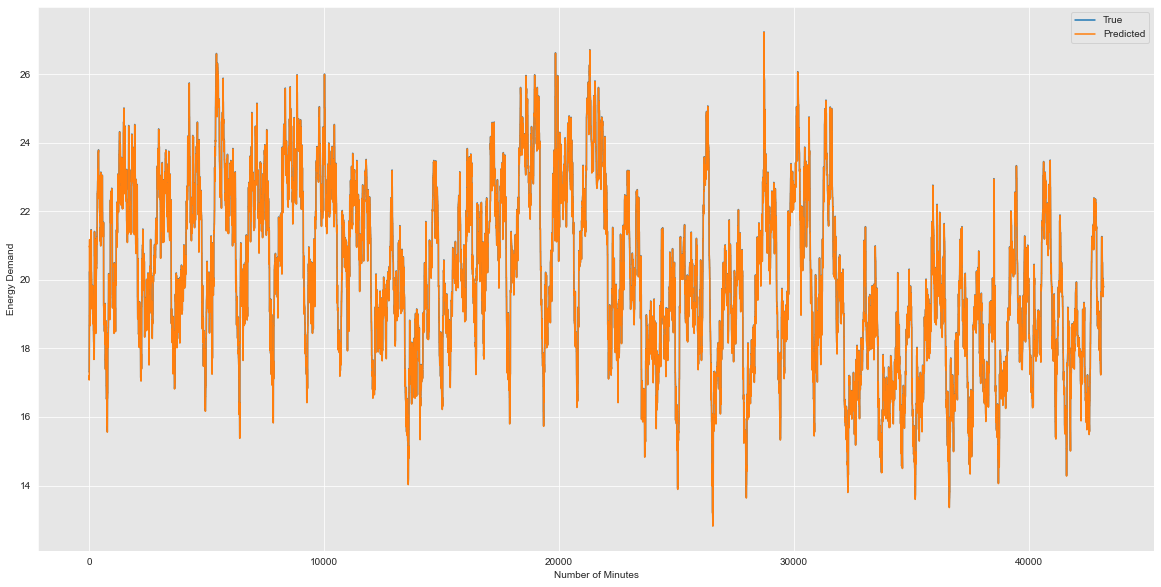

In [9]:


# line plot of observed vs predicted

#sns.set_style("whitegrid")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(20,10))
plt.plot(expectations_plot[:predict_values_exp], label="True")
plt.plot(predictions_plot[:predict_values_exp], label="Predicted")
plt.legend(loc='upper right')
plt.xlabel("Number of Minutes")
plt.ylabel("Energy Demand")
plt.savefig('img/Model_prediction.png')
#plt.show()